# TEAM-SASA     
### Initial POC and EDA for ABS-CBN Website

In [14]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains

from time import sleep

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

## HELPER CLASS - WEBSCRAPING

In [15]:
DRIVER_PATH = 'C:\Program Files\chromedriver.exe'

class AbscbnScraper:

    def __init__(self, search_url):
        self.urls = []
        self.search_url = search_url
        self.driver = webdriver.Chrome(DRIVER_PATH)

    def crawl(self):
        KEYWORDS = ['Philippines', 'NCR', 'Manila', 'Davao', 'Business', 'Entertainment', 'Life', 'sports', 'spotlight']
        for KEYWORD in KEYWORDS:
            self.search_url = f'https://news.abs-cbn.com/special-pages/search?q=covid+vaccine#gsc.tab=0&gsc.q=vaccine%2B{KEYWORD}&gsc.sort=&gsc.page=1'
            self.driver.get(self.search_url)
            totalpages = self.get_total_pages()
            self.get_pages(totalpages)

    def get_driver(self):
        return self.driver
        
    def get_urls(self):
        return self.urls

    def get_urls_count(self):
        return len(self.urls)

    def get_total_pages(self):
        pages = self.driver.find_elements(By.CSS_SELECTOR, 'div.gsc-cursor-page')
        return len(pages)

    def add_urls(self, page):
        print(f'Start crawling article URLs for page {page}...')
        alinks = self.driver.find_elements(By.CSS_SELECTOR, 'a.gs-title')
        for a in alinks:
            link = a.get_attribute('href')
            if (link != None) and (link not in self.urls):
                self.urls.append(link)
        print('Done.')

    def get_pages(self, totalpages):
        print(f'Total number of pages to crawl: {totalpages}', end='\n\n')
        # Page 1
        self.add_urls(1)
        # Page 2 onwards
        self.driver.maximize_window()
        for p in range(1, totalpages):
            '''
            self.driver.execute_script('window.scrollBy(0, document.body.scrollHeight)', '') 
            pages = self.driver.find_elements(By.CSS_SELECTOR, 'div.gsc-cursor-page')
            pages[p].click()
            '''
            #url = "https://news.abs-cbn.com/special-pages/search?q=vaccination#gsc.tab=0&gsc.q=vaccination&gsc.page=%s" % (p+1)
            self.search_url = self.search_url[:-1]+str(p+1)
            self.driver.get(self.search_url)
            sleep(5)
            self.add_urls(p+1)

    def close_popups(self):
        try:
            self.driver.find_element(By.XPATH, '//*[@id="survicate-box"]/div/div/div[3]/div[2]/button').click()
        except:
            pass
        try:
            self.driver.find_element(By.XPATH, '//*[@id="onesignal-slidedown-cancel-button"]').click()
        except:
            pass
        try:
            # Close footer ads
            self.driver.find_element(By.XPATH, '//*[@id="__next"]/div/div[16]//following::div/p/span').click()
        except:
            pass

    def scrape_data(self, url):
        ### PREPARE ARTICLE URL
        self.driver.get(url)
        sleep(15)

        ### PREPARE TITLE
        title = self.driver.find_element(By.CSS_SELECTOR, 'h1.news-title')
        title = title.text.split(', ')[0]
        print(f'\n[Title]\n{title}')

        ### PREPARE PUBLISHED DATE
        pubdate = self.driver.find_element(By.CSS_SELECTOR, 'p.timestamp-entry')
        pubdate = pubdate.text.replace('Posted at ', '').split(' | ')[0]
        print(f'\n[Date Pulished]\n{pubdate}')
        

        ### PREPARE AUTHOR NAME
        author = self.driver.find_element(By.CSS_SELECTOR, 'h5.author-details')
        author = author.text
        print(f'\n[Author]\n{author}')

        # Try closing popups before clicking 'SEE THE RESULTS' button
        sleep(2)
        self.close_popups()

        ### PREPARE ARTICLE CONTENT
        article = self.driver.find_element(By.CSS_SELECTOR, 'div.article-content')
        article_content = article.text.replace('ADVERTISEMENT','').replace(' \n','').replace('\n ','').replace('\n\n','')\
                                      .replace('  ','').replace('Watch more in iWantTFC','').replace('RELATED VIDEO:','')
        print(f'\n[Content]\n{article_content}')
        '''
        ### PREPARE SENTIMENT RESULTS
        # Scroll to 'SEE THE RESULTS' button then simulate click to get sentiment results
        sleep(3)
        sentiment_classname = self.driver.find_element(By.XPATH, '//*[@id="__next"]/div/div[16]/div[6]/div[4]/following::div').get_attribute('class')
        self.driver.execute_script(f'document.getElementsByClassName("{sentiment_classname}").scrollIntoView', '')
        
        # Automate click event to get sentiment results
        sentiment_index = 0
        for i in range(100):
            try:
                btn_sentiment = self.driver.find_element(By.XPATH, f'//*[@id="__next"]/div/div[16]/div[6]/div[4]/div[{i}]/div/div/span')
                if btn_sentiment.text.upper() == 'SEE THE RESULTS':
                    sleep(2)
                    self.close_popups()
                    action = ActionChains(self.driver)
                    action.move_to_element(btn_sentiment).click().perform()
                    # btn_sentiment.click()
                    sentiment_index = i
                    break
            except:
                pass

        sleep(3)
        # Clean some sentiment texts
        sentiment_results = self.driver.find_element(By.XPATH, f'//*[@id="__next"]/div/div[16]/div[6]/div[4]/div[{sentiment_index}]/div')
        sentiment_results = sentiment_results.text.replace('HOW OTHERS ARE FEELING', '').replace(' \n','').replace('\n ','').replace(' ARE ','-')
        # Convert each line of sentiment text to a list item
        sentiment_results = list(filter(None, sentiment_results.split('\n')))
        # Make a key-value pair of sentiment text and store it as dictionary object
        sentiment_results = {s.split('-')[1] : float(s.split('-')[0].split('%')[0])*.01 for s in sentiment_results}
        # Add a 0% value for sentiment key that does not have results in the current article and store as 'other sentiments'
        sentiment_keys = ['INSPIRED', 'HAPPY', 'AMUSED', 'NEUTRAL', 'ANNOYED', 'SAD', 'ANGRY', 'AFRAID']
        sentiment_others = {k : 0. for k in sentiment_keys if k not in sentiment_results}
        # Combine 'other sentiment dictionary' to the 'sentiment result dictionary' 
        sentiment_results = {**sentiment_results, **sentiment_others}
        print(f'\n[Sentiment]')
        print(sentiment_results)
        '''

        ### GET SENTIMENT RESULTS FROM ARTICLE
        return {'urls':url, 'titles':title, 'authors':author, 'published_dates':pubdate, 'articles_content':article_content}
    

# RUN WEB SCRAPING

In [16]:
KEYWORDS = 'Philippines'

SEARCH_URL = f'https://news.abs-cbn.com/special-pages/search?q=covid+vaccine#gsc.tab=0&gsc.q=vaccine%2B{KEYWORDS}&gsc.sort=&gsc.page=1'

scraper = AbscbnScraper(SEARCH_URL)
scraper.crawl()

dataset = []
print(f'\nTotal number of articles: {scraper.get_urls_count()}')
for i,url in enumerate(scraper.get_urls()):
    try:
        print(f'\n\n\n[{i+1}]{" ":>5}SCRAPING DATA  ~>  {url}')
        data = scraper.scrape_data(url)
        dataset.append(data)
    except Exception as e:
        print(f'SCRAPING ERROR: {e}')
        pass

scraper.get_driver().quit()

Total number of pages to crawl: 10

Start crawling article URLs for page 1...
Done.
Start crawling article URLs for page 2...
Done.
Start crawling article URLs for page 3...
Done.
Start crawling article URLs for page 4...
Done.
Start crawling article URLs for page 5...
Done.
Start crawling article URLs for page 6...
Done.
Start crawling article URLs for page 7...
Done.
Start crawling article URLs for page 8...
Done.
Start crawling article URLs for page 9...
Done.
Start crawling article URLs for page 10...
Done.
Total number of pages to crawl: 10

Start crawling article URLs for page 1...
Done.
Start crawling article URLs for page 2...
Done.
Start crawling article URLs for page 3...
Done.
Start crawling article URLs for page 4...
Done.
Start crawling article URLs for page 5...
Done.
Start crawling article URLs for page 6...
Done.
Start crawling article URLs for page 7...
Done.
Start crawling article URLs for page 8...
Done.
Start crawling article URLs for page 9...
Done.
Start crawling 


[Title]
Covaxin maker can allocate at least 10M COVID-19 vaccine doses for PH - distributor

[Date Pulished]
Mar 09 2021 12:22 PM

[Author]
ABS-CBN News

[Content]

MANILA - The manufacturer of COVID-19 vaccine Covaxin can allocate at least 10 million doses for the Philippines, an adviser to one of the local distributors said Tuesday.
India's Bharat Biotech and the state-run Indian Council of Medical Research developed Covaxin together, and it was approved by the country's drug regulator based on early and intermediate studies. Prime Minister Narendra Modi was inoculated with the drug earlier this month.
Modi takes home-grown vaccine as India widens immunization drive
Bharat Biotech reported last week that its vaccine has an interim vaccine efficacy of 81% in late-stage clinical trials. This analysis was based on the trial among 25,800 participants.
The company has applied for emergency use authorization in the Philippines last January.
India’s Bharat Biotech applies for emergency use


[Title]
Philippines' slow COVID-19 vaccine procurement 'embarrassing'

[Date Pulished]
Jan 05 2021 11:41 AM

[Author]
Katrina Domingo, ABS-CBN News

[Content]
MANILA - Sen. Panfilo Lacson on Tuesday said the Philippines' slow procurement of COVID-19 vaccines is "embarrassing" as the country still continues to study which brand should be procured, while other nations have either begun mass inoculations or are awaiting delivery.
Other countries have already purchased COVID-19 vaccines while the Philippines has yet to place an actual order for the drug, Lacson said in an interview on TeleRadyo.
"Parang kahiya-hiya na 'yung gobyerno... Naka-ilang loans na ba tayo para sa vaccine? Bakit hanggang ngayon ay wala tayong vaccine?" the senator said.
(The government looks embarrassing... How many loans have we gotten for the vaccine? Why don't we have the vaccines up to now?)
The Philippines' 2.5 million doses from AstraZeneca was made possible because the private sector helped fund the deal pro


[Title]
Sinovac says to deliver COVID-19 vaccine to Philippines 'very soon'

[Date Pulished]
Feb 24 2021 06:54 PM

[Author]
ABS-CBN News

[Content]
Vials of the Sinovac coronavirus disease (COVID-19) vaccine are pictured at Bangkok's Suvarnabhumi International Airport in Bangkok, Thailand Feb. 24, 2021. Athit Perawongmetha, ReutersMANILA — China-based pharmaceutical firm Sinovac Biotech said on Wednesday it would deliver COVID-19 shots to the Philippines "very soon", after its product was granted emergency use authorization (EUA) in the Southeast Asian nation.
The vaccine maker is working "very closely" with the Chinese customs bureau to clear the shipment of 600,000 doses Beijing is donating to Manila, said Sinovac general manager Helen Yang.
"We are working very hard with our Philippines counterpart to prepare for the delivery. The product has already been prepared, so, we just need to finalize the procedures with the Custom and then we can fix the date of the flight," she said in a


[Title]
FAST FACTS: The COVID-19 vaccination rollout in the Philippines

[Date Pulished]
Mar 01 2021 07:44 PM

[Author]
ABS-CBN News

[Content]
Nurse Chareluck Santos receives her first dose of the Sinovac vaccine at the Philippine General Hospital this March 1, 2021. She was the health worker in charge of vaccinating Dr. Gerardo Legaspi, the hospital's director and first recipient of the vaccine.
MANILA — The Philippines has started its vaccination program with jabs from Beijing-based drug maker Sinovac Biotech on Monday, in hopes of an immediate return to normalcy as the country races to stop the spread of the coronavirus disease (COVID-19).This year, the country aims to inoculate 70 million of its 108 million people to achieve herd immunity and reopen an economy that in 2020 saw its worst contraction on record, due largely to tight restrictions on movement in place since mid-March.
Here's what you need to know about the vaccination program in the Philippines:
What vaccines are avai


[Title]
Philippines to get access to US coronavirus vaccine

[Date Pulished]
Nov 17 2020 03:39 PM

[Author]
Jamaine Punzalan, ABS-CBN News

[Content]
Vials with a sticker reading "COVID-19/Coronavirus vaccine/Injection only" and a syringe are seen in front of a displayed Moderna logo in this illustration taken Oct. 31, 2020. Dado Ruvic, Reuters/File
MANILA - The Philippines will have access to the coronavirus vaccine of the US, Malacañang said Tuesday, after a biotech firm in its Western ally announced that its drug against the COVID-19 disease was almost 95-percent effective.The US' top infectious disease scientist on Monday hailed the coronavirus vaccine of Moderna as "stunningly impressive", following a clinical trial with more than 30,000 participants. Last week, American pharmaceutical company Pfizer and its German partner BioNTech also said their vaccine was 90 percent effective."We have firm commitments from the United States... that we will have access po to COVID vaccines tha


[Title]
Philippines may get Pfizer COVID-19 shots in ‘couple of weeks’: envoy

[Date Pulished]
Mar 05 2021 01:46 PM

[Author]
ABS-CBN News

[Content]
A health care worker of ASL Roma 1 holds a syringe with a dose of the Pfizer-BioNTech vaccine during the coronavirus disease (COVID-19) vaccination campaign, as the country sees a surge in the number of infections, in Rome, Italy, March 4, 2021. Guglielmo Mangiapane, Reuters
MANILA — The Philippines may receive COVID-19 shots from US-based Pfizer through vaccine-sharing COVAX Facility in "the next couple of weeks," an envoy said on Friday.This, as the Philippines continued its inoculation drive on its first week, following vaccine shipments from China's Sinovac on Sunday, a donation by the Chinese government, and AstraZeneca on Thursday, the first batch from the vaccine-sharing platform.The lack of an indemnity deal had delayed the supposed arrival in mid-February of 117,000 Pfizer doses from the COVAX scheme.WHO: PH to be among biggest 


[Title]
Philippines holds simulation for COVID-19 vaccine arrival

[Date Pulished]
Feb 09 2021 03:23 PM

[Author]
George Calvelo, ABS-CBN News
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.article-content"}
  (Session info: chrome=89.0.4389.82)




[21]     SCRAPING DATA  ~>  https://news.abs-cbn.com/news/02/10/21/australia-expresses-support-for-philippines-vaccination-program

[Title]
Australia expresses support for Philippines' vaccination program

[Date Pulished]
Feb 10 2021 08:00 PM

[Author]
Willard Cheng, ABS-CBN News

[Content]
MANILA - Australia on Wednesday expressed support for the Philippines' vaccine rollout against COVID-19, as it is expected to launch this month.
Australian Ambassador to the Philippines Steven Robinson said in a tweet his country will support “to ensure COVID-19 vaccines are distributed efficiently.”He discussed with vaccine czar Secretary Carlito Galvez, Health Secretary Francisco Duque III,


[Title]
Philippines eyes distribution of AstraZeneca vaccines to hospitals Friday

[Date Pulished]
Mar 05 2021 09:08 AM

[Author]
ABS-CBN News

[Content]
Some 487,200 doses of AstraZeneca COVID-19 vaccines from COVAX facility arrived at Villamor Air Base in Pasay City on March 4, 2021. PCOO-OGMPA handout
MANILA - The Philippine government may begin distributing a shipment of AstraZeneca COVID-19 vaccines to different hospitals late Friday, the country's testing czar said.
"Siguro po magsisimula either later today or tomorrow ang pagdi-distribute sa mga iba't ibang ospital ang AstraZeneca," testing czar Vince Dizon told Telerdayo.
(Maybe, the distribution of AstraZeneca [vaccine] to different hospitals will start either today or tomorrow.)
Through the global vaccine-sharing initiative COVAX Facility, some 487,200 doses of AstraZeneca vaccine arrived in the country Thursday night.
487,200 doses of AstraZeneca COVID-19 vaccines from COVAX Facility arrive in PH
Dizon said hospitals who re


[Title]
Philippines to spend P82.5B to buy 148 million COVID-19 vaccine doses

[Date Pulished]
Jan 11 2021 12:02 PM

[Author]
Katrina Domingo, ABS-CBN News

[Content]
MANILA - The Philippines is set to spend P82.5 billion for the procurement of 148 million doses of COVID-19 from 7 pharmaceutical companies.
P70 billion will be sourced from foreign loans and grants, P10 billion will come from Bayanihan to Recover as One Act, while another P2.5 billion is lodged in the Department of Health's budget.
"All negotiations are very successful. We are now on the final stages of supply agreement," vaccine czar Carlito Galvez told lawmakers during the Senate Committee of the Whole investigation on COVID-19 vaccines.
"The reality is that more than 80 percent of global supply has already been procured by rich countries," he said
The government is eyeing to jab between 50 and 70 million Filipinos this year, he said.
"We are in the process of evaluating the vaccines and the current recommendation is 


[Title]
Philippines secures 25 million COVID-19 vaccine doses from China's Sinovac

[Date Pulished]
Jan 11 2021 12:47 PM

[Author]
Jamaine Punzalan, ABS-CBN News

[Content]
A man works in a laboratory of Chinese vaccine maker Sinovac Biotech, developing an experimental coronavirus disease (COVID-19) vaccine, during a government-organized media tour in Beijing, China, Sept. 24, 2020. Thomas Peter, Reuters/FileMANILA (UPDATE) — The Philippines has secured 25 million COVID-19 vaccine doses from Chinese drug maker Sinovac, Malacañang said on Monday, as nations raced to inoculate their people against the disease that had spurred lockdowns, deaths and recessions."Darating na ang bakuna sa Pilipinas sa susunod na buwan," said Presidential Spokesperson Harry Roque.
(The vaccine will arrive in the Philippines next month.)
2 COVID-19 vaccines may arrive in PH next month: DOH
"Huwag naman kayong masyadong mag-celebrate d'yan dahil ang unang dadating po ay 50,000 doses lamang ng vaccine galing sa


[Title]
Philippines

[Date Pulished]
Nov 27 2020 03:45 PM

[Author]
ABS-CBN News

[Content]
AstraZeneca says vaccine needs further research
AstraZeneca's logo is reflected in a drop on a syringe needle in this illustration taken Nov. 9, 2020. Dado Ruvic, Reuters/Illustration
MANILA (UPDATE) — The Philippines and private firms inked Friday a supply agreement for British drug group AstraZeneca's potential COVID-19 vaccine, the first such deal in a country aiming to further reopen its economy that has been ravaged by the pandemic.
The private firms will pay for the vaccine and donate half of the supply to the government, with the other half to be used to cover employees in the private sector, said Joey Concepcion, a government business adviser.The deal secures 2.6 million doses of the vaccine, set to arrive in the Philippines in May or June 2021. This will inoculate over 1 million Filipinos as the vaccine requires 2 doses, Concepcion said in a livestream of the ceremonial signing.The mov


[Title]
Philippines to ink deal for 20 million doses of AstraZeneca's COVID-19 vaccine this week

[Date Pulished]
Jan 13 2021 01:47 PM

[Author]
Jamaine Punzalan, ABS-CBN News

[Content]
A healthcare worker fills a syringe with a dose of AstraZeneca coronavirus disease (COVID-19) vaccine at the Pentland Medical Practice, in Currie, Scotland, Britain Jan. 7, 2021. Russell Cheyne, Pool/ReutersMANILA (UPDATED) — The Philippines this week will sign a supply deal for 20 million doses of the COVID-19 vaccine from British drug group AstraZeneca, an official leading the immunization effort against the disease said on Wednesday.
AstraZeneca COVID-19 vaccine can be 90% effective, results show
"Bukas nga po ay aming pipirmahan, lalagdaan po namin ang tripartite agreement na more or less 20 million doses para sa AstraZeneca," said Carlito Galvez Jr, Chief Implementer of the National Task Force COVID-19."Hindi po tayo nahuhuli," he said in a public briefing.(Tomorrow, Thursday, we will sign a trip


[Title]
Expert believes COVID-19 vaccine to arrive in PH by Q2 of 2021 the ‘earliest’

[Date Pulished]
Sep 09 2020 12:43 AM

[Author]
ABS-CBN News

[Content]
In this file photo Dr. Nita Patel, Director of Antibody discovery and Vaccine development, lifts a vial with a potential coronavirus, COVID-19, vaccine at Novavax labs in Gaithersburg, Maryland on March 20, 2020, one of the labs developing a vaccine for the coronavirus, COVID-19. Andrew Caballero-Reynolds, AFP
MANILA - A public health expert said Tuesday he doesn't expect a COVID-19 vaccine to be available in the Philippines until the second quarter of 2021, urging the public to take coronavirus precautions more seriously.
Dr. Jaime Montoya, executive director of the Philippine Council for Health Research and Development, tempered hopes that a safe and effective vaccine against the respiratory illness could be ready for use within the year."Base sa nalalaman namin at sa mga datos na available, hindi po yata, kung Pilipinas ang pa


[Title]
Who gets coronavirus vaccine first? Philippines needs 'foresight'

[Date Pulished]
Jul 30 2020 10:49 AM

[Author]
Jamaine Punzalan, ABS-CBN News

[Content]
MANILA — The Philippine government should have "foresight” on how it will administer to 110 million Filipinos the coronavirus vaccine once it becomes available, a governor said Thursday.Authorities "should be ready to respond" to questions on how it will administer 220 million shots of the vaccine, with each person requiring 2 shots of the drug, said Cavite Governor Jonvic Remulla."How do we do it without creating the least amount of panic and hysteria? Who gets it FIRST and how do people get it quickly enough?" he said on Facebook.The government should also apply to the vaccine distribution the lessons it learned from the release of cash aid to the most vulnerable families, which was marred by reports of health protocol violations in some areas, he said.Quoting Sorsogon Governor Chiz Escudero, Remulla said, ”We should expe


[Title]
ADB allots $25 million to help Philippines buy vaccines

[Date Pulished]
Feb 01 2021 11:22 AM

[Author]
ABS-CBN News

[Content]
ABS-CBN News file photo
MANILA — The Asian Development Bank (ADB) on Monday said it has allocated $25 million or around P1.2 billion to help the Philippine government purchase COVID-19 vaccines this year.
ADB said the money will allow the Philippine government to pay vaccine manufacturers in advance to secure the delivery of vaccines to its citizens.“Vaccination is the next critical step to protect lives and promote livelihood opportunities,” said ADB President Masatsugu Asakawa.“We stand ready to support the government in these unprecedented times and help the economy navigate back to its pre-pandemic growth path,” he added.Of the P82.5 billion budget that the Philippines needs to provide vaccines to around 55 percent of the population, P70 billion will be sourced from loans.
More than 2,000 new COVID-19 cases confirmed, tally now at 525,618
Since re


[Title]
What you need to know if you’re volunteering for vaccine clinical trials in PH

[Date Pulished]
Feb 01 2021 09:47 PM

[Author]
Kristine Sabillo, ABS-CBN News

[Content]
MANILA — While the Philippines is gearing up for the COVID-19 vaccine roll-out, the government is also preparing for separate clinical trials with the World Health Organization and pharmaceutical companies.
Clinical trials are different from the anticipated vaccine rollout since the former involves vaccines that have yet to be approved for emergency use.During a virtual townhall with health workers on Monday, Department of Science and Technology - Philippine Council for Health Research and Development (PCHRD) Director Jaime Montoya explained that clinical trials are being done to see if a COVID-19 vaccine is safe and effective for Filipinos.This will “ensure a shorter and easier route of registration with the Philippine Food and Drug Administration (FDA),” he explained.
So far, the FDA has approved clinical tri


[Title]
EU: Philippines exempted from vaccine export ban

[Date Pulished]
Feb 03 2021 10:36 PM

[Author]
ABS-CBN News
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.article-content"}
  (Session info: chrome=89.0.4389.82)




[51]     SCRAPING DATA  ~>  https://news.abs-cbn.com/news/02/10/21/philippines-sets-2023-target-to-finish-covid-19-vaccination-rollout

[Title]
Philippines sets 2023 target to finish COVID-19 vaccination rollout

[Date Pulished]
Feb 10 2021 10:21 AM

[Author]
ABS-CBN News

[Content]
Health workers and frontliners go through a screening process as part of COVID-19 vaccination simulation at the Dr. Jose N. Rodriguez Memorial Hospital in Caloocan City, Feb. 9, 2021. Jonathan Cellona, ABS-CBN News
MANILA - The Philippines is aiming to complete its COVID-19 vaccination program by 2023, a health official said Wednesday, amid global competition of the highly sought-after coronavirus shots.
Health Undersecretar


[Title]
Philippines to get COVID-19 shots from China's Sinovac on Feb. 23

[Date Pulished]
Feb 11 2021 12:32 PM

[Author]
Jamaine Punzalan and Joyce Balancio, ABS-CBN News

[Content]
A worker performs a quality check in the packaging facility of Chinese vaccine maker Sinovac Biotech, developing an experimental coronavirus disease (COVID-19) vaccine, during a government-organized media tour in Beijing, China, Sept. 24, 2020. Thomas Peter, Reuters/File
MANILA (UPDATE) - The Philippines will get an initial batch of 600,000 COVID-19 vaccine shots from China's Sinovac Biotech on Feb. 23, Malacañang said on Thursday."Ang bakuna po na Sinovac na galing naman sa China, nakaukit na po sa bato ang pagdating. Ito po ay a-23 ng Pebrero," Presidential spokesman Harry Roque told reporters in an online briefing.(The arrival of the Sinovac vaccine from China is now set in stone. This will be on the 23rd of February.)
Beijing is donating the vaccine batch, and 100,000 of the doses will go to the Phili


[Title]
Philippines joins global facility that ensures COVID-19 vaccine access

[Date Pulished]
Jul 24 2020 11:32 AM

[Author]
Arianne Merez, ABS-CBN News

[Content]
MANILA - The Philippines is set to join a global coronavirus facility that helps ensure equal access to COVID-19 vaccines, Malacañang announced Friday, after the government's pandemic task force approved the country's participation.
The pandemic task force also approved the corresponding allocation of funds for the country's participation in the COVID-19 Vaccines Global Access (COVAX) facility, Presidential Spokesperson Harry Roque said.
The World Health Organization has described the facility as a "mechanism designed to guarantee rapid, fair, and equitable access to COVID-19 vaccines worldwide."
Health Undersecretary Maria Rosario Vergeire said that COVAX is under the Access to COVID-19 Tools (ACT)-Accelerator, a global collaboration to speed up the development and distribution of COVID-19 vaccines, tests and treatments.


[Title]
Philippines to request 900,000 more Pfizer vaccines from COVAX: Galvez

[Date Pulished]
Feb 03 2021 07:47 PM

[Author]
Pia Gutierrez, ABS-CBN News

[Content]
Vials with a sticker reading "COVID-19 / Coronavirus vaccine / Injection only" and a medical syringe are seen in front of a displayed Pfizer logo in this illustration taken October 31, 2020. Dado Ruvic, Reuters/Illustration/File
MANILA - The Philippines is set to apply for an additional 900,000 Pfizer-BioNTech COVID-19 vaccines from the COVAX Facility, the country’s vaccine czar said Wednesday.
This is on top of the 117,000 initial doses of Pfizer vaccines that the Philippines is set to receive from the initiative that aims to ensure equitable distribution of vaccines, National Task Force on COVID-19 chief implementer Secretary Carlito Galvez said in a public briefing.“Gumagawa po kami ng sulat... if we can have submission for additional more than 900,000 to make it 1 million iyong ating vaccine sa Pfizer, ay gagawin po n


[Title]
Philippines to get 30 million doses of Novavax COVID-19 vaccine

[Date Pulished]
Dec 21 2020 03:57 PM

[Author]
Karen Lema, Reuters

[Content]
DFA Secretary Teodoro Locsion Jr. during a committee hearing on the preparedness on the reported outbreak of the novel corona virus held at the Senate of the Philippines on February 4, 2020. George Calvelo, ABS-CBN News
MANILA - The Philippines expects to receive 30 million doses of Novavax Inc's COVID-19 vaccine by July next year, Foreign Affairs Secretary Teodoro Locsin Jr. said on Monday, boosting the country's effort to secure supplies to inoculate more than 100 million people.
Despite consultations with numerous vaccine makers, the Philippines has so far signed only one supply deal, with the help of its private sector, to acquire 2.6 million shots of a vaccine developed by AstraZeneca.
It plans to buy 25 million doses of a vaccine from China's Sinovac Biotech for delivery by March, and aims to secure between four and 25 million dos


[Title]
Philippines allows emergency use of COVID-19 vaccines

[Date Pulished]
Dec 02 2020 03:41 PM

[Author]
Jamaine Punzalan, ABS-CBN News

[Content]
President Rodrigo Duterte gives a public statement after holding a meeting with the Inter-Agency Task Force on Emerging Infectious Diseases (IATF-EID) at the Arcadia Active Lifestyle Center in Davao City on Nov. 23, 2020. Joey Dalumpines, Presidential Photo
MANILA (UPDATE) — The Philippines has allowed emergency use of vaccines and drugs against COVID-19, 8 months into the crisis that has seen over 430,000 people infected and the economy dragged into recession due to prolonged quarantine restrictions.
President Rodrigo Duterte, in an executive order, has allowed the Food and Drug Administration to issue emergency use authorization for COVID-19 vaccines and drugs.This means that coronavirus vaccines approved by the countries where they were developed can be used locally after 21 days, down from the current required 6-month verification,


[Title]
Health expert warns against getting COVID-19 vaccine from black market

[Date Pulished]
Dec 28 2020 10:37 PM

[Author]
Katrina Domingo, ABS-CBN News

[Content]
A nurse holds China's Sinovac vaccine, a potential vaccine for the coronavirus disease (COVID-19), at the Sao Lucas Hospital of the Pontifical Catholic University of Rio Grande do Sul (PUCRS), in Porto Alegre, Brazil Aug. 8, 2020. Diego Vara, Reuters/File
MANILA - Some Filipinos are looking for ways to get inoculated against COVID-19 as the government has yet to say with certainty the schedule of the availability of the vaccine against the new coronavirus in the Philippines, a health expert said Monday.
But, according to Dr. Tony Leachon, who used to be part of the inter-agency task force against COVID-19, getting the vaccine from the black market could sabotage the government's vaccination program.
Leachon told ABS-CBN News that aside from the black market, some Filipinos are also planning to travel abroad because they


[Content]
Nurse Krujane Solano wipes her sweat during her shift at the Quirino Memorial Medical Center Endoscopy Unit, which is temporarily being used as the PUI-COVID Operating Room on May 8, 2020. Gigie Cruz, ABS-CBN News/File
MANILA — The public should ask officials leading the country's COVID-19 response why the government has to offer deploying more nurses to Britain to get coronavirus vaccines, a senator said on Thursday, as the Philippine immunization drive lagged.Malacañang on Wednesday backed the labor department's statement that the Philippines was open to lifting the cap on health workers' overseas deployment in exchange for vaccines from Britain and Germany, which it would use to inoculate outbound workers and hundreds of thousands of Filipino repatriates.While Labor Secretary Silvestre Bello III and Foreign Affairs Secretary Teodoro Locsin Jr, who initiated the offer, are "very good people," Sen. Joel Villanueva said he disagreed with trading Filipino nurses for COVID-19 


[Title]
Pfizer

[Date Pulished]
Jan 14 2021 01:59 PM

[Author]
Jamaine Punzalan, ABS-CBN News

[Content]
A health care worker prepares a dose of the Pfizer-BioNTech COVID-19 vaccine at "Chez Mauricette" coronavirus disease vaccination center in Poissy near Paris, France, Jan. 13, 2021. Gonzalo Fuentes, Reuters
MANILA — COVID-19 vaccines from US-based Pfizer and Russia's Gamaleya Institute may arrive in the Philippines in February, Malacañang said on Thursday, as authorities raced to book supplies of the drug to begin inoculations as the coronavirus pandemic persisted over a year since it began in China.
Presidential Spokesperson Harry Roque said he was not at liberty to disclose how many jabs from Pfizer would arrive next month. The Food and Drug Administration just approved its application for emergency use approval, which shortens to 21 days the usual 6-month review before local use.
Philippines approves Pfizer's COVID-19 vaccine for emergency use
"Makakatanggap na rin daw tayo ng i


[Title]
Rumors and fear dog Philippine plan for coronavirus vaccine drive

[Date Pulished]
Jan 28 2021 09:22 AM

[Author]
Karen Lema, Reuters

[Content]
Health workers participate in a vaccination simulation at Pedro P. Cruz Elementary School, in Mandaluyong City on Jan. 27, 2021. Jonathan Cellona, ABS-CBN News
MANILA - According to one rumor circulating in the Philippines, the coronavirus vaccine will allow President Rodrigo Duterte to kill people at the push of a button.
Elsewhere in the country of 108 million, memories of a dengue vaccine that has been banned locally are putting people off the idea of immunization even before the campaign begins.
"Many kids got sick after receiving that vaccine," 62-year-old Crisanta Alipio said of the ill-fated vaccine against dengue, a mosquito-borne disease that can be deadly.
She said she was afraid of the novel coronavirus but even more afraid of vaccination.
The Philippines is due to start immunizations next month despite suffering Southeast 


[Title]
India’s Bharat Biotech applies for emergency use authorization in PH for its COVID-19 vaccine

[Date Pulished]
Jan 21 2021 11:54 AM

[Author]
Kristine Sabillo, ABS-CBN News

[Content]
MANILA (UPDATE) — The Food and Drug Administration on Thursday confirmed that India-based Bharat Biotech has applied for emergency use authorization in the Philippines for its COVID-19 vaccine.
“They submitted an application this morning and pre-evaluation is going on,” FDA Director General Eric Domingo told ABS-CBN News.
Vaccine czar Secretary Carlito Galvez Jr. said during Thursday’s Laging Handa briefing that Bharat Biotech vaccine is one of those being considered for procurement by the Philippine government. But he said they have yet to see the results of its clinical trials.
The EUA application was also confirmed by IP Biotech and Ambica International, which have an exclusive agreement with Bharat Biotech to distribute the so-called COVAXIN vaccine in the Philippines.
According to the group,


[Title]
Know your COVID-19 vaccine

[Date Pulished]
Jan 13 2021 02:05 PM

[Author]
Text by Kristine Sabillo, Infographic by Pamela Ramos, ABS-CBN News
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.article-content"}
  (Session info: chrome=89.0.4389.82)




[82]     SCRAPING DATA  ~>  https://news.abs-cbn.com/news/02/19/21/vaccine-czar-apologizes-for-delay-in-arrival-of-covid-19-shots

[Title]
Vaccine czar apologizes for delay in arrival of COVID-19 shots

[Date Pulished]
Feb 19 2021 12:23 PM

[Author]
Jamaine Punzalan, ABS-CBN News

[Content]
National Task Force Against COVID-19 chief implementer Secretary Carlito Galvez Jr. gives updates to President Rodrigo Duterte during a meeting with the Inter-Agency Task Force on Emerging Infectious Diseases (IATF-EID) at the Arcadia Active Lifestyle Center in Matina, Davao City, February 15, 2021. Joey Dalumpines, Presidential Photo
MANILA — An official leading the country's COVID-1


[Title]
Chinese COVID-19 vaccine makers to seek Philippine use greenlight this week: envoy

[Date Pulished]
Jan 04 2021 01:55 PM

[Author]
Jamaine Punzalan, ABS-CBN News

[Content]
People submit forms to receive the coronavirus disease (COVID-19) vaccine at a makeshift vaccination site in Beijing's Chaoyang district, China Jan. 3, 2021. cnsphoto/Reuters
MANILA — Two Chinese makers of vaccines against the novel coronavirus will seek emergency use authorization (EUA) in the Philippines "sometime this week", Manila's envoy to Beijing said on Monday.An EUA will authorize a vaccine's use in the Philippines after a quicker than usual, 21-day study by the Food and Drug Administration.Beijing-backed Sinopharm and Sinovac plan “to file [their EUA application] in the next few days, sometime this week,” Ambassador Chito Sta. Romana said in a press briefing.
Confused between Sinovac and Sinopharm? What to know about their COVID-19 vaccines
EXPLAINER: What we know about China-made vaccines
Some me


[Title]
Duterte: National recovery 'within sight' as Philippines secures COVID-19 shots

[Date Pulished]
Jan 14 2021 07:03 PM

[Author]
Jamaine Punzalan, ABS-CBN News

[Content]
President Rodrigo Duterte addresses the public from the Malacañang Golf (Malago) Clubhouse in Malacañang Park, Manila on Jan. 13, 2021. Richard Madelo, Presidential Photo
MANILA — President Rodrigo Duterte said national recovery from the COVID-19 pandemic is "within sight" as the Philippines secures vaccine jabs against the respiratory disease that has led to nearly a year-long lockdown and economic recession.
Duterte said this in a taped message as local government units and private firms helped lock in 17 million doses so far of the COVID-19 vaccine from British drugs group AstraZeneca.
"There is light at the end of the tunnel. National recovery is within sight. As we bounce back and heal as one, I commend the business community and the LGUs for your ramping of support for our nation’s fight against COVID-19


[Title]
Access to COVID-19 vaccine for all Filipinos may be available only in 2022: official

[Date Pulished]
Nov 30 2020 01:14 PM

[Author]
Davinci Maru, ABS-CBN News

[Content]
A woman holds a small bottle labeled with a "Coronavirus COVID-19 Vaccine" sticker and a medical syringe in this illustration taken Oct. 30, 2020. Dado Ruvic, Reuters/File
MANILA - Most Filipinos may have to wait until 2022 to get a shot of the coronavirus vaccine, an official leading the country's pandemic response said Monday, as the government will prioritize health-care workers and other vulnerable groups, with vaccine supply expected to be initially limited.
Speaking to ANC's Matters of Fact, vaccine czar Sec. Carlito Galvez said equitable access to COVID-19 vaccine may be available only in 2022, despite encouraging results from some vaccine candidates that are nearing regulatory approval.
"Only maybe in 2022 we'll have maybe equitable access with the [vaccine]," he said.
"Maybe, during 2022 when we have


[Title]
Philippine Red Cross in talks with Pfizer

[Date Pulished]
Jan 05 2021 02:36 PM

[Author]
Katrina Domingo, ABS-CBN News

[Content]
A woman holds a small bottle labeled with a "Coronavirus COVID-19 Vaccine" sticker and a medical syringe in this illustration taken Oct. 30, 2020. Dado Ruvic, Reuters/File
MANILA - The Philippine Red Cross (PRC) on Tuesday said it is in talks with pharmaceutical giants Pfizer and AstraZeneca to procure COVID-19 vaccines that would be sold to Filipinos on a "buy 1, donate 1" scheme.
The Philippine Red Cross has written a letter to the 2 pharmaceutical giants to procure some 1 million doses of the COVID-19 vaccine, PRC chair Sen. Richard Gordon told reporters in an online press conference.
"The first plan of the Red Cross is to vaccinate... Ang labanan dito distribution [na] mabilis (This is a matter of the quick distribution of vaccines)," he said.
The PRC is set to meet with Pfizer representatives after the press conference, he said.
"It's [in the]


[Title]
COVID-19 task force allows more foreigners to enter Philippines by mid-February

[Date Pulished]
Feb 05 2021 11:47 AM

[Author]
Jamaine Punzalan, ABS-CBN News

[Content]
Passengers wearing hazmat suits for protection against the coronavirus disease (COVID-19) walk inside the Ninoy Aquino International Airport in Parañaque, Jan. 14, 2021. Eloisa Lopez, Reuters/File
MANILA — An inter-agency task force leading the country's COVID-19 response has expanded its list of foreigners who will be allowed to enter the Philippines in the middle of February, Malacañang said on Friday.Effective Feb. 16, the following foreign nationals will be allowed entry to the country, said Palace spokesman Harry Roque.Those with visas issued as of March 20, 2020, and still valid and existing at the time of entry, and who were not permitted to enter the country under previous IATF resolutions
Holders of valid and existing Special Resident and Retirees Visa and Section 9 (A) visas as long as they present a


[Title]
Duterte Cabinet to tackle immunization amid NCR

[Date Pulished]
Feb 06 2019 05:51 PM

[Author]
Dharel Placido, ABS-CBN News

[Content]
MANILA - President Rodrigo Duterte will discuss with his Cabinet the country’s immunization programs, a Palace official said Wednesday, as the health department declared a measles outbreak in Metro Manila and Central Luzon.
Measles outbreak declared in NCR, Central Luzon
Secretary to the Cabinet Karlo Nograles said the immunization program is on the agenda of Wednesday’s Cabinet meeting.
The Department of Health has raised alarm over the rising number of measles cases in the country, with some officials blaming the fiasco involving dengue vaccine Dengvaxia for the reluctance of some parents to subject their newborns to measles vaccination.
Duterte has urged Filipinos to avail of vaccines with proven efficacy, especially for newborns.
Duterte urges Filipinos to get vaccinated
Cases of measles, locally known as "tigdas," rose by 550 percent from


[Title]
What the public needs to know

[Date Pulished]
Jan 17 2020 12:48 AM

[Author]
Niña Corpuz, ABS-CBN News

[Content]
When the Department of Health (DOH) confirmed last September that polio is back in the country after 19 years, members of the Filipino medical community shook their heads. How could we let this happen?Some were quick to point out that it was the result of vaccine hesitancy after the Dengvaxia controversy in 2017. But it wasn’t as simple as that.A November 2019 polio outbreak situation report from the UNICEF-WHO Philippines attributed the outbreak to persistently low routine immunization coverage, as well as poor sanitation and hygiene.Polio is spread through fecal-oral transmission in contaminated food or water, or through direct contact with a person infected with polio.“It was like a time bomb, waiting to explode,” said Dr. Gigi Bibera, pediatrician and member of the Pediatric Infectious Society of the Philippines (PIDSP).
Bibera said it took many years for the 

SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"h1.news-title"}
  (Session info: chrome=89.0.4389.82)




[110]     SCRAPING DATA  ~>  https://news.abs-cbn.com/news/02/26/21/alamin-mga-dapat-malaman-tungkol-sa-paparating-na-bakuna-ng-sinovac

[Title]
ALAMIN: Mga dapat malaman tungkol sa paparating na bakuna ng Sinovac

[Date Pulished]
Feb 26 2021 08:23 PM

[Author]
ABS-CBN News

[Content]
Handout mula sa Sinovac
MAYNILA - Matatanggap na ng Pilipinas ang sarili nitong supply ng bakuna mahigit 2 buwan matapos maiturok ang kauna-unahang coronavirus disease (COVID-19) vaccine para sa emergency use sa buong mundo.Ito ang CoronaVac, isang inactivated virus vaccine mula sa Chinese company na Sinovac.Hindi tulad ng mga naunang nailabas na bakuna tulad ng sa Moderna at Pfizer na gawa gamit ang makabagong teknolohiya ng messenger RNA, ang Sinovac ay gumagamit ng mas tradisyunal na klase ng bakuna.Gamit ng CoronaVac ang inactivated o pinata


[Title]
Philippine government negotiating with 4 COVID-19 vaccine-makers

[Date Pulished]
Nov 24 2020 12:32 AM

[Author]
Rose Carmelle Lacuata, ABS-CBN News

[Content]
A man works in the packaging facility of Chinese vaccine maker Sinovac Biotech, developing an experimental coronavirus disease (COVID-19) vaccine, during a government-organized media tour in Beijing, China, September 24, 2020. Thomas Peter, Reuters/File Photo
Areas badly hit by COVID-19 to be prioritized in vaccine rollout
MANILA - The Philippine government is negotiating with four pharmaceutical companies developing a vaccine for COVID-19.
Sec. Carlito Galvez Jr., the country's "vaccine czar", said the government's vaccine experts are currently analyzing 17 different COVID-19 vaccines.Of this number, 5 vaccines will be tested on Filipinos, including vaccines developed by China's Sinovac, Russia's Gamaleya, UK's AstraZeneca, and American company Johnson & Johnson.
Galvez also said that after President Rodrigo Duterte al


[Title]
OCTA: Current COVID-19 surge in NCR ‘spreading very quickly in short period’ of time

[Date Pulished]
Mar 06 2021 05:46 AM

[Author]
John Gabriel Agcaoili, ABS-CBN News

[Content]
Commuters head to a bus loading and unloading area along Agham Road in Quezon City, Metro Manila on October 15, 2020. Mark Demayo, ABS-CBN News/File
OCTA researchers flag infections spike in Pasay
MANILA—The COVID-19 positivity rate in Metro Manila is rising steadily as daily coronavirus cases continue to increase, too, analysts said Friday, sounding the alarm on a possible "overwhelming" surge of infections in the National Capital Region (NCR).
The OCTA Research Group said in a report that the number of new COVID-19 cases in the NCR continued to increase, as it tallied over 900 new infections per day from February 26 to March 4. According to the analysts, the ratio of people testing positive for COVID-19 in the region increased to an average of 7 percent over the past 7 days and has risen by 1-perce


[Title]
Protecting children thru MMR vaccination

[Date Pulished]
Feb 07 2019 04:12 PM

[Author]
Teodoro B. Padilla -- Medicine Matters

[Content]
The Department of Health (DOH) declared a measles outbreak in Metro Manila with a spike in measles in cases, while placing several regions under tight watch.Measles outbreak declared in NCR, Central Luzon
Immunization and vitamin A supplementation of 9-month-old children are the best defenses against measles, the DOH said.'Long-standing neglect' caused measles outbreak: expert
The measles, mumps, and rubella (MMR) vaccine is recommended for children because it protects against three potentially serious viral illnesses.
Measles starts as a fever, cough, runny nose, conjunctivitis (pink eye), and a red, pinpoint rash that starts on the face and spreads to the rest of the body. If the virus infects the lungs, it can cause pneumonia. Measles in older children can lead to inflammation of the brain (encephalitis), which can cause seizures and bra

SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"h1.news-title"}
  (Session info: chrome=89.0.4389.82)




[122]     SCRAPING DATA  ~>  https://news.abs-cbn.com/news/02/27/21/metro-manila-9-other-areas-to-remain-under-gcq-in-march-palace

[Title]
Metro Manila

[Date Pulished]
Feb 27 2021 10:06 AM

[Author]
ABS-CBN News

[Content]
MANILA - The National Capital Region and nine other areas will remain under general community quarantine in March to contain the spread of COVID-19, Malacañang said Saturday.This, as the country saw an increase in COVID-19 cases in recent days, with authorities keeping close watch of new, more transmissible virus variants.
"Aprubado na ng presidente ang classification para sa buwan ng Marso. Mananatili po sa general community quarantine o GCQ classification ang National Capital Region, Baguio City at Davao City," Presidential Spokesperson Harry Roque said.
Advisory group OKs use of Sinovac COVID-19 vaccin

SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"h1.news-title"}
  (Session info: chrome=89.0.4389.82)




[127]     SCRAPING DATA  ~>  https://news.abs-cbn.com/news/02/16/21/surgical-precision-metro-manila-hospitals-prep-for-arrival-of-covid-19-vaccines

[Title]
'Surgical precision': Metro Manila hospitals prep for arrival of COVID-19 vaccines

[Date Pulished]
Feb 16 2021 07:54 AM

[Author]
ABS-CBN News

[Content]

MANILA - Two of the priority hospitals for COVID-19 vaccination are preparing to receive the first shots of inoculation, officials said Tuesday.
Health workers in 4 NCR hospitals are on top of COVID-19 vaccination list
Nearly all Philippine General Hospital workers register for COVID-19 vaccination
Jose N. Rodriguez Memorial Hospital, the only remaining COVID-19 referral center for purely mild to critical cases, will vaccinate some 1,911 workers in a span of 7 days, according to its medical director Alfonso Famaran.
Th


[Title]
COVID-19 cases in Philippines top 600,000 as infections in NCR remain high

[Date Pulished]
Mar 09 2021 04:06 PM

[Author]
Kristine Sabillo, ABS-CBN News

[Content]
San Juan City launches its vaccination program, with medical frontliners from the San Juan Medical Center first getting inoculated with the Sinovac vaccine at the Filoil Flying V Arena on March 6, 2021. George Calvelo, ABS-CBN News
MANILA — Coronavirus infections in the Philippines climbed to 600,428 on Tuesday after the Department of Health (DOH) reported 2,668 new COVID-19 cases.
During the past few days, the country was logging more than 3,000 daily cases.
Tuesday's tally did not include data from 8 laboratories that failed to submit results on time.The DOH also announced 7 new COVID-related deaths or a total of 12,528 fatalities, accounting for 2.09 percent of the cumulative total cases.
There are also 171 new recovered patients or a total of 546,078 recoveries.
Active cases in the country stood at 41,822, or 7

SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"h1.news-title"}
  (Session info: chrome=89.0.4389.82)




[136]     SCRAPING DATA  ~>  https://news.abs-cbn.com/news?page=453
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"h1.news-title"}
  (Session info: chrome=89.0.4389.82)




[137]     SCRAPING DATA  ~>  https://news.abs-cbn.com/news?=EK85dRpA&page=14
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"h1.news-title"}
  (Session info: chrome=89.0.4389.82)




[138]     SCRAPING DATA  ~>  https://news.abs-cbn.com/list/tag/domingo?page=9
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"h1.news-title"}
  (Session info: chrome=89.0.4389.82)




[139]     SCRAPING DATA  ~>  https://news.abs-cbn.com/news/01/11/21/several-cities-in-metro-manila-secure-covid-19-vaccine-su


[Title]
Sinovac's COVID-19 vaccine not recommended for health workers - FDA

[Date Pulished]
Feb 22 2021 03:06 PM

[Author]
Kristine Sabillo, ABS-CBN News

[Content]
A staff member works during a media tour of a new factory built to produce a COVID-19 coronavirus vaccine at Sinovac, one of 11 Chinese companies approved to carry out clinical trials of potential coronavirus vaccines, in Beijing on September 24, 2020. Wang Zhao, AFP
MANILA — Sinovac’s COVID-19 vaccine is not recommended for health workers, the Food and Drug Administration said Monday as it announced the approval of the product for emergency use in the Philippines.
“It has a lower efficacy rate of 50.4% when used on health care workers exposed to COVID-19. Therefore, it is not recommended for use in this group,” FDA Director General Eric Domingo said during a Laging Handa briefing.
Health workers, numbering 1,762,994, top the country's list of priority sectors to receive COVID-19 vaccines once supplies arrive.
LIST: Sub-g

SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"h1.news-title"}
  (Session info: chrome=89.0.4389.82)




[149]     SCRAPING DATA  ~>  https://news.abs-cbn.com/news/01/13/21/ph-to-hold-dry-run-for-arrival-of-first-batch-of-covid-19-vaccines

[Title]
PH to hold dry run for arrival of first batch of COVID-19 vaccines

[Date Pulished]
Jan 13 2021 07:27 PM

[Author]
Kristine Sabillo, ABS-CBN News

[Content]

MANILA — The Philippines will hold a dry run next week to ensure that facilities are ready to receive the first batch of COVID-19 vaccines supposed to arrive next month, a top pandemic response official said Wednesday.Vaccine czar Secretary Carlito Galvez said there will be a simulation of the arrival of the vaccine at the airport and inspection of storage and medical facilities.
“Bibisitahin namin ang airport at titingnan namin, i-simulate namin 'yung pagdating ng unang vaccine. From there pupunta tayo sa warehouse, sa cold chai

SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"h1.news-title"}
  (Session info: chrome=89.0.4389.82)




[157]     SCRAPING DATA  ~>  https://news.abs-cbn.com/news/01/25/21/pfizers-covid-19-vaccine-may-reach-other-areas-depending-on-storage-facilities-doh

[Title]
Pfizer’s COVID-19 vaccine may reach other areas depending on storage facilities - DOH

[Date Pulished]
Jan 25 2021 10:05 PM

[Author]
Kristine Sabillo, ABS-CBN News

[Content]
A woman holds a small bottle labeled with a "Coronavirus COVID-19 Vaccine" sticker and a medical syringe in front of displayed Pfizer logo in this illustration taken, October 30, 2020. Dado Ruvic, Reuters/file
MANILA — The COVID-19 vaccine of Pfizer can still be deployed to other areas in the Philippines depending on the ultra cold storage options that will be offered by the private sector, the health department said Monday.
“Initially, we have these facilities na sabi natin kaya natin sa Metro M

SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"h1.news-title"}
  (Session info: chrome=89.0.4389.82)




[161]     SCRAPING DATA  ~>  https://news.abs-cbn.com/news/02/14/21/3-sa-10-indibidwal-lang-sa-metro-manila-ang-payag-magpabakuna-dilg

[Title]
3 sa 10 indibidwal lang sa Metro Manila ang payag magpabakuna: DILG

[Date Pulished]
Feb 14 2021 06:33 PM

[Author]
Michael Joe Delizo, ABS-CBN News

[Content]
Nasa tatlo lang sa bawat 10 na tao sa Metro Manila ang payag magpabakuna kontra COVID-19, ayon sa Department of Interior and Local Government (DILG). Mark Demayo, ABS-CBN News
MAYNILA — Nasa tatlo lang sa bawat 10 indibidwal sa Metro Manila ang payag magpabakuna kontra COVID-19, ayon sa Department of Interior and Local Government (DILG).
Batay sa survey na ginawa ng mga lungsod sa National Capital Region (NCR), sinabi ni DILG Undersecretary Epimaco Densing III nitong Linggo na umaabot lang sa 20 porsyento hanggang 30 porsyento 

SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"h1.news-title"}
  (Session info: chrome=89.0.4389.82)




[168]     SCRAPING DATA  ~>  https://news.abs-cbn.com/list/tag/novel-coronavirus?page=2
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"h1.news-title"}
  (Session info: chrome=89.0.4389.82)




[169]     SCRAPING DATA  ~>  https://news.abs-cbn.com/news/03/21/19/measles-cases-rising-333-deaths-recorded-since-start-of-2019

[Title]
Measles cases rising; 333 deaths recorded since start of 2019

[Date Pulished]
Mar 21 2019 07:14 PM

[Author]
ABS-CBN News

[Content]
MANILA - The Department of Health has recorded more than 20,000 measles cases since January 2019.
In the report released by the DOH Epidemiology Bureau dated Mar. 20, the number of measles cases recorded from Jan. 1 to Mar. 19 has reached 22,967.
From March 13 to 14 alone, the DOH recorded and validated 1,088 mea


[Title]
Older kids will also get free measles vaccine

[Date Pulished]
Jan 23 2014 02:19 AM

[Author]
ABS-CBN News

[Content]
MANILA -- Children 3 years old and above may avail of free vaccine against measles through the "Goodbye Tigdas" program of the Department of Health (DOH).
"Pwedeng magbaka-sakali ang mga magulang na mababakunahan ang mga anak na lagpas 3-taon kung may sobra pang supply na bakuna sa health center," Health Assistant Secretary Eric Tayag said.
According to Tayag, children six months to 3 years will still get priority for the vaccine.
The "Goodbye Tigdas" program of the DOH will start on Thursday, which aims to lessen measles cases in the country.
Supporting the program are health centers from the National Capital Region (NCR), Calabarzon, Bulacan and Pampanga where measles cases have spread. - Report from Zhander Cayabyab, dzMM



[173]     SCRAPING DATA  ~>  https://news.abs-cbn.com/news/02/28/21/mahihirapan-sila-robredo-wants-local-govts-involved-in-easing-of-vi


[Title]
34 ospital prayoridad sa unang batch ng COVID-19 vaccines na makukuha ng bansa

[Date Pulished]
Feb 15 2021 06:36 PM

[Author]
Vivienne Gulla, ABS-CBN News

[Content]
Nasa 34 ospital ang prayoridad na mabigyan ng unang batch ng COVID-19 vaccines sa Pilipinas. Dado Ruvic, Reuters/File
MAYNILA - Ang mga personnel ng 34 na ospital sa bansa ang makatatanggap ng unang batch ng Pfizer COVID-19 vaccines mula sa COVAX facility ng World Health Organization, ayon sa Department of Health ngayong Lunes.
Halos lahat ng ospital ay mula sa Metro Manila, maliban sa isang ospital sa Cebu City at isa pang ospital sa Davao City, ayon kay Health Undersecretary Maria Rosario Vergeire.
“We have 34 hospitals in all that are eligible to receive these Pfizer vaccines,” ani Vergeire sa isang virtual press briefing.
Hindi niya pinangalanan ang priority hospitals, pero nauna nang binanggit ni vaccine czar Sec. Carlito Galvez Jr. ang Philippine General Hospital, Dr. Jose N. Rodriguez Memorial Hospital (Ta

SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"h1.news-title"}
  (Session info: chrome=89.0.4389.82)




[182]     SCRAPING DATA  ~>  https://news.abs-cbn.com/news/01/06/21/vaccine-hesitancy-in-metro-manila-alarming-dangerous-ex-health-chief

[Title]
Vaccine hesitancy in Metro Manila 'alarming

[Date Pulished]
Jan 06 2021 09:45 AM

[Author]
ABS-CBN News

[Content]
Health workers attend to returning Manila residents at the San Andres Quarantine Facility in Manila on Jan. 4, 2021. George Calvelo, ABS-CBN News
MANILA - A former health secretary on Wednesday expressed concern on the high levels of hesitancy towards getting COVID-19 shots in Metro Manila, saying this could affect the country's efforts to stem the pandemic.
"I think that the data is very alarming. This 75 percent vaccine hesitancy is way dangerous... and we need to do something about it," Dr. Esperanza Cabral told ANC.
Citing previous data, vaccine hesitancy in the co


[Title]
Only 1 in 4 Metro Manila residents willing to take COVID-19 vaccine — OCTA survey

[Date Pulished]
Jan 05 2021 11:11 AM

[Author]
Kristine Sabillo, ABS-CBN News

[Content]
Commuters head to the relcoated bus loading and unloading area along Agham Road in Quezon City on October 15, 2020. Mark Demayo, ABS-CBN News
MANILA — Only 25 percent of Metro Manila residents are willing to be vaccinated against COVID-19, according a study by the OCTA Group.
The remaining 75 percent of respondents are mostly undecided (47 percent) or unwilling to be vaccinated (28 percent).
Table from OCTA Research Group
“We were also surprised that despite being the most informed region where discussion about this has taken place that a lot of people are still not sure or not willing to have themselves vaccinated. This is a product of a lack of information,” Prof. Ranjit Rye of OCTA Group told ABS-CBN News.
The non-commissioned scientific poll, which surveyed 600 people from Metro Manila aged 18 and above 


[Title]
COVID-19 vaccine storage facility sa Maynila

[Date Pulished]
Feb 11 2021 02:20 PM

[Author]
ABS-CBN News

[Content]
Pinangunahan ni Manila Mayor Isko Moreno ang pagpapasinaya sa cold storage facility para sa COVID-19 vaccines sa Sta. Ana Hospital sa Maynila. Jerome Lantin, ABS-CBN News
MAYNILA — Bilang paghahanda sa inaasahang nalalapit na pagdating ng COVID-19 vaccine sa bansa, pinasinayaan na nitong Huwebes ng lokal na pamahalaan ng Maynila ang kanilang COVID-19 vaccine storage facility sa Sta. Ana hospital.
Sa ika-7 palapag ng ospital inilagay ang mga freezer, na may kapasidad na 700,000 doses.Manila Mayor Isko Moreno, pinasinayaan ang COVID-19 vaccine storage facility sa Sta. Ana Hospital @ABSCBNNews pic.twitter.com/Fx1ZL4bfe6 — Jerome Lantin (@JeromeLantin) February 11, 2021
Iba’t ibang klase rin ng mga freezer ang nasa pasilidad para sa magkakaibang storage requirements ng mga bakuna.Ayon kay Manila Mayor Isko Moreno, prayoridad nila na mailagay dito ang mga bakuna para


[Title]
Manila holds COVID-19 vaccination simulation

[Date Pulished]
Jan 19 2021 02:55 PM

[Author]
George Calvelo, ABS-CBN News
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.article-content"}
  (Session info: chrome=89.0.4389.82)




[192]     SCRAPING DATA  ~>  https://news.abs-cbn.com/news/multimedia/photo/01/28/21/manila-city-holds-second-covid19-vaccination-simulation

[Title]
Manila City holds second COVID-19 vaccination simulation

[Date Pulished]
Jan 28 2021 03:13 PM

[Author]
George Calvelo, ABS-CBN News
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.article-content"}
  (Session info: chrome=89.0.4389.82)




[193]     SCRAPING DATA  ~>  https://news.abs-cbn.com/news/01/14/21/metro-manila-lgus-naghahanda-na-ng-mga-covid-19-vaccine-center

[Title]
Metro Manila LGUs naghahanda na ng mga COVID-19 vaccine center

[Date Pulished]
Jan 14 2021 08:15 PM

[Auth


[Title]
Manila Health Office holds vaccine drive simulation

[Date Pulished]
Feb 04 2021 04:46 PM

[Author]
Mores Heramis, ABS-CBN News
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.article-content"}
  (Session info: chrome=89.0.4389.82)




[197]     SCRAPING DATA  ~>  https://news.abs-cbn.com/news/11/19/19/5-hour-long-process-how-filipino-travelers-can-get-polio-vaccine-certificate

[Title]
5-hour long process? How Filipino travelers can get polio vaccine certificate

[Date Pulished]
Nov 19 2019 07:50 PM

[Author]
Jaehwa Bernardo, ABS-CBN News

[Content]
Travelers who need an International Certificate of Vaccination (ICV) against polio may acquire the document at the offices of the Bureau of Quarantine.
MANILA – When the news broke that several countries are now requiring Filipino travelers for proof of polio vaccination, seaman Orbin Jo Uayan was advised by his recruitment agency to acquire an International Certificate 


[Title]
Pinoys prioritize COVID-19 vaccine safety in decision to get inoculated: survey

[Date Pulished]
Jan 27 2021 08:19 AM

[Author]
ABS-CBN News

[Content]
Veritas Truth Survey
MANILA - Filipinos primarily consider the safety of a COVID-19 vaccine when deciding whether to be inoculated, a Radio Veritas survey released Wednesday showed.
Of 1,200 respondents, the primary concern of 67 percent was safety, followed by efficacy (17 percent), country of manufacture (8 percent), testimony of early users (6 percent), and purpose of use (2 percent).
Cost was not included as the respondents assumed the vaccine will be given for free, according to the survey.
Government's vaccination effort must prioritize those who are in need, said Radio Veritas president Rev. Fr. Anton CT Pascual.
"Vaccines must not be allocated first to those who are wealthy, powerful, and influential for such would be a great moral and social tragedy," he said.
Government must also improve trust on the vaccine and minim


[Title]
Duterte junks MGCQ proposal for entire country until rollout of COVID-19 vaccine starts

[Date Pulished]
Feb 22 2021 07:31 PM

[Author]
Jamaine Punzalan and Kristine Sabillo, ABS-CBN News

[Content]
People visit the historic Fort Santiago in Intramuros, Manila on February 17, 2021, the first day of its reopening after being closed due to quarantine restrictions. Jonathan Cellona, ABS-CBN News
MANILA — President Rodrigo Duterte on Monday rejected the proposal to place the country under modified general community quarantine (MGCQ) until the country's COVID-19 vaccination program has started, his spokesman said.
"The Chief Executive recognizes the importance of re-opening the economy and its impact on people's livelihoods. However, the President gives higher premium to public health and safety," Harry Roque said.
Duterte "wants vaccination to start the soonest possible time in order to ease the community quarantine," he added.
READ: Vaccine czar apologizes for delay in arrival of


[Title]
San Juan City conducts COVID-19 vaccination simulations anew

[Date Pulished]
Jan 21 2021 03:06 PM

[Author]
Bianca Dava, ABS-CBN News

[Content]
San Juan City Mayor Francis Zamora inspects the conventional freezers set up inside the San Juan gym during a vaccination process simulation on January 21, 2021. George Calvelo, ABS-CBN News
MANILA — After carrying out a two-day simulation of COVID-19 vaccinations prior to the arrival of the jabs, San Juan City's local government conducted another dry run on Thursday, this time showing how it plans to store the shots.
The simulation ran the process from storage to vaccination and post-vaccination observation to familiarize health care workers who were trained by the Department of Health (DOH).San Juan City Mayor Francis Zamora said it would take up to 20 minutes for an individual to get inoculated after registration.San Juan residents can be ‘choosy’ with COVID-19 vaccines, says mayor
They should have their temperature checked first 


[Title]
DOH says COVID-19 vaccines may be delivered to PH by February

[Date Pulished]
Jan 05 2021 10:53 PM

[Author]
ABS-CBN News

[Content]
MANILA (UPDATE) - Vaccines for the novel coronavirus may be delivered to the Philippines by February, a Department of Health official (DOH) said Tuesday.
"Kanina lang po sa IATF meeting na isinagawa, nagbigay na po ng updates ang ating vaccine czar, si Sec. Galvez, na as early as February, may mga darating na pong deliveries sa atin na mga bakuna," Health Undersecretary Maria Rosario Vergeire told ABS-CBN's Teleradyo.
(In the IATF meeting earlier, vaccine czar Sec. Galvez said COVID-19 vaccines may be delivered to the country as early as February.)
Vaccines from Pfizer and Moderna, meanwhile, are expected to arrive by the middle of 2021.
"Yung mga Pfizer, Moderna, darating ho 'yan mga middle of the year. Ito hong mauuna, these will be coming from other manufacturers but these will be two types of vaccines na mauuna po," Vergeire said without div


[Title]
Russian official raises doubt on safety of UK

[Date Pulished]
Sep 07 2020 09:39 AM

[Author]
ABS-CBN News

[Content]
This handout picture taken on Aug. 6, 2020 and provided by the Russian Direct Investment Fund shows the vaccine against the coronavirus disease, developed by the Gamaleya Research Institute of Epidemiology and Microbiology.
MANILA — A Russian official on Monday raised doubt on the safety of potential coronavirus vaccines developed by the US and the UK, as Manila and Moscow continued talks for a clinical trial.The UK’s monkey adenovirus vaccine and the US messenger RNA “have never been studied longterm” and “have never received any approval before,” said Russian Direct Investment Fund (RDIF) CEO Kirill Dmitriev.In contrast, the Russian coronavirus vaccine Sputnik V is a “modified” version of the human adenovirus vaccine against Ebola, he said.“We based it on an already proven approach that has been tried on lots of people, including the US military,” said Dmitri


[Title]
3 to 5-year COVID-19 vaccine rollout 'too long'

[Date Pulished]
Dec 15 2020 09:47 AM

[Author]
Trishia Billones and Gillan Ropero, ABS-CBN News

[Content]

MANILA (UPDATE 2) - Three to 5 years to roll out the vaccine against COVID-19 is "too long" and will be "too late" for the Philippine economy to recover, Sen. Ralph Recto said on Tuesday as the Senate prepares to press the executive branch for its inoculation plan.
Vaccine czar Sec. Carlito Galvez Jr. said last month vaccinating 60 to 70 million Filipinos will be done over a "3 to 5-year period."
Malacañang also revealed the vaccine distribution will be done with a geographical and sectoral strategy, with priority given to COVID-19 hotspots, such as Metro Manila, Davao City and Bacolod City.
COVID-19 vaccination may take up to 5 years, 35M Pinoys on priority list: official
Government needs to address first the pandemic to bring back consumer and businesses' confidence to revive the economy, Recto said.
"We heard them also 


[Title]
Robredo says not to be complacent as COVID-19 cases surge in Metro Manila

[Date Pulished]
Mar 07 2021 05:11 PM

[Author]
ABS-CBN News

[Content]
Commuters line up to board the bus while observing health safety protocol, at the Roosevelt bus station in Quezon City on February 1, 2021. Fernando G. Sepe Jr., ABS-CBN News
MANILA - Vice President Leni Robredo on Sunday told Filipinos not to be complacent against COVID-19 following a surge in cases in Metro Manila.
The Philippines rolled out its COVID-19 vaccination program last week, using jabs donated by Chinese drugmaker Sinovac Biotech, and then those from AstraZeneca acquired through the COVAX Facility.
Philippines begins COVID-19 vaccination drive
"Kaya iyong sa atin lang sana hindi maging kampante, kahit po may bakuna na. Kahit po may bakuna na, dahil hindi pa naman malawakan iyong rollout, huwag tayong mag-relax ng ating mga health protocols," she said in her weekly radio show.
(Let's not be complacent even if there are alr


[Title]
PH special envoy to China Ramon Tulfo says he applied to be Sinopharm vaccine distributor

[Date Pulished]
Feb 23 2021 11:06 PM

[Author]
ABS-CBN News

[Content]

MANILA - President Rodrigo Duterte's special envoy to China Ramon Tulfo said he has applied to be a Philippine distributor of Sinopharm vaccine, the COVID-19 vaccine manufactured by a Chinese government-owned pharmaceutical company.
In his column on Manila Times on Saturday, Tulfo also revealed that he was inoculated with Sinopharm's vaccine last year, along with other officials whose names he withheld.
"I now confess to the public: I had myself vaccinated — along with some government officials whose names I won’t mention here — with the Sinopharm vaccine last October. Some members of the Presidential Security Group (PSG) were also injected with the same vaccine," Tulfo said.
Tulfo said he "risked his life" to have himself inoculated with the Sinopharm vaccine because he applied to be a local distributor."That’s anot


[Title]
China envoy confirms delivery of Sinovac vaccines in PH 'as early as next month'

[Date Pulished]
Jan 15 2021 06:21 PM

[Author]
ABS-CBN News

[Content]
MANILA (UPDATE) – COVID-19 vaccines developed by China-backed pharmaceutical company Sinovac may arrive "as early as next month," Beijing's envoy confirmed Friday, as he cited a "new era of partnership" between the two countries amid the pandemic."We are now expecting China Sinovac vaccine [to] arrive in the Philippines as early as next month. The joint anti-pandemic response over the past year has enriched and strengthened our new-era partnership and vividly illustrated the sibling ties between our two peoples," Chinese Ambassador to the Philippines Huang Xilian said in a lengthy Facebook post.Sinovac has yet to secure an emergency use authorization in the country that would allow it to be used for the Philippines' immunization drive against COVID-19.Sinovac applies for EUA of COVID-19 vaccine in Philippines, but docs incompl


[Title]
PH approves AstraZeneca’s COVID-19 vaccine for emergency use

[Date Pulished]
Jan 28 2021 11:24 AM

[Author]
Kristine Sabillo, ABS-CBN News

[Content]
A health worker holds up a vial of Covishield, AstraZeneca-Oxford's Covid-19 coronavirus vaccine, at the Ayeyarwady Covid Center in Yangon on January 27, 2021. Sai Aung Main, AFP
MANILA (UPDATE2) — The Food and Drug Administration on Thursday granted British company AstraZeneca emergency use authorization (EUA) for its COVID-19 vaccine, 3 weeks after its application.
“After a thorough review of the currently available data by our medical and regulatory experts, the FDA is granting an emergency use authorization to the COVID-19 vaccine AstraZeneca,” FDA Director General Eric Domingo said during a Laging Handa briefing.
EFFICACY RATE
This makes AstraZeneca’s vaccine the 2nd, after Pfizer's, to be approved for emergency use in the Philippines where 518,407 coronavirus infections have so far been confirmed.
READ: PH logs 2,245 new C


[Title]
DOH: 116,000 health workers in Metro Manila listed for COVID-19 jabs

[Date Pulished]
Feb 05 2021 04:19 PM

[Author]
Davinci Maru, ABS-CBN News

[Content]
Health workers participate in a vaccination simulation at Pedro P. Cruz Elementary School in Mandaluyong City, Jan. 27, 2021. Jonathan Cellona, ABS-CBN News
MANILA - Some 116,000 health workers in Metro Manila have been initially listed for COVID-19 vaccination, the Department of Health said Friday, as the agency finalizes its master list of eligible recipients.
Dr. Razel Nikka Hao, deputy to the COVID-19 surveillance and quick action unit of DOH, said the data came from submissions of different health facilities in the Philippine capital, which is the epicenter of the coronavirus crisis.
"At this point, we are in the process of master listing for group A1 or all of the workers in the frontline health-care services," she said in a press briefing.
"As early as January of this year, we have reached out to the facilities and th


[Title]
PAL adds more domestic flights

[Date Pulished]
Dec 24 2020 02:16 PM

[Author]
ABS-CBN News

[Content]
MANILA – Flag carrier Philippine Airlines (PAL) announced Thursday it has increased its domestic flights on various routes in time for the holiday season following months of scaled down operations due to the COVID-19 pandemic.Philippine Airlines plans court protection as pandemic hits finances
"We are here to help our fellow Filipinos come home to be reunited with their families this Christmas and fly them back to their residences and work sites abroad," said Harry Inoferio, PAL's Senior Assistant Vice President for Philippine Sales.
The company said it ramped up its domestic commercial operations this month by 103 percent compared to November, as it cited the gradual "bouncing back" of the industry "with the calibrated easing of travel requirements, re-opening of tourist routes and enhanced health and safety protocols."
"We are mobilizing more aircraft and hiking flights thr


[Title]
DOH: No confirmed date of COVID-19 vaccine arrival

[Date Pulished]
Feb 10 2021 01:47 PM

[Author]
Kristine Sabillo, ABS-CBN News

[Content]
Video courtesy of the Department of Health
MANILA — The Department of Health on Wednesday said it still does not have a confirmed date for the arrival of the first batch of COVID-19 vaccines in the Philippines and when inoculations may begin.
Palace says Philippines ready to start COVID-19 vaccinations next week
“The COVAX Facility initially told us by 2nd or 3rd of February. Now this February 15 is an indicative date,” Health Undersecretary Maria Rosario Vergeire said during a virtual briefing.
The COVAX Facility is a global initiative, composed of groups including the World Health Organization, that aims for equitable distribution of COVID-19 vaccines around the world.
“Wala pa tayong confirmed dates as to when are we going to start.
Definitely 'pag dumating 'yung bakuna after 2 to 3 days we will start the deployment already. We will st


[Title]
San Juan City conducts dry run of COVID-19 vaccinations

[Date Pulished]
Jan 13 2021 06:45 PM

[Author]
Ina Reformina, ABS-CBN News

[Content]
MANILA— San Juan City is conducting simulations of COVID-19 vaccinations in preparation for the inoculation of at least 50,000 residents who comprise the first batch of vaccine recipients.This, ahead of the arrival of the 100,000 AstraZeneca shots the city ordered via a tripartite agreement with the national government.San Juan City Mayor Francis Zamora said that though vaccinations are regularly conducted by the city and barangay health officers, it needs to prepare for the COVID-19 vaccinations since it is not an ordinary undertaking.
To date, 11,500 San Juan residents have pre-registered for the vaccinations, which is why Zamora said the biggest challenge is how to restore public confidence in the coronavirus vaccines, amid hesitancy due to the controversy over anti-dengue vaccine Dengvaxia.
Vaccine hesitancy in Metro Manila 'alarmin


[Title]
Antipolo aims to buy several COVID vaccine brands

[Date Pulished]
Jan 19 2021 06:05 PM

[Author]
ABS-CBN News

[Content]
Antipolo City Mayor Andrea Ynares visits a local cold storage facility in Brgy Mayamot, Antipolo on Jan. 19, 2020. Angel Movido, ABS-CBN News.MANILA — The local government of Antipolo City said Tuesday it was planning to procure several brands for COVID-19 vaccines, noting the importance of the residents’ right to choose.Mayor Andrea Ynares said the city aimed to have a “little of everything” in vaccine choices, as the city has already set aside some P300 million purchasing.“Since this is their money, we want to give them the option, kaya lang magiging first come, first serve ang basis. [Kung] sino ang [unang] makakapag-register,” she told reporters.(This will be a first come, first serve basis -- whoever registers first.)NOW: Antipolo City Mayor Andrea Ynares visits a local cold storage facility in Brgy Mayamot, Antipolo. pic.twitter.com/Gu94FK4SBU — Angel


[Title]
Simbahan na gagawing vaccination site pag-uusapan ng Archdiocese of Manila

[Date Pulished]
Jan 29 2021 10:05 AM

[Author]
ABS-CBN News

[Content]

MAYNILA - Makikipag-usap ang Archdiocese of Manila sa lokal na pamahalaan ng Maynila para sa posibleng paggamit ng mga pasilidad ng mga simbahan bilang vaccination sites.
“Wala pa kaming formal letter pero may communication na ako kay Yorme Isko tungkol dito at mag-uusap kami tungkol d'yan,” ayon kay Bishop Broderick Pabillo, Apostolic Administrator ng Archdiocese of Manila.
Mga simbahan puwedeng gamiting COVID-19 vaccination center: CBCP
Kasama sa paguusapan aniya ay kung anong pasilidad ang kakailanganin ng lungsod.“Siguro kailangan nila malalaking simbahan so maghahanap kami. Kung ano 'yung mga kinakailangan nilang facilities at kung saang area,” sabi ni Pabillo sa panayam sa TeleRadyo Biyernes ng umaga.
Paliwanag ni Pabillo, may pasilidad ang ibang simbahan tulad ng gym at hall na pwedeng magamit.
Maaari rin tumulong ang mga ka


[Title]
FACTCHECK: Duterte claims Davao City 'the largest city in the world'

[Date Pulished]
Mar 01 2021 10:20 PM

[Author]
ABS-CBN News

[Content]
MANILA - President Rodrigo Duterte on Monday defended putting Davao Region in the priority list for the COVID-19 vaccine rollout by claiming that his hometown, Davao City, is the "largest city in the world."
According to Duterte, the Davao Regional Medical Center in Davao del Norte is the go-to hospital of almost all patients from the Davao Region, and even neighboring provinces outside the region.
"Now itong Davao Regional Medical Center, it caters to Davao del Norte, Davao del Sur, Davao Oriental, Davao Occidental, the ComValley, which is now known Davao de Oro, and it caters some people from itong boundary ng Cotabato na mas malayo ang Cotabato City to Davao City so dito na sila," Duterte said during his weekly public briefing.
(Now this Davao Regional Medical Center, it caters to Davao del Norte, Davao del Sur, Davao Oriental, Davao O


[Content]
President Rodrigo Duterte talks to the people after holding a meeting with the Inter-Agency Task Force on the Emerging Infectious Diseases (IATF-EID) core members at the Arcadia Active Lifestyle Center in Matina, Davao City on February 15, 2021. Joey Dalumpines, Presidential Photo
MANILA — President Rodrigo Duterte is getting impatient over delays in the supposed arrival this month of the country's first COVID-19 vaccines, Malacañang said on Friday, as the Philippines trailed some of its regional neighbors that have launched their inoculation drive."Tatapatin ko kayo: si Presidente ang nagsalita na. Siya mismo naiinip na," said Duterte's spokesman Harry Roque.(I will be direct with you, the President has spoken. He is growing impatient.)
"Kinakailangan dumating na ang mga bakuna kaya naman siguro dahil nagsalita na ng ganyan ang Presidente, e gagalaw na nang mas mabilis ang lahat," he said in a televised interview.
(The vaccines need to arrive. Now that the President has spo


[Title]
Amid Dengvaxia scare: Vaccination coverage drops 30 pct in some areas

[Date Pulished]
Feb 06 2018 05:25 PM

[Author]
ABS-CBN News

[Content]
Watch more in iWant or iWantTFC
MANILA - Vaccination coverage dropped in some areas as parents now refuse to enroll their children in government-sponsored immunization programs amid a scare triggered by the Dengvaxia controversy, Health Secretary Francisco Duque III said Tuesday.
Immunization coverage in Central Luzon dropped to 57 percent from 87 percent, while there's an "increasing number of parents who don't want their children to be injected with the measles vaccine" in Davao City, Duque said at a Senate hearing on the halted dengue vaccination program.
"One of the most common reasons for refusal is the Dengvaxia has tainted the other innocent vaccines. Even for the benign deworming activity, where they will just swallow tablets, there [has] been palpable refusal from a lot of parents," Duque said.
In December, the Department of Hea


[Title]
Davao health officers

[Date Pulished]
Feb 07 2018 09:20 PM

[Author]
ABS-CBN News

[Content]
Mismong mga kawani na ng Davao City health office (CHO) ang nagpunta sa mga bahay para hikayatin ang mga magulang na pabakunahan ang kanilang mga anak kontra tigdas.Ilang magulang kasi ang nangambang pabakunahan ang anak kontra tigdas kasunod ng kontrobersiya sa Dengvaxia.
Mga 'sangkot' sa Dengvaxia, kinasuhan
Amid Dengvaxia scare: Vaccination coverage drops 30 pct in some areas, says Duque
Nitong Enero, idineklara sa lungsod ang measles outbreak kaya agad nagsagawa ng outbreak response immunization o agarang pagbabakuna ang CHO.
Mahigit 200 ang naitalang kaso ng tigdas mula Nobyembre 2017 at umabot na sa 15 ang namatay sa komplikasyon ng tigdas.Halos 40 barangay sa Davao City, apektado ng measles outbreak
Ayon sa CHO, kontrolado na nila ang kaso ng tigdas sa ibang lugar sa Davao City.
Katuwang din nila ang barangay para mas mapaigting pa ang kampanya laban sa tigdas.
Pangamba sa baku


[Title]
Philippine Airlines

[Date Pulished]
Mar 05 2021 04:56 PM

[Author]
ABS-CBN News

[Content]
Jacque Manabat, ABS-CBN News; Ciele Villaluna, PAL
MANILA - The Philippine Airlines and Cebu Pacific said their planes were helping transport COVID-19 vaccines to different cities in the country, as government's inoculation drive has begun.
Philippine Airlines spokesperson Cielo Villaluna said Thursday the flag carrier has flown thousands of doses of the Sinovac COVID-19 vaccine to different parts of the country.Some 17,400 doses of Sinovac vaccines have been shipped to Cagayan de Oro, 21,600 doses to Davao, 12,000 doses to Legazpi and 4,200 doses to Cotabato City, as of 10:35 a.m. on March 4."Philippine Airlines is proud to be part of this mission of bringing the vaccines to various parts of the country as a first step towards healing and recovery," Villaluna said in a Facebook post.
Cebu Pacific on Friday said its unit CebGo carried doses of COVID-19 vaccines to Zamboanga and Tuguegar


[Title]
‘Hindi ipipilit’: Filipinos who refuse COVID-19 vaccine jab will be on ‘bottom list’

[Date Pulished]
Jan 14 2021 10:47 PM

[Author]
Job Manahan, ABS-CBN News

[Content]
MANILA — Filipinos who will refuse the government-issued vaccine against COVID-19 will be put at the bottom of recipients' list, losing their chance to be inoculated early, the Department of Health (DOH) said Thursday.
During the health department’s town hall meeting on the COVID-19 vaccine deployment plan, Health Undersecretary Maria Rosario Vergeire said while everyone has the choice to freely choose their COVID-19 vaccines, the country is still under a state of public health emergency.
“Ang napag-usapan, kung kayo po ay tatanggi, we will have to put you at the bottom of the list and we will give it to the next person in line as part of our priority. Hindi po natin ipipilit, very simple consent actually kaya nga lang po, mawawala ang chance niyo,” Vergeire explained, noting that the DOH understands the reaso


[Title]
Endangered Philippine Eagle shot in Davao

[Date Pulished]
Feb 23 2016 02:47 PM

[Author]
ABS-CBN News

[Content]
MANILA - An endangered Philippine Eagle sustained a gunshot wound on its wings in Malagos, Davao City Sunday.
Tiborcio Solis Aparicio, a 24-year old resident of Barangay Tambobong, Baguio district, brought the eagle to the Philippine Eagle Foundation (PEF) Center.
His brother, Rolando Solis, on Monday admitted before the Baguio district police that he shot the eagle named "Matatag".
Speaking to ABS-CBN News, PEF executive director Dennis Salvador said they will file a case against the suspect.
Matatag is a rehabilitated bird released in Mt. Apo over a year ago.
It was exploring the forest and recently monitored in Baguio district.
Matatag is in the dispersal stage where an eagle is independent of parental care and wanders until it reaches sexual maturity.
"Pamana," another Philippine eagle, was shot dead San Isidro, Davao Oriental on August 16, 2015, just two month

SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"h1.news-title"}
  (Session info: chrome=89.0.4389.82)




[278]     SCRAPING DATA  ~>  https://news.abs-cbn.com/video/news/11/06/19/polio-vaccine-free-at-quarantine-bureau-but-certificates-fetch-fee

[Title]
Polio vaccine free at quarantine bureau

[Date Pulished]
Nov 06 2019 08:00 AM

[Author]
ABS-CBN News
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.article-content"}
  (Session info: chrome=89.0.4389.82)




[279]     SCRAPING DATA  ~>  https://news.abs-cbn.com/overseas/01/20/21/chinese-media-criticize-pfizer-covid-19-vaccine-tout-local-shots

[Title]
Chinese media criticize Pfizer COVID-19 vaccine

[Date Pulished]
Jan 20 2021 09:49 PM

[Author]
Reuters

[Content]
BEIJING - Chinese state media outlets have run a series of articles criticizing Western COVID-19 vaccines in the past week, including Pfizer's, while toutin


[Title]
FDA: Half of PSG’s Sinopharm COVID-19 vaccine to be allocated to wives

[Date Pulished]
Feb 12 2021 04:39 PM

[Author]
Kristine Sabillo, ABS-CBN News

[Content]

MANILA — Half of the 10,000 COVID-19 vaccines that will be received by the Presidential Security Group through a compassionate special permit (CSP) will be given to the wives and close contacts of the soldiers, the Food and Drug Administration said Friday.Asked why the PSG was allowed to receive as donation as much as 10,000 doses, FDA Director General Eric Domingo said there are 2,000 members of the PSG who are guarding President Rodrigo Duterte while in Malacañang, Davao and “everywhere he goes.”
“’Yung kalahati for the actual PSG members and the other half would be for close contacts of the PSG members meaning, of course, ’yung asawa. Syempre ’pag pag-uwi nya sa bahay ’yun ’yung kasama n’ya. So they included that,” Domingo told reporters during a video call.
(Half of that for actual PSG members and the other half w


[Title]
Pagbabakuna sa health workers sa ibang bahagi ng bansa sinimulan na

[Date Pulished]
Mar 04 2021 12:48 PM

[Author]
ABS-CBN News

[Content]
Si Vicente Sotto Memorial Medical Center Director Dr. Gerard Aquino ang unang opisyal na nabakunahan kontra COVID-19 sa Cebu City. Annie Perez, ABS-CBN News
(UPDATE) Kasado na ngayong hapon ng Huwebes ang pagbabakuna kontra COVID-19 sa health workers sa Cebu City.
Dumating nitong Martes ang higit 7,000 doses ng Sinovac vaccine na ituturok para sa mga health worker sa Vicente Sotto Memorial Medical Center (VSMMC).
Libo-libong doses ng Sinovac vaccines dumating sa Cebu, Davao
Unang babakunahan si VSMMC chief Dr. Gerard Aquino, na susundan ng iba pang opisyal ng ospital.
Inaasahan ding magpapabakuna ngayong Huwebes si Dr. Jaime Bernadas, director ng Department of Health (DOH) sa Central Visayas, at chief pathologist na si Dr. Mary Jean Loreche.

Nakikipag-ugnayan naman ngayon ang VSMMC sa iba pang mga DOH-accredited hospital para sa mga healt


[Title]
Duterte's dilemma: After Russian vaccine

[Date Pulished]
Aug 11 2020 02:48 PM

[Author]
Arianne Merez, ABS-CBN News

[Content]
President Rodrigo Duterte meets with the Inter-Agency Task Force on Emerging Infectious Diseases at the Presidential Guest House in Panacan, Davao City on August 10, 2020. Joey Dalumpines, Presidential Photo
MANILA - President Rodrigo Duterte is facing a "dilemma" on coronavirus vaccine clinical trials, Malacañang said Tuesday after the chief executive volunteered to be immunized with Russia's newly developed drug.
Duterte on Monday night welcomed Moscow's offer to supply Manila with COVID-19 vaccines, saying he would volunteer to be inoculated in public to show that the drug from Russia is safe.
The President made the statement weeks after he said that the Philippines' first COVID-19 vaccine might come from China. Russia has just announced that the first COVID-19 vaccine is ready for registration in just a few days.
"Ang dilemma ni Presidente noong s

SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"h1.news-title"}
  (Session info: chrome=89.0.4389.82)




[301]     SCRAPING DATA  ~>  https://news.abs-cbn.com/news/01/13/21/galvez-says-wait-for-local-experts-assessment-of-sinovac-covid-19-vaccine

[Title]
Sinovac vaccine 50 pct effective? Wait for local experts' say: official

[Date Pulished]
Jan 13 2021 02:35 PM

[Author]
Jamaine Punzalan, ABS-CBN News

[Content]
An employee inspects vials containing CoronaVac, Sinovac Biotech's vaccine against the coronavirus disease (COVID-19), at Butantan biomedical production center in Sao Paulo, Brazil Jan. 12, 2021. Amanda Perobelli, Reuters
MANILA — The public should wait for a formal assessment by Filipino experts before speculating on news reports that the COVID-19 vaccine from China's Sinovac Biotech is just 50 percent effective, an official leading the immunization effort said on Wednesday.
Sinovac's vaccine was just 50.4 percent eff


[Title]
Chinese COVID-19 vaccine is only option for Filipinos until June: Palace

[Date Pulished]
Jan 12 2021 02:21 PM

[Author]
Jamaine Punzalan, ABS-CBN News

[Content]
A medical worker takes a box of Sinovac's vaccine against the coronavirus disease (COVID-19) from a refrigerator at a community health center in Qingdao, Shandong province, China January 5, 2021. Picture taken Jan. 5, 2021. China Daily/Reuters
MANILA — The COVID-19 vaccine from China's Sinovac will be the sole option for inoculation among Filipinos until the middle of the year, Malacañang said on Tuesday.The first batch of the Sinovac vaccine will arrive in the Philippines in February, while doses from Western drug makers will only be available by June.
"Pagdating po ng bakuna hanggang Hunyo, wala po talagang pilian 'yan dahil iisa lang po ang bakuna na magiging available. Iyon nga po iyong galing sa Tsina," Presidential Spokesperson Harry Roque told reporters in an online briefing.
(When the vaccine arrives until Ju


[Title]
Palace: 'Nothing wrong' with Duterte's 'no COVID-19 vaccine

[Date Pulished]
Dec 28 2020 02:22 PM

[Author]
ABS-CBN News

[Content]
President Rodrigo Duterte gives a public statement after holding a meeting with the Inter-Agency Task Force on the Emerging Infectious Diseases (IATF-EID) core members at the Arcadia Active Lifestyle Center in Matina, Davao City on Dec. 21, 2020. Richard Madelo, Presidential Photo/File
MANILA — Malacañang said on Monday there was "nothing wrong" with President Rodrigo Duterte's threat to scrap a defense deal with the United States if it fails to supply the Philippines with vaccines against the novel coronavirus.The President is the "chief architect of our foreign policy," said his spokesman Harry Roque."Hindi po natin puwedeng ipagkait sa ating Pangulo iyang ganyang desisyon," he said in an online press briefing.(We cannot stop the President from making that decision.)
Roque then brought up Duterte's absolute pardon in September for convicted US M


[Title]
Pangamba sa bakuna dahil sa Dengvaxia

[Date Pulished]
Jan 30 2018 09:52 AM

[Author]
Chrislen Bulosan, ABS-CBN News

[Content]
Nagaalinlangan ang ilang mga magulang sa Davao City na pabakunahan ang kanilang mga anak laban sa tigdas dahil na rin sa takot na matulad sa nangyari sa dengue vaccine o Dengvaxia. Chrislen Bulosan, ABS-CBN News
DAVAO CITY – May pangamba na ang ilang mga magulang na pabakunahan ang kanilang mga anak dahil na rin sa naunang lumabas na problema hinggil sa dengue vaccine o Dengvaxia.
Nitong Lunes, nag-deklara ng measles outbreak sa Davao City at agad na nagsagawa ng outbreak response immunization and City Health Office (CHO) sa barangay health centers.
Nagbahay-bahay din ang CHO para hikayatin ang mga magulang na pabakunahan ang kanilang mga anak laban sa tigdas.
Bagama't libre ang bakuna, may ilang mga magulang ang nagdadalawang-isip pa rin magpa-bakuna. Nababahala sila na baka matulad ito sa kaso ng Dengvaxia.
Sa kabila ng takot, ipinaintindi naman ng 


[Title]
Higit 5.6 milyon dose ng COVID-19 vaccine inaasahang dadating sa unang 3 buwan ng 2021

[Date Pulished]
Feb 01 2021 07:48 PM

[Author]
ABS-CBN News

[Content]

Hindi bababa sa 5.6 milyon dose ng COVID-19 vaccines ang inaasahang dadating sa Pilipinas sa loob ng unang 3 buwan ng taon, ayon kay vaccine czar Carlito Galvez Jr.
Ang naturang mga bakuna ay gawa ng Pfizer-BioNTech at AstraZeneca, sabi ng kalihim.
Ito ay sa pamamagitan ng COVAX Initiative na pinangungunahan ng World Health Organization para magkaroon din ng pagkakataon pati ang mahihirap na bansa na makakuha ng bakuna kontra COVID-19.
Ayon kay Galvez, kalagitnaan ng Pebrero inaasahang matatanggap ng Pilipinas ang 117,000 dose ng bakuna mula Pfizer.
Sa Pebrero rin tinatayang dadating ang unang batch ng bakuna mula AstraZeneca.
Base sa sulat na natanggap ng Pilipinas mula sa COVAX Facility, aabot ng 9.4 milyon vaccine doses mula sa 2 manufacturer ang matatanggap ng Pilipinas, posibleng sa unang kalahati ng taon.
Pero nil


[Title]
Makati firms' employees included in free vaccination program: mayor

[Date Pulished]
Jan 31 2021 12:38 PM

[Author]
Gillan Ropero, ABS-CBN News

[Content]
A health worker holds up a vial of Covishield, AstraZeneca-Oxford's Covid-19 coronavirus vaccine, at the Ayeyarwady Covid Center in Yangon on January 27, 2021. Sai Aung Main, AFP
MANILA - Makati's COVID-19 vaccination program will include employees of all registered businesses in the city regardless of their residence, Mayor Abby Binay said Sunday.
The city's population of 500,000 balloons to nearly 5 million when workers troop to their offices in the country's financial district, according to the mayor.
Makati pledges free COVID-19 vaccines for residents
Companies must have a 2021 business permit and must be up-to-date with their tax payments, including those paying in installments, to get free vaccine, Binay said.
Firms that have purchased vaccines for their employees will no longer be included, she added.
"Getting vaccina


[Title]
Business group official says gov’t should not rely on China vaccine alone

[Date Pulished]
Aug 05 2020 07:15 PM

[Author]
ABS-CBN News

[Content]
A vial is shown with a potential coronavirus, COVID-19, vaccine at Novavax labs in Gaithersburg, Maryland on March 20, 2020, one of the labs developing a vaccine for the coronavirus, COVID-19. Andrew Caballero-Reynolds, AFP
MANILA - An official of the Management Association of the Philippines said on Wednesday that the government should not “hinge” the country’s economic recovery on China’s possible discovery of a vaccine against COVID-19.MAP president Francis Lim said he doubts that Philippines would get preferential treatment from China.During his fifth State of the Nation Address, Duterte said he asked Chinese President Xi Jinping to prioritize the Philippines once China develops a vaccine.
But Lim said that China, which has a population of more than 1.3 billion, will likely prioritize its citizens before giving the vaccine to oth


[Title]
Sinovac secures $515-M funding to boost COVID-19 vaccine production

[Date Pulished]
Dec 07 2020 08:49 AM

[Author]
Reuters

[Content]
SHANGHAI - China's Sinovac Biotech has secured $515 million in funding from a local firm to double production capacity of its coronavirus vaccine, the companies said on Monday, as it expects efficacy data of its experimental shot this month.
The investment deal also comes as Sinovac expands supply deals and trials of its experimental COVID-19 vaccine CoronaVac with more countries following positive results from early to mid-stage clinical trials.
China's Sino Biopharmaceutical Limited said on Monday a business unit will invest $515 million in Sinovac Life Sciences, a subsidiary of Sinovac, to help development and production of CoronaVac.
The investment will give Sino Biopharmaceutical a 15.03 percent interest in Sinovac Life Sciences, Sino Biopharmaceutical said in a filing to the Hong Kong Stock Exchange.
Sinovac's COVID-19 vaccine induces qui


[Title]
Ayala to buy 450,000 COVID-19 vaccine doses

[Date Pulished]
Jan 04 2021 03:13 PM

[Author]
ABS-CBN News
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.article-content"}
  (Session info: chrome=89.0.4389.82)




[327]     SCRAPING DATA  ~>  https://news.abs-cbn.com/business/02/09/21/airasia-seeks-govt-approval-to-handle-covid-19-vaccine-shipments

[Title]
AirAsia seeks gov't approval to handle COVID-19 vaccine shipments

[Date Pulished]
Feb 09 2021 03:09 PM

[Author]
ABS-CBN News

[Content]
A file photo of an AirAsia airplane. From AirAsia
MANILA - AirAsia is securing approval from the Philippine government to handle shipments of COVID-19 vaccines nationwide, the company said Tuesday.
AirAsia said it recently applied to be a "Dangerous Goods carrier", and is now in the process of getting authorization from the Civil Aviation Authority of the Philippines (CAAP) to participate in the rollout of vaccines in far-flung p


[Title]
Vaccine-makers keep safety details quiet

[Date Pulished]
Sep 14 2020 07:30 AM

[Author]
Katie Thomas, The New York Times

[Content]
Pascal Soriot, chief executive of the drug company AstraZeneca, in Washington on Feb. 26, 2019. Researchers say drug companies need to be more open about how vaccine trials are run to reassure Americans who are skittish about getting a coronavirus vaccine. Erin Schaff, The New York Times
The morning after the world learned that a closely watched clinical trial of a coronavirus vaccine had been halted last week over safety concerns, the company’s chief executive disclosed that a person given the vaccine had experienced serious neurological symptoms.
But the remarks were not public. Instead, the chief executive, Pascal Soriot of AstraZeneca, spoke at a closed meeting organized by J.P. Morgan, the investment bank.
AstraZeneca said Saturday that an outside panel had cleared its trial in Britain to begin again, but the company still has not given any 


[Title]
LOOK: Trade chief discusses with Russian envoy 'possibility' of vaccine production

[Date Pulished]
Oct 08 2020 01:43 PM

[Author]
ABS-CBN News

[Content]
MANILA - The Department of Trade and Industry said Thursday the Philippines and Russia discussed the "possibility" of manufacturing and distributing Russia's COVID-19 vaccine in the country.Secretary Ramon Lopez and Russian Ambassador to the Philippines Igor Khovaev tackled the matter during the latter's farewell courtesy call last Oct. 6, the DTI said in a statement."The plan is part of a bilateral discussion between Russia and the Philippines, which includes joint clinical trials and the immediate provision of vaccine supply after the third phase and regulatory approval," the DTI said.
The meeting also covered the need to strengthen the on-going Joint Commission on Trade and Economic Cooperation (JCTEC), which includes trade, investment and other economic cooperation projects between the two countries, the agency said.
Rus


[Title]
Unilab to distribute Covovax vaccine to private sector employees via Faberco deal

[Date Pulished]
Feb 03 2021 04:22 PM

[Author]
ABS-CBN News

[Content]
Woman holds vials labeled "COVID-19 Coronavirus Vaccine" over dry ice in this illustration taken, December 5, 2020. Dado Ruvic/Reuters/Illustration/File Photo/File Photo
MANILA - Unilab Inc. will be in charge of the distribution of Covovax vaccines against COVID-19 to private sector employees including essential and health workers, under its tie-up with an authorized vaccine distributor in the country, the company said.
Unilab and Faberco Life Sciences, Inc. recently signed an agreement for the distribution of Covovax in the Philippines.
Still subject to state approvals, the deal authorizes Unilab to distribute Covovax to workers in the private sector, while Faberco remains as the main distributor of the said vaccines in the Philippines.PH signs deal to secure 30 million doses of COVID-19 vaccine Covovax
"The vaccines will be


[Title]
First batch of AstraZeneca COVID-19 vaccine for private sector arriving in Q2: Concepcion

[Date Pulished]
Mar 05 2021 06:13 PM

[Author]
ABS-CBN News

[Content]
Vials with a sticker reading "COVID-19 / Coronavirus vaccine / Injection only" and a medical syringe are seen in front of a displayed AstraZeneca logo in this illustration taken Oct. 31, 2020. Dado Ruvic, Reuters/File
MANILA - The initial batch of around 2.6 million doses of AstraZeneca's COVID-19 vaccine secured for private sector's use is expected to arrive by the second quarter, a presidential adviser said Friday.Sec. Joey Concepcion, founder of Go Negosyo and Presidential Adviser for Entrepreneurship, said the first batch of vaccines for 23 companies may arrive by May or June. The remaining balance will arrive around the third quarter.
“Kalahati nun dinonate namin sa national government para sa mga medical frontliners,” said Concepcion.
(Half of that we will donate to the national government for our medical frontl


[Title]
PH recovery can outpace Asia Pacific with smooth vaccine rollout

[Date Pulished]
Jan 26 2021 02:46 PM

[Author]
ABS-CBN News
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.article-content"}
  (Session info: chrome=89.0.4389.82)




[339]     SCRAPING DATA  ~>  https://news.abs-cbn.com/business/03/02/21/metro-pacific-metropac-movers-inc-stores-sinovac-vaccine-in-marikina-warehouse

[Title]
Manny Pangilinan group helps store Sinovac vaccine in Marikina warehouse

[Date Pulished]
Mar 02 2021 09:42 AM

[Author]
ABS-CBN News

[Content]
A worker unloads a box of Sinovac Biotech's CoronaVac vaccines against the coronavirus disease (COVID-19) from a Chinese military aircraft at Villamor Air Base in Pasay, Metro Manila, Philippines, February 28, 2021. Eloisa Lopez, Reuters/File
MANILA - The group of tycoon Manuel Pangilinan said Tuesday Metro Pacific Investment Corp through its logistics arm has "taken the initiative" to st


[Title]
NGCP asks gov't to allow private firms to purchase COVID-19 vaccines for employees

[Date Pulished]
Dec 23 2020 03:56 PM

[Author]
ABS-CBN News

[Content]
: A woman holds a small bottle labeled with a "Coronavirus COVID-19 Vaccine" sticker and a medical syringe in this illustration taken October 30, 2020. Dado Ruvic, Reuters/File
MANILA - The operator of the country's energy grid called on government on Wednesday to allow private companies to procure COVID-19 vaccines for employees to support the bounce-back of businesses and the economy.
Anthony Almeda, president and CEO of the National Grid Corporation of the Philippines (NGCP), appealed to lawmakers to pass a law encouraging the private sector to provide vaccinations to its employees.
“Vaccination, as well as mass testing, is focally critical in the fight against COVID-19... We need to jumpstart the economy now, but we need to ensure that we stack the odds against infections in the workplace,” said Almeda.
He noted that a v


[Title]
McDonald's PH buys 100k doses of AstraZeneca COVID-19 vaccines

[Date Pulished]
Mar 09 2021 02:13 PM

[Author]
ABS-CBN News

[Content]
The M Safe logo as seen in a McDonald's delivery service. Personnel are trained in hygiene and are practicing contactless deliveries for orders. Jessica Fenol, ABS-CBN NewsMANILA - Golden Arches Development Corp, the operator of McDonald's Philippines, on Tuesday said it has purchased almost 100,000 AstraZeneca COVID-19 vaccines as part of its commitment to support the country's inoculation program.
Half of the total doses will be donated to the government. The remaining half meanwhile will be used to provide free vaccines for the company's front liners including McDonald's crew and managers in all company-owned stores, Golden Arches said.
Vaccination is the country's "best bet" in winning the battle against COVID-19, McDonald's Philippines president and CEO Kenneth Yang said.
“With the health and safety of people being our top priority, we wil


[Title]
Ilang kompanya gusto pang humabol sa AstraZeneca vaccine deal

[Date Pulished]
Jan 15 2021 07:53 PM

[Author]
ABS-CBN News

[Content]
Dado Ruvic, Reuters/File
MAYNILA - May ilan umanong mga private company na gustong magpalista para makabili ng mga coronavirus disease (COVID-19) vaccine mula sa pharmaceutical company na AstraZeneca sa bisa ng kasunduan ng kompanya, ng gobyerno, at ng private sector.Ayon kay GoNegosyo founder at Presidential Adviser on Entrepreneurship Joey Concepcion, aabot sa 50 kompanya ang mga gusto pang humabol.Pero dagdag niya, kailangan pang maghintay ng mga nasabing kompanya kung papayag sa panibagong order ang AstraZeneca."As of now wala silang commitment pero knowing them they will try very hard. 'Yung CEO nila is Filipina, patriotic naman siya sa bansa natin," ani Concepcion.Ayon kay Concepcion, nagbayad na ang mga negosyante ng P500 milyon bilang downpayment sa bakuna na darating simula Hulyo.Susubukan ng grupo ni Concepcion na mag-ikatlong order sa


[Title]
Sanofi working on COVID-19 vaccine

[Date Pulished]
Apr 20 2020 11:03 AM

[Author]
ABS-CBN News
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.article-content"}
  (Session info: chrome=89.0.4389.82)




[352]     SCRAPING DATA  ~>  https://news.abs-cbn.com/business/09/24/20/jj-kicks-off-study-of-single-shot-covid-19-vaccine-in-60000-volunteers

[Title]
J&J kicks off study of single-shot COVID-19 vaccine in 60,000 volunteers

[Date Pulished]
Sep 24 2020 07:15 AM

[Author]
Julie Steenhuysen, Reuters

[Content]
A woman holds a small bottle labeled with a "Vaccine COVID-19" sticker and a medical syringe in this illustration taken April 10, 2020. Dado Ruvic, Reuters/File
CHICAGO - Johnson & Johnson on Wednesday began a 60,000-person trial of an experimental single-shot COVID-19 vaccine that, if proven effective, could simplify distribution of millions of doses compared with leading rivals requiring two doses.
The company


[Title]
US biotech firm

[Date Pulished]
May 01 2020 05:09 PM

[Author]
Reuters

[Content]
Small bottles labeled with a "Vaccine COVID-19" sticker and a medical syringe are seen in this illustration taken taken April 10, 2020. Dado Ruvic, Reuters/File
Moderna Inc and Swiss contract drugmaker Lonza Group AG said Friday they would accelerate the manufacturing of the US drug developer's potential coronavirus vaccine.
The announcement comes at a time when drugmakers are pausing clinical trials for other disease areas as they focus on testing potential treatments for the coronavirus.
The experimental vaccine, mRNA-1273, is being tested in early-stage trial by the US National Institutes of Health, with Moderna expecting to begin mid-stage trial in the second quarter.
Under the 10-year collaboration agreement, the companies aim to manufacture up to a billion doses per year as technology transfer is expected to begin in June, and the first batches of the vaccine are expected to be manufacture


[Title]
Private firms to buy 2nd batch of vaccines from AstraZeneca: presidential adviser

[Date Pulished]
Dec 14 2020 10:48 AM

[Author]
ABS-CBN News

[Content]
An illustration picture shows vials with Covid-19 Vaccine stickers attached and syringes with the logo of British pharmaceutical company AstraZeneca. Justin Tallis, AFP
MANILA - Private firms from the Philippines are set to buy a second batch of vaccines from British pharmaceutical group AstraZeneca, to add to the 2.6 million doses it had contracted previously, a presidential adviser said on Monday.Joey Concepcion, Presidential Adviser on Entrepreneurship, said the second purchase “is now approved and can now be processed.”
“We are happy to announce that with enough support, and of course, demand coming from the private sector, the second part is now already in the works,” Concepcion said in a statement.The presidential adviser however did not say how many doses there will be in the second batch of vaccines.
The presidential 


[Title]
Specialized freezer na kayang imbakan ng COVID-19 vaccine ipinasilip

[Date Pulished]
Dec 30 2020 06:58 PM

[Author]
ABS-CBN News

[Content]
Inihayag ng isang logistics company na mayroon silang kakayahang mag-imbak ng COVID-19 vaccine na kailangang itago sa -70 degrees Celsius na temperature. ABS-CBN News
Sa lahat ng mga bakuna laban sa COVID-19, ang Pfizer vaccine ang nangangailangan ng mas malamig na storage facility na -70 degrees Celsius.
Sa Pilipinas, limitado lang ang may kakayahang mag-imbak at mag-distribute sa probinsiya ng ganoon kasensitibong bakuna.
Ipinakita ng kompanyang Royal Cargo ang kanilang pasilidad sa Parañaque na may freezer na kayang pag-imbakan ng Pfizer vaccine.
Mistulang malaking ref ang naturang freezer pero kasya roon ang daan-libong dose ng bakuna.
Kung tutuusin, wala pang kontrata ang Royal Cargo sa gobyerno pero gumastos na sila ng P50 milyon sa pagbili ng mga bagong equipment at pagpapatayo ng vaccine depot.
Nasa 10 milyon dose ang kaya iimbak 


[Title]
China has all it needs to vaccinate millions

[Date Pulished]
Dec 30 2020 02:50 PM

[Author]
Sui-Lee Wee, The New York Times

[Content]
A man works in a laboratory of Chinese vaccine maker Sinovac Biotech, developing an experimental coronavirus disease (COVID-19) vaccine, during a government-organized media tour in Beijing, China, Sept. 24, 2020. Thomas Peter, Reuters/File
Hospitals all over China have almost everything necessary for a mass vaccination drive: Millions of doses. Refrigerators to store them. Health care workers trained to administer them.
Everything, that is, except proof that any of their vaccines work.
Unlike their Western competitors, the Chinese companies have not disclosed data from late-stage clinical trials that would show whether their vaccines are effective, and regulators in China have not officially approved them.
China's Sinopharm says vaccine '79 pct effective' vs COVID-19
That has not deterred local governments across the country, which have begun 


[Title]
Hackers targeting COVID-19 vaccine supply chain

[Date Pulished]
Dec 04 2020 11:32 AM

[Author]
Daniel Hoffman, Agence France-Presse

[Content]
A photo provided by the National Institute of Allergy and Infectious Diseases shows a scanning electron micrograph of an apoptotic cell heavily infected with coronavirus particles. The coronavirus is not a shape shifter like the flu virus, but it could become vaccine resistant over time. National Institute of Allergy and Infectious Diseases via The New York Times
NEW YORK - With multiple vaccines close to becoming available in a world gripped by the coronavirus pandemic, manufacturers have become the target of hackers trying to steal trade secrets or disrupt supply chains.
IBM warned Thursday that it had uncovered a series of cyber attacks, potentially carried out by state actors, against companies involved in the effort to distribute vaccine doses, which must be kept cold.
IBM said the European Commission's Directorate-General for Tax


[Title]
Partnerships in search for COVID-19 vaccine

[Date Pulished]
Jul 13 2020 11:32 PM

[Author]
Teodoro Padilla -- Medicine Matters

[Content]
The COVID-19 pandemic is a unique challenge that is a combination of the 1918 Spanish flu pandemic and the Great Depression of 1929, severely impacting people’s health and the global economy. The Philippines is not spared with more than 56,200 confirmed cases, coming second to Indonesia in South East Asia.
The race to develop a COVID vaccine
The COVID-19 pandemic is not business as usual, and is far from over. This is why there is need for strong commitment to work in innovative ways, to collaborate with each other, and to enter into public and private partnerships.
These partnerships are coming from the research pharmaceutical industry’s deep scientific knowledge gained from decades of experience working on developing solutions for combatting a range of infectious diseases such as MERS, SARS, Ebola and influenza, as well as experience work


[Title]
LGUs

[Date Pulished]
Jan 22 2021 09:59 PM

[Author]
Ina Reformina, ABS-CBN News

[Content]
Inventory custodians demonstrate their tasks as local authorities visit the Royale Cold Storage facility in Taytay, Rizal on January 22, 2021. The facility, which was mainly used for food storage, could accommodate up to 28 million doses of the COVID19 vaccine in cold storage. George Calvelo, ABS-CBN News
MANILA - Local government units (LGUs) and private companies that have entered into tripartite agreements for procurement of COVID-19 vaccines were told to observe national government-set vaccine cold storage standards and not just resort to their own refrigeration measures.
National Task Force on COVID-19 chief implementer and vaccine czar Sec. Carlito Galvez, Jr. told senators during hearing on Friday that the the cold storage chain has to remain intact to prevent wastage of the vaccines.
“We are firming up the supply agreement with the pharmaceutical companies… so that the supply ag


[Title]
The unsexy side of COVID vaccines gets Wall Street's attention

[Date Pulished]
Dec 16 2020 08:02 AM

[Author]
Kate Kelly, The New York Times

[Content]
Machinery at PCI Pharma Services in Philadelphia on Nov. 18, 2020. PCI is among the specialty shipping and storage companies drawing intense interest from investors. Hannah Yoon/The New York Times
The situation was dire. As the pandemic raged in March, some COVID-19 patients in Milan were going into septic shock, and their blood pressure was perilously low.
A California drug company wanted to ship emergency medication to those patients, but commercial flights to Italy had been drastically scaled back. So it called PCI Pharma Services, a Philadelphia company that specializes in packaging and shipping drugs around the world. It took nearly a week, but PCI secured permits and arranged for courier jets, drivers and trains to deliver the drugs to Milan.
“That day when the drug arrived, six people were saved,” said Salim Haffar, PCI


[Title]
Travel industry should not wait for vaccines to restart : Cebu Pacific

[Date Pulished]
Dec 09 2020 07:33 PM

[Author]
ABS-CBN News

[Content]
A resident wearing a face mask walk along a beach in Borocay. Agence France-Presse
MANILA - The Philippine travel industry should restart even if the country is still waiting for the arrival of COVID-19 vaccines, an official of the country's largest airline said on Wednesday.While advanced countries are already rolling out vaccination programs against COVID-19 this December, the government has said that the earliest it may start inoculating Filipinos was around March or April next year.
"I think while everyone is really hoping for the vaccine, I think we cannot afford to wait for the vaccine to get here before we start confidently flying again and restarting because of the impact of travel and tourism to the economy," said Candice Iyog, vice president at Cebu Pacific Air.
The operator of the Mactan Cebu International Airport also said t


[Title]
Duterte tells Reds: Do not intercept coronavirus vaccine deliveries

[Date Pulished]
Feb 08 2021 10:29 PM

[Author]
ABS-CBN News

[Content]
MANILA - President Rodrigo Duterte on Monday appealed to members of the Communist Party of the Philippines (CPP) and its armed wing, the New Peoples' Army (NPA), to ensure that it will not intercept any coronavirus vaccine deliveries in the country.
Duterte made the appeal as the country prepares for the rollout of its COVID-19 vaccination program.
"We might be issue this appeal, not a warning. I am appealing to the Communist Party of the Philippines... the Communist Party of the Philippines must guarantee that the vaccines, in the course of they're being transported to areas where there are no city health officers or medical person, na huwag ninyong galawin ang medisina (do not touch the medicines)," he said during his weekly public briefing.
"Allow the vaccines to be transported freely and safely. I am asking you now to observe that rule


[Title]
WHO’s COVID-19 vaccine clinical trials in PH to start in December

[Date Pulished]
Oct 26 2020 09:47 PM

[Author]
Kristine Sabillo, ABS-CBN News

[Content]
MANILA — The start date for the World Health Organization’s (WHO) clinical trials for COVID-19 vaccines was moved further to December 2020, the Department of Health (WHO) said Monday.
“Nag-announce na po ang WHO na mag-uumpisa ang trials by December 2020. So sa November kasi mag-uumpisa sila sa isang site na uumpisahan then magfo-follow na po ang iba’t ibang clinical trials in other countries including the Philippines,” Health Undersecretary Maria Rosario Vergeire said during a virtual briefing.
(The WHO announced that the trials will start in December 2020. So in November it will start in one site first then it will be followed by clinical trials in other countries including the Philippines.)
The Solidarity Trial for vaccines was slated to start this month but it was repeatedly re-scheduled due to various reasons.
Vergeire


[Title]
China gives unproven COVID-19 vaccines to thousands

[Date Pulished]
Sep 27 2020 12:15 PM

[Author]
Sui-Lee Wee, The New York Times

[Content]
A worker performs a quality check in the packaging facility of Chinese vaccine maker Sinovac Biotech, developing an experimental coronavirus disease (COVID-19) vaccine, during a government-organized media tour in Beijing, China, September 24, 2020. Thomas Peter, Reuters
First, workers at state-owned companies got dosed. Then government officials and vaccine company staff. Up next: teachers, supermarket employees and people traveling to risky areas abroad.
The world still lacks a proven coronavirus vaccine, but that has not stopped Chinese officials from trying to inoculate tens of thousands, if not hundreds of thousands, of people outside the traditional testing process. Three vaccine candidates are being injected into workers whom the government considers essential, along with many others, including employees of the pharmaceutical firm


[Title]
Pharma chiefs expect coronavirus vaccine in 12-18 months

[Date Pulished]
Mar 20 2020 10:27 AM

[Author]
Robin Millard, Agence France-Presse

[Content]
An inmate receives a vaccination as part of the start of the seasonal flu vaccination campaign as a precautionary measure due to the coronavirus outbreak, in Santiago, Chile March 13, 2020. Ivan Alvarado, Reuters
GENEVA - The pharmaceutical industry expects it will take 12 to 18 months to roll out a coronavirus vaccine, executives said Thursday, as they jointly pledged to make it available worldwide based on need.
Bureaucracy could be slashed to speed up the process -- but the time needed for safety testing could not be compromised, industry chiefs and the International Federation of Pharmaceutical Manufacturers and Associations told a virtual press conference hosted in Geneva.
"We're confident technology will arrest this disease," said IFPMA president David Ricks, the chairman of Eli Lilly and Company.
The global death toll ha


[Title]
Thai opposition figure says government seeks to silence him on vaccine

[Date Pulished]
Jan 22 2021 05:17 AM

[Author]
Patpicha Tanakasempipatm, Reuters

[Content]
Thailand's banned opposition politician Thanathorn Juangroongruangkit speaks during an interview with Reuters following a news conference after the Digital Ministry filed a criminal complaint against him for defaming the monarchy after he criticized the country's coronavirus disease (COVID-19) vaccine strategy, at the party's headquarters in Bangkok, Thailand, January 21, 2021. Athit Perawongmetha, Reuters
BANGKOK - A banned Thai opposition politician, who is facing a criminal complaint of defaming the monarchy, on Thursday defended his criticism of the government's coronavirus vaccine strategy that relies on a company owned by King Maha Vajiralongkorn.
Thanathorn Juangroongruangkit this week accused the government of mishandling the vaccine campaign, saying it was too reliant on Siam Bioscience and will be slow to 


[Title]
Drug maker AstraZeneca applies for COVID-19 vaccine trials in PH

[Date Pulished]
Nov 20 2020 12:29 PM

[Author]
Kristine Sabillo, ABS-CBN News

[Content]
Vials with a sticker reading "COVID-19 / Coronavirus vaccine / Injection only" and a medical syringe are seen in front of a displayed AstraZeneca logo in this illustration taken Oct. 31, 2020. Dado Ruvic, Reuters/File
MANILA — The Food and Drug Administration on Friday said the country’s vaccine expert panel recently received and is now studying the application of United Kingdom-based drug maker AstraZeneca to hold COVID-19 vaccine clinical trials in the Philippines.
“The vaccine expert panel is now evaluating several applications or several that signified interest (in running clinical trials in the country),” FDA Director General Eric Domingo said during a virtual briefing.
“Recently we accepted an application from AstraZeneca,” he added, after mentioning the other vaccine developers also interested in clinical trials in th


[Title]
Singapore Airlines begins flights with fully vaccinated crew

[Date Pulished]
Feb 11 2021 01:53 PM

[Author]
Reuters

[Content]
A Singapore Airlines plane prepares for landing in Singapore. Edgar Su, Reuters file photo
SINGAPORE - Singapore Airlines (SIA) began operating flights on Thursday with full sets of crew members vaccinated against COVID-19 as the city-state seeks to rejuvenate its status as an international travel hub.
The airline said pilots and cabin crew on three international flights from Singapore had received both of the required doses of the Pfizer-BioNTech vaccine.
The Singapore government has urged workers at the national airline to sign up for its inoculation program in a bid to make SIA the world's first carrier with all staff vaccinated against COVID-19.
Singapore Airlines said Thursday's three flights with a fully vaccinated crew - to Jakarta, Bangkok and Phnom Penh - were among the first in the world.
Singapore PM receives first dose of COVID-19 vaccine



[Title]
San Miguel to vaccinate all employees vs COVID-19 for free

[Date Pulished]
Feb 23 2021 04:56 PM

[Author]
ABS-CBN News

[Content]
San Miguel Corporation signage within its office complex in Ortigas Center, Pasig City. ABS-CBN News/File photo
MANILA - San Miguel Corp said Tuesday it is spending almost P1 billion to vaccinate all of its 70,000 employees against COVID-19 for free.
The company said it has secured COVID-19 vaccines from various sources and is currently preparing employees for vaccination with its “Ligtas Lahat” task force, in coordination with the government.
Receiving the vaccines is voluntary, but SMC President Ramon Ang said he hopes that all of their eligible employees will sign up for vaccination.
“Our program...aims to create a safe and healthy workplace so that we can further contribute to our country’s economic recovery,” Ang, said.
The government is allowing the private sector to procure its own vaccines against COVID-19. Procurement of vaccines will be f


[Title]
Pfizer-BioNTech vaccine appears effective against mutation in new coronavirus variants– study

[Date Pulished]
Jan 08 2021 12:26 PM

[Author]
Michael Erman, Reuters

[Content]
A health care worker prepares a Pfizer COVID-19 vaccination in Los Angeles, California, US, Jan. 7, 2021. Lucy Nicholson, Reuters
NEW YORK— Pfizer Inc and BioNTech's COVID-19 vaccine appeared to work against a key mutation in the highly transmissible new variants of the coronavirus discovered in the United Kingdom and South Africa, according to a laboratory study conducted by the US drugmaker.
The not-yet peer reviewed study by Pfizer and scientists from the University of Texas Medical Branch indicated the vaccine was effective in neutralizing virus with the so-called N501Y mutation of the spike protein.
The mutation could be responsible for greater transmissibility and there had been concern it could also make the virus escape antibody neutralization elicited by the vaccine, said Phil Dormitzer, one of 


[Title]
Mexico authorizes Russia's Sputnik V virus vaccine

[Date Pulished]
Feb 03 2021 12:36 PM

[Author]
ABS-CBN News

[Content]
A medical specialist holds a vial of Sputnik V vaccine against the coronavirus in a department store in Moscow, Russia, Jan. 18, 2021. Shamil Zhumatov, Reuters/File
MEXICO CITY - Mexico on Tuesday approved Russia's Sputnik V coronavirus vaccine for emergency use in the country, one of the worst hit by the pandemic, following the release of positive trial results.
The move is a boost to the Latin American nation's efforts to keep its immunization program on track in the face of limited supplies from other manufacturers.
Regulatory agency Cofepris "has just granted authorization for the emergency use of the Sputnik V vaccine," deputy health minister Hugo Lopez-Gatell told a news conference.
The shot -- named after the Soviet-era satellite -- faced criticism last year when it was approved in Russia before large-scale clinical trials.
But analysis of data from


[Title]
Russia military says virus vaccine is tested and safe

[Date Pulished]
Jul 15 2020 08:09 PM

[Author]
Agence France-Presse

[Content]
MOSCOW - The Russian defense ministry said on Wednesday it had developed a "safe" coronavirus vaccine following clinical trials on a group of volunteers.The ministry said 18 people had participated in the research and were discharged without "serious adverse events, health complaints, complications or side effects".
The results of the trials "allow us to speak with confidence about the safety and good tolerability of the vaccine", it said in a statement.
The defense ministry did not say whether the vaccine was in fact effective but a doctor working on the trials said the volunteers were now protected against the coronavirus.
"Their immunity is working well, antibodies are being created, they are protected against the coronavirus," researcher Svetlana Volchikhina said in a video released by the defense ministry.
Defense Minister Sergei Shoigu tol


[Title]
Duterte offers up to P10 million reward for any Pinoy who can find COVID-19 vaccine

[Date Pulished]
Apr 21 2020 12:37 PM

[Author]
Arianne Merez, ABS-CBN News

[Content]
President Duterte holds a meeting with members of the Inter-Agency Task Force on the Emerging Infectious Diseases (IATF-EID) at the Malago Clubhouse in Malacañang on April 20, 2020. Ace Morandante, Presidential Photo
MANILA- President Rodrigo Duterte is offering up to P10 million in reward money to any Filipino who can discover a vaccine against the new coronavirus disease (COVID-19), Malacañang said Tuesday.
"Inanunsyo po ng Pangulo na siya ay magbibigay ng pabuya hanggang P10 milyon sa kahit sinong Pilipino na makakadiskubre ng vaccine laban sa COVID-19," Presidential Spokesman Harry Roque said in a Palace virtual press briefing.
(The President is announcing that he will give a grant of up to P10 million for any Filipino who can find a vaccine against COVID-19.)
The world has yet to find a vaccine and cure 


[Title]
German vaccine institute praises efficacy of AstraZeneca-Oxford vaccine

[Date Pulished]
Jan 15 2021 01:49 PM

[Author]
Ludwig Burger, Reuters

[Content]
Vials with a sticker reading "COVID-19 / Coronavirus vaccine / Injection only" and a medical syringe are seen in front of a displayed AstraZeneca logo in this illustration taken Oct. 31, 2020. Dado Ruvic, Reuters/FileFRANKFURT - The head of Germany's vaccine regulator on Thursday described the success rate of AstraZeneca's COVID-19 vaccine as excellent, after some Australian scientists voiced skepticism about its efficacy.
Speaking during an online press briefing, the president of Germany's Paul Ehrlich Institute (PEI), Klaus Cichutek, said there had been some debate over the best usage pattern for the vaccine.
"Still, the efficacy remains outstanding and excellent," he said, citing data.
The AstraZeneca shot, co-developed with Oxford University, was shown in a trial to have efficacy of at least 62%, with Britain's health car


[Title]
Instagram influencers on vaccine priority list in wary Indonesia

[Date Pulished]
Jan 14 2021 07:40 PM

[Author]
Stanley Widianto and Kate Lamb, Reuters

[Content]
Indonesian influencer Raffi Ahmad gestures while receiving a shot of the coronavirus disease (COVID-19) vaccine at the Merdeka Palace in Jakarta in a screen grab from a January 13, 2021 handout video from Indonesian Presidential Palace. Handout via Reuters
JAKARTA — Among the first in the queue for coronavirus vaccines in Indonesia has been one conspicuous group - social media influencers.
Alongside President Joko Widodo as the world's fourth most populous country kicked off its vaccination drive on Wednesday was Indonesian television personality, Raffi Ahmad, who boasts almost 50 million followers on Instagram.
“Alhamdulillah [Praise be to God] a vaccine ... Don’t be afraid of vaccines,” the 33-year-old celebrity wrote under a video of him receiving the shot, next to a heart emoji and another of Indonesia's red and


[Title]
Brazil to receive first doses of China's Sinovac COVID-19 vaccine

[Date Pulished]
Nov 18 2020 05:27 AM

[Author]
Reuters

[Content]
BRASILIA - Brazil's Butantan Institute biomedical center will receive the first doses of China's Sinovac vaccine against COVID-19 this week, institute director Dimas Covas said on Tuesday.
Covas told a congressional committee monitoring Brazil's COVID-19 response that preliminary results of the trials Butantan is conducting in Brazil indicate the vaccine, called CoronaVac, has an excellent safety profile.
He said Butantan expects to have 46 million doses ready in January pending approval of the vaccine by Brazil's health regulator Anvisa.
Covas said 10,000 volunteers have already received about 19,000 shots of the two-dose vaccine, and another 2,000 people have still to be included in the trials, conducted at 16 centers linked to Brazilian universities.
Anvisa suspended the trials for a day and a half last week after the death of a volunteer, whi


[Title]
Football legend Pele gets COVID vaccine

[Date Pulished]
Mar 03 2021 09:59 AM

[Author]
Agence France-Presse

[Content]
Brazilian soccer great Pele, 80, receives a dose of the coronavirus disease (COVID-19) vaccine in Brazil, in this image posted on his Instagram account on March 2, 2021. Photo courtesy of Pele on Instagram (@pele) via Reuters.
SAO PAULO -- Brazilian football great Pele, 80, received a COVID-19 vaccine Tuesday, a moment he described as "unforgettable" while urging people not to let down their guard against the deadly virus.
"Today was an unforgettable day. I received the vaccine!" the man considered one of the greatest footballers of all time wrote on his Instagram account.
The message included a photo of Pele wearing a mask and giving a thumbs-up while he received his shot.
"The pandemic is not over. We must remain disciplined to save lives because many people have not yet been vaccinated," he wrote, and advocated mask-wearing, social distancing and hand-wash


[Title]
Japan residents to get free COVID-19 vaccine

[Date Pulished]
Dec 02 2020 03:31 PM

[Author]
Agence France-Presse

[Content]
People wearing protective masks, following the coronavirus disease (COVID-19) outbreak, make their way at Shinagawa station in Tokyo, Japan, Nov. 13, 2020. Kim Kyung-Hoon, Reuters/File
TOKYO - Japan will give free coronavirus vaccines to all of its residents under a bill passed Wednesday, as the nation battles record numbers of daily cases.
The bill, which says the government will cover all vaccine costs for Japan's 126 million residents, was approved by the upper house of parliament, having cleared the powerful lower house.
The country has secured COVID-19 vaccines for 60 million people from pharmaceutical giant Pfizer, and for a further 25 million people from biotech firm Moderna.
It has also confirmed it will receive 120 million doses of AstraZeneca's vaccine.
Pfizer and Moderna are already seeking emergency-use approval in the United States and Europ


[Title]
Russian researchers say proposed COVID-19 vaccine safe

[Date Pulished]
Aug 20 2020 10:36 PM

[Author]
Rose Carmelle Lacuata, ABS-CBN News

[Content]
This handout picture taken on Aug.6, 2 020 and provided by the Russian Direct Investment Fund shows the vaccine against the coronavirus disease, developed by the Gamaleya Research Institute of Epidemiology and Microbiology.
MANILA - Russian researchers on Thursday assured the public of the safety and efficacy of Sputnik V, Russia's proposed vaccine against the coronavirus disease 2019 (COVID-19).
In an online briefing, Alexander Gintsburg and Denis Logunov, both from the Gamaleya Research Institute of Epidemiology and Microbiology, explained the technology behind the new vaccine.
According to Gintsburg, the Sputnik V is an adenoviral vector-based vaccine, which uses vectors, or viruses that have been modified to ensured that they do not pose any threat of infection.
Gintsburg said Russia has been developing adenovirus vector-base


[Title]
WHO: 9-M COVID vaccine doses from COVAX could arrive in PH by March

[Date Pulished]
Feb 04 2021 08:08 PM

[Author]
ABS-CBN News

[Content]
MANILA—The World Health Organization (WHO) on Thursday said the country could receive up to 9.2 million COVID-19 vaccine doses from AstraZeneca through the COVAX Facility by March or April this year.In a statement sent by the health department, WHO Representative Dr. Rabindra Abeyasinghe said the country would receive the doses through the facilities as long as "all requirements are met."But the Department of Health (DOH) clarified the doses to be provided were still subject to AstraZeneca's completion of WHO's emergency use listing requirements.
Led by the WHO and GAVI vaccine alliance, the global COVAX initiative aims to ensure equal distribution of vaccines.PH to receive at least 5.6-M doses of Pfizer, AstraZeneca COVID-19 vaccines
Pfizer vaccines ‘most likely’ first among COVID shots to be used on PH health workers
https://news.abs-cbn


[Content]
President Rodrigo Duterte presides over the 51st Cabinet Meeting at the Malacañan Palace on February 3, 2021. Robinson Niñal, Presidential Photo
MANILA - President Rodrigo Duterte's Cabinet members are willing to take COVID-19 vaccines in public to boost the Filipinos' confidence in the government’s immunization program, Cabinet Sec. Karlo Nograles said Thursday.
But Nograles clarified that government officials are not included in the list of individuals who will be the first in line to take COVID-19 vaccines.
READ: Health workers, elderlies, poor Pinoys prioritized to get COVID-19 vaccine on initial program
“Ayaw po namin na maakusahan na kami po ay jumping the line or naningit po sa pila. Iyon po ang iniiwasan natin. Pero kapag sinabi po na, ‘Sirs, Madam, kailangan ninyong mauna para makatulong sa vaccine confidence,’ kami naman po ay willing. Personally, I am willing,” Nograles said, adding he is willing to take any COVID-19 vaccine approved by the Food and Drug Administr


[Title]
Indonesia approves China's Sinovac vaccine for elderly

[Date Pulished]
Feb 07 2021 07:43 AM

[Author]
Stanley Widianto and Maikel Jefriando, Reuters

[Content]
A nurse prepares a dose of the Sinovac's CoronaVac COVID-19 vaccine at the Sancaktepe Sehit Dr. Ilhan Varank Training and Research Hospital in Istanbul, Turkey Jan. 14, 2021. Murad Sezer, Reuters
JAKARTA - Indonesia has approved Sinovac Biotech's COVID-19 vaccine for use in the elderly, a letter from the food and drug agency shows, potentially changing the country's strategy which has prioritized its working population first.
That strategy was partially due to limited data on the vaccine's safety for the elderly, authorities have said.
The food and drug agency (BPOM) said in a letter seen by Reuters that it had authorized the use of Sinovac's CoronaVac for the elderly "taking into account the emergency situation of the COVID-19 pandemic and the limited information on the benefits and safety of that vaccine".
It was sen


[Title]
Shot in the dark: Early COVID-19 vaccine efficacy explained

[Date Pulished]
Nov 13 2020 03:26 PM

[Author]
John Miller, Reuters

[Content]
A nurse prepares Russia's "Sputnik-V" vaccine against the coronavirus disease (COVID-19) for inoculation in a post-registration trials stage at a clinic in Moscow, Russia, Sept. 17, 2020. Tatyana Makeyeva, Reuters/File
ZURICH - This week has seen a flurry of good news from COVID-19 vaccine developers, with Pfizer Inc. and BioNTech SE trumpeting early data indicating their mRNA candidate is more than 90 percent effective.
A Russian project came out a day later, touting 92 percent efficacy for the Sputnik V candidate, named after the Soviet-era satellite, based on a smaller data set.
80 percent of Pinoys expect COVID-19 vaccine next year: SWS
HOW DO MANUFACTURERS ARRIVE AT EFFICACY NUMBERS?
In Pfizer's case, it waited until 94 volunteers in its late-stage clinical trial of more than 43,500 people - half got the vaccine, the other half got a 


[Content]
A woman holds a small bottle labeled with a "Coronavirus COVID-19 Vaccine" sticker and a medical syringe in this illustration taken Oct. 30, 2020. Dado Ruvic, Reuters/File
BEIJING — China will provide COVID-19 vaccines free of charge once they become available to the general public, government authorities said on Saturday.
National Health Commission official Zheng Zhongwei said that while manufacturing and transport of vaccines have costs, the government can provide vaccines for free to individuals.
"Our people don't have to pay a single cent for the vaccine," Zheng told a press event in Beijing.
RELATED STORIES:
Beijing raises guard as COVID-19 cases rise in Hebei province
Chinese city stops people from leaving to contain COVID-19
China reports biggest rise in daily COVID cases in 5 months
China in late December approved its first vaccine for general public use. Three vaccines had already been given to limited groups at high risk of infection, including medical workers, thr


[Title]
Brazil will have a COVID-19 vaccine by June 2021

[Date Pulished]
Oct 30 2020 05:48 AM

[Author]
Anthony Boadle and Ricardo Brito, Reuters

[Content]
Spectators keep social distance inside individual plastic cabins as they watch the theatre play 'Volpone Protocol' staged by Bendita Trupe during the coronavirus disease (COVID-19) outbreak in Sao Paulo, Brazil October 28, 2020. Picture taken October 28, 2020. Amanda Perobelli, Reuters
BRASILIA - Brazil expects to have a vaccine against COVID-19 approved and ready for use in a national inoculation program by June, the head of the country's health regulator Anvisa, Antonio Barra Torres, said on Thursday.
With the world's worst outbreak of coronavirus after the United States and India, Brazil has become a key testing ground and has approved late stage clinical trials for four vaccines that are under development.
Torres told Reuters that Anvisa has not decided on the minimum efficacy to require but he said the agency has approved va


[Title]
Moderna's Covid-19 vaccine won't be ready by US election: report

[Date Pulished]
Oct 01 2020 08:24 AM

[Author]
Agence France-Presse

[Content]
WASHINGTON - US biotech firm Moderna won't seek an emergency use authorization for its coronavirus vaccine before November 25, its CEO told the Financial Times on Wednesday.
The news deals a blow to President Donald Trump's hopes of having an injection ready before the election to give his campaign a much-needed boost.
Stephane Bancel told the newspaper: "November 25 is the time we will have enough safety data to be able to put into an EUA file that we would send to the FDA (Food and Drug Administration) — assuming that the safety data is good, i.e. a vaccine is deemed to be safe."
Moderna COVID-19 vaccine appears safe, shows signs of working in older adults -study
Trump, whose approval has taken a hit over his handling of the COVID-19 crisis, has frequently hinted a vaccine could be ready before the November 3 vote.
This has raised c


[Title]
Cuba aims to produce 100M doses of COVID-19 vaccine

[Date Pulished]
Jan 21 2021 01:22 PM

[Author]
Yamil Lage, AFP
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.article-content"}
  (Session info: chrome=89.0.4389.82)




[457]     SCRAPING DATA  ~>  https://news.abs-cbn.com/news/12/17/20/kickvacc-pangilinan-says-officials-behind-botched-pfizer-vaccine-deal-may-face-graft-cases

[Title]
'Kickvacc'? Pangilinan says officials behind botched Pfizer vaccine deal may face graft cases

[Date Pulished]
Dec 17 2020 02:26 PM

[Author]
Katrina Domingo, ABS-CBN News

[Content]
MANILA - Sen. Francis Pangilinan on Thursday said Cabinet secretaries and government officials who may have been involved in the delayed procurement of COVID-19 vaccines from drugmaker Pfizer may face graft charges.
Sen. Panfilo Lacson earlier said that Health Secretary Francisco Duque III "dropped the ball" by failing to submit all documentary requirem


[Title]
Duterte to allow emergency use of COVID-19 vaccine

[Date Pulished]
Nov 19 2020 12:38 PM

[Author]
Jamaine Punzalan, ABS-CBN News

[Content]
A woman holds a small bottle labeled with a "Coronavirus COVID-19 Vaccine" sticker and a medical syringe, Oct. 30, 2020. REUTERS/Dado Ruvic/File Photo
MANILA — President Rodrigo Duterte will allow the emergency use of coronavirus vaccines and has approved an advance payment to their private developers, his spokesman said Tuesday, 8 months into the COVID-19 pandemic that has dragged the economy into recession and robbed many of their livelihood while in prolonged quarantine.
This as drug companies announced successful trials of the vaccine, development seen to address the still growing number of infections worldwide, with figures currently at 56.24 million, according tracking by the Johns Hopkins University and Medicine.
Pharmaceutical firms Pfizer and Moderna recently reported 95% and 94.5% efficacy of their respective vaccines following 


[Title]
Despite accusations

[Date Pulished]
Jan 25 2021 06:15 PM

[Author]
ABS-CBN News

[Content]
National Task Force COVID19 chief implementer, Secretary Carlito Galvez during an inspection inside the Mall of Asia in Pasay City on May 24, 2020. George Calvelo, ABS-CBN News/File
MANILA – At least three senators on Monday said they believe vaccine czar Carlito Galvez, Jr. is "clear" of any wrongdoing in his duty to procure COVID-19 vaccines for the government's inoculation program amid concerns over the choice of vaccines and alleged overpricing.
Senate President Tito Sotto, chairman of Senate committee of the whole which tackled the government's inoculation roadmap, said he is confident transactions entered into by Galvez's team would be aboveboard.
Asked if Galvez and other vaccine officials can be categorized as "off-the-hook" against any possible lapses or perceived overpricing of the vaccine, Sotto said: "Yes. Safeguards are in place... They had nothing to do with the original p


[Title]
DOH: Galvez to expedite procurement

[Date Pulished]
Nov 04 2020 03:45 PM

[Author]
Davinci Maru, ABS-CBN News

[Content]
National Task Force on COVID-19 chief implementer Secretary Carlito Galvez Jr. during a visit in Pateros for capacity building in the fight against COVID-19 on Aug. 7, 2020. Jonathan Cellona, ABS-CBN News/File
MANILA— National Task Force on COVID-19 chief implementer and peace adviser Secretary Carlito Galvez Jr.’s appointment as COVID-19 vaccine czar will not cause any changes in the government’s vaccine plan, the Department of Health (DOH) said Wednesday, amid criticism the position should have been given to a medical expert.
Instead, Galvez will fast-track the procurement and rollout of coronavirus vaccines once it becomes available, Health Undersecretary Maria Rosario Vergeire said in a virtual press briefing.
“We will not change anything in our processes just because he was assigned as vaccine czar. All the processes would still be continued,” she said


[Title]
Under pressure

[Date Pulished]
Oct 30 2020 01:22 AM

[Author]
Francesco Guarascio, Reuters

[Content]
BRUSSELS - A vaccine scheme co-led by the World Health Organization is setting up a compensation fund for people in poor nations who might suffer any side-effects from COVID-19 vaccines, aiming to allay fears that could hamper a global rollout of shots.
The mechanism is meant to avoid a repetition of delays experienced a decade ago during the H1N1 swine flu pandemic, when inoculations were slowed down in dozens of low-income countries because there was no clear liability.
The scheme is being set up by the promoters of the COVAX vaccine facility, which is co-led by the WHO and GAVI, a global vaccine alliance, a COVAX document published on Thursday said. COVAX aims to distribute at least 2 billion effective shots around the world by the end of next year.
The scheme could foot the bill for 92 low-income countries, mostly in Africa and South-East Asia, meaning their governments w


[Title]
Multiple vaccines don't make kids prone to infection: study

[Date Pulished]
Mar 07 2018 08:41 AM

[Author]
Agence France-Presse

[Content]
MIAMI - Even though children are given far more vaccines than prior generations, the practice does not appear to weaken their immune systems or make them more prone to other infections, a US study said Tuesday.
The report in the Journal of the American Medical Association marks the first time researchers have probed a link between the current recommended immunization schedule -- which includes up to 16 vaccinations -- and the rate of infections and illnesses that are unrelated to vaccines among children in the United States.
"It's understandable that parents across the US have questions and concerns about vaccine safety," said co-author Matthew Daley, a Kaiser Permanente pediatrician.
"This latest study found that vaccination didn't appear to damage the immune system in a way that made kids more infection-prone. This finding will hopefully


[Title]
DFA chief Locsin pushes for Russia's Sputnik V COVID-19 vaccine

[Date Pulished]
Feb 18 2021 04:18 PM

[Author]
ABS-CBN News

[Content]
Empty vials of the second dose of the Sputnik V (Gam-COVID-Vac) vaccine are pictured at the San Martin hospital, in La Plata, on the outskirts of Buenos Aires, Argentina, January 21, 2021. Agustin Marcarian, Reuters/file
MANILA — Foreign Affairs Secretary Teodoro Locsin, Jr. on Thursday said he was “turning every stone” to get to the country the Russian-made COVID-19 vaccine Sputnik V.In a tweet, Locsin said it is the vaccine that he would “trust” his life to, citing a review of The Lancet, a peer-reviewed medical journal of the vaccine.
“I’m turning every stone to get Sputnik V in. It is the one I will trust my life to. The Lancet review is definitive,” Locsin said, quoting a tweet by an unverified account "Sputnik V" on Feb. 2.
I’m turning every stone to get Sputnik V in. It is the one I will trust my life to. The Lancet review is definitive


[Title]
Not perfect

[Date Pulished]
Feb 11 2021 10:05 PM

[Author]
Pushkala Aripaka and Ludwig Burger, Reuters

[Content]
AstraZeneca's COVID-19 vaccine is not perfect, but will have a big impact on the pandemic, its chief executive predicted on Thursday, as the drugmaker pledged to double output by April and the African Union gave its backing for the shot.
The two-dose inosculation, developed with Oxford University, has been hailed as a "vaccine for the world" because it is cheaper and easier to distribute than some rivals.
But its rapid approval in Europe and elsewhere has been clouded by doubts over its most effective dosage and interval between doses.
Data at the weekend also showed it was less effective against a fast-spreading variant of the virus in South Africa, prompting the country to pause rollout of the shot, and the company has also been embroiled in a row with the European Union over supply delays.
"Is it perfect? No it's not perfect, but it's great. Who else is making 


[Title]
What the vaccine side effects feel like

[Date Pulished]
Dec 29 2020 05:06 AM

[Author]
Amy Harmon, The New York Times

[Content]
Anika Turkiewicz, a medical resident at Temple University Hospital in Philadelphia, is vaccinated against COVUD-19 on Dec. 16, 2020. As tens of millions of Americans await their turn for a shot, many are hungering for details about what to expect. Hannah Yoon, The New York Times
Two and a half hours after being injected with a COVID-19 vaccine, Dr. Taneisha Wilson was hit with the worst headache of her life.
In her home office in Cranston, Rhode Island, Wilson, 36, an emergency physician with a constitution she calls “horse-like,” laid her head down on the desk. Fighting a wave of nausea, she let out an involuntary groan loud enough to be heard by her husband in a room down the hall.
“Are you OK, babe?” he called.
“It felt like I got smacked,” Wilson recalled in an interview.
That is not how most people who get the vaccine feel afterward, but reacti


[Title]
From the lab to the jab: How BioNTech-Pfizer won the vaccine race

[Date Pulished]
Dec 27 2020 02:23 PM

[Author]
Hui Min Neo, Yannick Pasquet, Michelle Fitzpatrick, and Yann Schreiber, Agence France-Presse

[Content]
A member of the ASB (Arbeiter-Samariter-Bund) presents a vial with Pfizer-BioNTech COVID-19 vaccine at a vaccination center in Bad Windsheim, Germany, December 26, 2020, one day before the country starts its vaccination program. Hannibal Hanschke, Reuters
BERLIN - It was over breakfast on the wintry morning of January 24 that Ozlem Tureci and her husband Ugur Sahin decided, "we need to fire the starting gun on this".
The husband-and-wife team behind the leading vaccine to solve COVID-19
EXPLAINER: Where are we in the COVID-19 vaccine race?
Sahin "had concluded from a publication describing coronavirus cases in Wuhan... that there was a high probability that a pandemic could be imminent", Tureci recounted.
The decision by the couple, founders of a small German com


[Title]
Pope Francis

[Date Pulished]
Jan 14 2021 07:46 PM

[Author]
Philip Pullella, Reuters

[Content]
VATICAN CITY (UPDATED) - Both Pope Francis and ex Pope Benedict have received the first dose of a vaccine against coronavirus, the Vatican said on Thursday.
The 84-year-old pope and the 93-year-old former pope, got their jabs as part of a Vatican vaccination program that began on Wednesday.
Both men are vulnerable to contracting the virus because of their age.
Francis is perhaps more at risk because part of one of his lungs was removed following an illness when he was a young man in his native Argentina.
Benedict is frail and suffering from a number of ailments related to old age, such as arthritis.
There have been fewer than 30 cases of coronavirus in the Vatican City, most of them among the Swiss Guard, who live in a communal barracks.
Pope Francis said at the weekend that everyone should get a jab. "It is an ethical choice because you are gambling with your health, with your lif


[Title]
Biden promises 100 million vaccine shots in 100 Days

[Date Pulished]
Dec 09 2020 04:45 PM

[Author]
Sheryl Gay Stolberg and Sharon LaFraniere, The New York Times

[Content]
President-elect Joe Biden introduces health team nominees and appointments, at The Queen theater in Wilmington, Del., on Tuesday, Dec. 8, 2020. Biden’s promise to shift the course of the pandemic in his first 100 days in office could run into vaccine production and procurement problems he will inherit. Hilary Swift, The New York Times
WASHINGTON — President-elect Joe Biden, setting ambitious goals to change the course of the coronavirus pandemic, vowed Tuesday to get “at least 100 million COVID vaccine shots into the arms of the American people” during his first 100 days in office, and said he would make it a “national priority” to get children back to school during that time.
The pledge, which Biden made while introducing the members of his health team in Wilmington, Delaware, tracks with the goals set by


[Title]
Could the new coronavirus weaken 'anti-vaxxers'?

[Date Pulished]
Apr 12 2020 08:31 AM

[Author]
Victoria Waldersee, Reuters

[Content]
A boy gets vaccinated against diptheria and measles at the Pasig City Elementary school on July 16, 2019. Jonathan Cellona, ABS-CBN News/file photo
LISBON - An American mother-of-three is a long-time member of "anti-vaxxer" groups online: a small but vocal global community that believes vaccines are a dangerous con and refuse to immunize themselves or their children.
But COVID-19 is shaking her views. The woman who would identify herself only as Stephanie, citing a fear of reprisals from committed anti-vaxxers, says she is now 50:50 on taking a vaccine should one be discovered for the respiratory disease caused by the new coronavirus.
"I've definitely thought about it," she told Reuters by phone from the United States, also expressing frustration at what she considers the anti-vax community's downplaying of the pandemic's seriousness. "We're a


[Title]
Chlamydia vaccine shows promise in early tests

[Date Pulished]
Aug 13 2019 07:02 AM

[Author]
Marlowe Hood, Agence France-Presse

[Content]
PARIS, France - The first chlamydia vaccine encouragingly triggered an immune response in women during preliminary clinical trials and was found to be safe, researchers said Tuesday.
Further trials, starting later this year, will show whether the vaccine actually protects against the sexually transmitted disease (STD), they reported in The Lancet, a medical journal.
"A vaccine for prevention of Chlamydia infection would have enormous public health and economic impact," commented University of South Carolina professor Toni Darville, who did not contribute to the research.
"Although clinical vaccine testing for chlamydia is in its infancy, this trial suggests optimism for the future."
Spread during vaginal, anal or oral sex, chlamydia is the most common bacterial STD in the world, infecting some 130 million people each year, according to th


[Title]
Duterte: COVID-19 vaccine from China

[Date Pulished]
Aug 18 2020 12:39 AM

[Author]
ABS-CBN News

[Content]
This handout picture taken on August 6, 2020 and provided by the Russian Direct Investment Fund shows the potential vaccine against the coronavirus disease, developed by the Gamaleya Research Institute of Epidemiology and Microbiology. Russian Direct Investment Fund, Handout/AFP
MANILA - President Rodrigo Duterte on Monday night reiterated the need for a vaccine for the Philippines to overcome the COVID-19 pandemic, even as he said the potential vaccine from China or Russia will not be for free.
"As I have stated, time and again, repeatedly, the only salvation available to humankind at this time of life, if you are stricken with the virus, the answer is always vaccine," Duterte said in a televised public address late Monday.
Duterte also thanked Russia and China anew for expressing their willingness to supply the Philippines with vaccines once these become available.
"I


[Title]
Duterte claims 'many countries have perfected' COVID-19 vaccines

[Date Pulished]
Jun 22 2020 11:17 PM

[Author]
ABS-CBN News

[Content]
MANILA - President Rodrigo Duterte on Monday claimed that many countries have already "perfected" vaccines for the coronavirus disease 2019 (COVID-19).
In a televised public address, Duterte, without naming which countries, said there are countries that have already developed vaccines for the deadly illness.
"Ang masabi ko sa inyo na good news, is that we believe, and I believe too, that many countries have now perfected some vaccines. Maybe some are haphazard, kasi madalian eh. The quest for vaccine takes time, years. Dito nagmamadalian, at least we have medicine that would fight COVID," he said.
(I can share a good news to you. We believe, and I believe too that many countries have now perfected some vaccines. Maybe some are haphazard, because they were done in a hurry. The quest for vaccine takes time, years. They developed the vaccine in 


[Title]
'The beginning of the end': Europe rolls out vaccines to see off pandemic

[Date Pulished]
Dec 27 2020 08:14 PM

[Author]
Isla Binnie and Giselda Vagnoni, Reuters

[Content]
Hungarian soldiers carry the first shipment of Pfizer-BioNTech coronavirus disease (COVID-19) vaccines at the Del-Pest Central Hospital in Budapest, Hungary, December 26, 2020. Szilard Koszticsak/Pool via Reuters/File Photo
(UPDATE) Europe launched a mass COVID-19 vaccination drive on Sunday with pensioners and medics lining up to get the first shots to see off a pandemic that has crippled economies and claimed more than 1.7 million lives worldwide.
"Thank God," 96-year-old Araceli Hidalgo said as she became the first person in Spain to have a vaccine at her care home in Guadalajara near the capital Madrid. "Let's see if we can make this virus go away."
In Italy, the first country in Europe to record significant numbers of infections, 29-year-old nurse Claudia Alivernini was one of three medical staff at t


[Title]
Buying vaccine not enough: Ex-health chief stresses importance of vaccination program

[Date Pulished]
Jan 05 2021 11:15 AM

[Author]
ABS-CBN News

[Content]
Medical staff member receives the Pfizer-BioNTech COVID-19 vaccine at Jackson Memorial Hospital in Miami, Florida, US, Dec. 15, 2020. Marco Bello, Reuters/File
MANILA - More than purchasing vaccines, a proper vaccination program is needed to ensure effectivity of the drug, a former health secretary said Tuesday, as the government plans the rollout of the massive immunization program against COVID-19.
"First of all, I'd like to make a statement that it's not the vaccine that saves lives, it's the vaccination program," Dr. Paulyn Ubial told ANC.
"It's a whole lot of other things aside from the vaccine itself that has to work in unison, in consonance with each other so that we get people vaccinated."
Ubial, who now leads the molecular laboratory of the Philippine Red Cross (PRC), stressed it was important for health authorit


[Title]
Russians were urged to return to normal life

[Date Pulished]
Oct 02 2020 10:58 PM

[Author]
Anton Troianovski, The New York Times

[Content]
A nurse prepares to administer the Russian coronavirus vaccine during a clinical trial in Moscow, Sept. 11, 2020. President Vladimir Putin announced in August that Russia had registered the world’s first coronavirus vaccine. Sergey Ponomarev, The New York Times/file
MOSCOW — The officials from a secretive Russian security force seemed to know exactly what they wanted when they reached out to Olga Izranova’s company last spring.
They wanted movable tunnels that douse people in clouds of disinfectant.
“They said it had to be done very fast,” Izranova recalls.
She admits the tunnels are of limited efficacy in the coronavirus pandemic, but for her most important customer, every bit counts. The Federal Protective Service, Russia’s answer to the Secret Service, has helped build a virus-free bubble around President Vladimir Putin that far outst


[Title]
Vaccine scare

[Date Pulished]
Mar 30 2018 07:58 AM

[Author]
David Dizon, ABS-CBN News

[Content]
Fighting measles should be simple: taking just two vaccine shots for children during the ninth and 12th months of life means full immunity from the illness for life.However, Philippine health authorities have already declared measles outbreaks in at least 6 different areas in the country including Taguig, Davao City, Dumaguete, Zamboanga, Negros Oriental and Autonomous Region in Muslim Mindanao for this year alone.At least two children have died from measles in Taguig, according to Mayor Lani Cayetano.Measles kills 2 in Taguig village
Health Secretary Francisco Duque III said the measles outbreaks show the importance of vaccines despite a health scare over the controversial Dengvaxia anti-dengue vaccine."Dapat huwag mawala ang ating tiwala at paniniwala sa ating bakuna ng DOH. Napatunayan na ito ay nagbibigay ng proteksyon laban sa mga sakit," he said."We save 3 (million) to 5 mi


[Title]
Tips to help your immune system fight viral infections

[Date Pulished]
Feb 01 2020 11:34 PM

[Author]
Teodoro B. Padilla -- Medicine Matters

[Content]
The World Health Organization (WHO) has declared the new coronavirus outbreak a Public Health Emergency of International Concern (PHEIC). The Department of Health (DOH), meanwhile, confirmed the first nCoV case in the country. She is a 38-year-old woman from Wuhan, China who arrived in the Philippines via Hongkong on January 21. She has been confined in a government hospital since January 25 after experiencing a mild cough; she is currently asymptomatic and under observation.
Pharmaceutical and biotechnology companies have joined global efforts to develop a vaccine against the novel coronavirus, 2019-nCoV. The WHO, government agencies, universities and private groups started vaccine development research some weeks ago after scientists identified the genetic sequence of the new coronavirus and officials posted it publicly.
The 


[Title]
New York mandates vaccine to contain Brooklyn measles outbreak

[Date Pulished]
Apr 10 2019 07:32 AM

[Author]
Thomas Urbain, Agence France-Presse

[Content]
NEW YORK - New York Mayor Bill de Blasio declared a public health emergency in parts of Brooklyn on Tuesday, ordering all residents to be vaccinated to contain a measles outbreak concentrated in the ultra-Orthodox Jewish community.
Scientists thought they had measles cornered. They were wrong
Hundreds vaccinated after measles emergency in New York
The order concerns all people living or working in four zip codes of Williamsburg, northwest Brooklyn, where some residents oppose vaccines on religious grounds -- although neither Jewish texts nor local Jewish authorities advise against vaccination.
"It was time to take a more muscular approach," de Blasio told a news conference as the emergency measures were announced."This can be turned around quickly," he said. "We can stop this."
Under the new rules, anyone who has not rece


[Title]
TIPS: Doktora may paalala sa mga nagbabalak magpabakuna vs polio

[Date Pulished]
Nov 23 2019 10:26 PM

[Author]
ABS-CBN News

[Content]

MAYNILA - Kasabay ng pagdami ng kaso ng polio sa bansa ay pinaigting na rin ng pamahalaan ang pagbibigay ng bakuna kontra sa peligrosong sakit.Health department confirms 3 more polio cases
Ayon kay Dr. Corazon Flores ng Metro Manila Center for Health Development, may mga dapat alalahanin bago magpabakuna kontra polio.Aniya, hindi muna dapat pinapakain ang bata 30 minuto bago magpabakuna.Ito ay para hindi masuka ang bata pagkatapos mapatakan ng oral polio vaccine (OPV) at ng bitamina."Ang tendency [kasi is] na kapag busog isusuka ng mga bata," paliwanag ni Flores sa programang "Good Vibes" ng radyo DZMM.Maaari naman daw pakainin ang bata 30 minuto pagkatapos ng pagpapabakuna.Tiniyak din ni Flores na hindi nakasasama sa katawan ang muling pagpatak ng polio vaccine.ALAMIN: Ilang karaniwang tanong tungkol sa pagpapabakuna
Magkakaroon ng sabayang


[Title]
Measles: Nearly wiped-out

[Date Pulished]
Mar 28 2019 09:39 AM

[Author]
Patrick Galey, Agence France-Presse

[Content]
Lead medical assistant Fengmei Lin administers the vaccine for measles, mumps, and rubella (MMR) to one-year-old Bella Huang at the International Community Health Services clinic in Seattle, Washington, US, March 20, 2019. Lindsey Wasson, Reuters
PARIS--After a New York county declared a state of emergency to prevent the spread of a measles outbreak, why is the once-eliminated disease on the rise again?
HEALTH ALERTMeasles is an airborne infection causing fever, coughing and rashes that can be deadly in rare cases.It is more contagious than tuberculosis or Ebola, yet is easily preventable with a vaccine that costs pennies.The UN says worldwide cases of measles jumped by more than 30 percent in 2017, and infections continued to rise last year.
Just 10 countries were responsible for the surge in cases in 2018, according to the UN children's agency.
While most 


[Title]
House approves on final reading proposed law on mandatory immunization

[Date Pulished]
Feb 08 2021 08:09 PM

[Author]
RG Cruz, ABS-CBN News

[Content]
MANILA - Voting 206-1-1, the House of Representatives on Monday approved on final reading a bill providing for a mandatory immunization program.
Under House Bill 8558, the country’s efforts towards disease prevention will be enhanced by expanding the mandatory immunization program for all life stages.
The list of mandatory vaccine preventable diseases include tuberculosis, diphtheria, tetanus, pertussis, poliomyelitis, measles, mumps, rubella or German measles, hepatitis b, human influenza type b, rotavirus, Japanese encephalitis, pneumococcal conjugate vaccine, human papilloma virus and booster for measles, and rubella tetanus.
The proposed law mandates the provision of the vaccine in government hospitals or facilities, any public school or community under its school-based or community-based immunization program, and in any pr


[Title]
'Para iwas-panis': LGUs pinaghahanda ng 'substitute list' ng babakunahan

[Date Pulished]
Feb 03 2021 07:36 PM

[Author]
ABS-CBN News

[Content]

MAYNILA – Nagpaalala si Health Secretary Francisco Duque III na sensitibo sa temperatura at mas maikli kumpara sa karaniwang bakuna ang shelf life ng COVID-19 vaccines.
Ito aniya ang dahilan kaya mataas ang tsansa ng "wastage" o pagkapanis kung hindi sisipot sa araw ng pagbabakuna ang mga nasa priority list, at kung hindi handa ang storage facilities sakaling mag-brownout.
"The reality on the ground is may 'anti-vaxxers', may mga refusals for whatever reason. We're looking at about 10 percent possible slippage rate," ani Duque.Kaya ayon sa Department of Health, mahalagang may plano at handa ang mga pasilidad para hindi masayang ang mga bakuna."Kailangan preparado ang facilities, we store vaccines properly. Kailangan ready ang distribution kits natin," ani DOH spokesperson Maria Rosario Vergeire.
Ang mga lokal na pamahalaan, kailangan


[Title]
No link between autism

[Date Pulished]
Mar 30 2013 12:40 PM

[Author]
Reuters

[Content]
NEW YORK - There is no link between receiving a number of vaccines early in life and autism, researchers said on Friday.In a study slated to appear in The Journal of Pediatrics, researchers said there is no association between receiving "too many vaccines too soon" and autism, despite some fears among parents around the number of vaccines given both on a single day and over the first 2 years of life.As many as one in 50 US school-age children have been diagnosed with autism, up 72% since 2007.Researchers from the Centers for Disease Control and Prevention and Abt Associates analyzed data from children with and without autism spectrum disorder (ASD), according to a statement from the journal.Researchers examined each child's cumulative exposure to antigens, the substances in vaccines that cause the body's immune system to produce antibfodies to fight disease, and the maximum number of anti


[Title]
Who gets the COVID-19 vaccine first? Here’s one idea

[Date Pulished]
Jul 24 2020 07:47 AM

[Author]
Gina Kolata, The New York Times

[Content]
A scientist works at the Center for Virology and Vaccine Research in Boston on May 19, 2020. In Boston and in the Netherlands, scientists are racing to build a vaccine against the virus strangling the world. Tony Luong, The New York Times
When a coronavirus vaccine becomes available, who should get it first?
A preliminary plan devised by the US Centers for Disease Control and Prevention this spring gives priority to health care workers, then to people with underlying medical conditions and older people. The CDC has not yet decided whether the next in line should be Blacks and Latinos, groups disproportionately affected by the coronavirus.
But let’s suppose that health care workers and people with underlying medical conditions use up the first doses of the available vaccine. Should some be held in reserve for Black and Latino people? Wh


[Title]
COVID-19 is not going away

[Date Pulished]
Dec 14 2020 10:12 AM

[Author]
Aneth Ng-Lim

[Content]
News of successful COVID-19 vaccine trials came one after another, and with the governments around the world now releasing their stamps of approval, it seems we have finally turned a corner in this global pandemic.
I can’t help but wonder if this is why nearly all the shopping malls are attracting huge crowds these days. Could the optimism from these developments embolden the Filipinos to leave their homes and resume their pre-pandemic lives?
I was initially blaming the 12.12 sale but the truth is even before this red-letter date, social media chat groups were reporting shoppers failing to observe physical distancing. When you see the number of people packed in confined spaces, I can understand why social distancing is not followed. But aren’t we still under community quarantine with crowd control protocols to ensure physical distancing is always possible?
If you are one of those


[Title]
The husband-and-wife team behind the leading vaccine to solve COVID-19

[Date Pulished]
Nov 11 2020 10:50 AM

[Author]
David Gelles, The New York Times

[Content]
Dr. Albert Bourla, CEO of Pfizer, in Scarsdale, New York Oct. 20, 2020. The German company BioNTech, founded by two scientists, has partnered with Pfizer on a vaccine for the coronavirus that was found to be more than 90 percent effective. Bryan Derballa, The New York TimesTwo years ago, Dr. Ugur Sahin took the stage at a conference in Berlin and made a bold prediction. Speaking to a roomful of infectious disease experts, he said his company might be able to use its so-called messenger RNA technology to rapidly develop a vaccine in the event of a global pandemic.
At the time, Sahin and his company, BioNTech, were little known outside the small world of European biotechnology startups. BioNTech, which Sahin founded with his wife, Dr. Özlem Türeci, was mostly focused on cancer treatments. It had never brought a product


[Title]
‘Herd mentality’ for herd immunity

[Date Pulished]
Oct 01 2019 09:49 PM

[Author]
Editorial cartoon by Dennis Gasgonia, ABS-CBN News
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.article-content"}
  (Session info: chrome=89.0.4389.82)




[535]     SCRAPING DATA  ~>  https://news.abs-cbn.com/overseas/02/26/21/south-korea-kicks-off-covid-19-vaccination-campaign

[Title]
South Korea kicks off COVID-19 vaccination campaign

[Date Pulished]
Feb 26 2021 08:41 AM

[Author]
Sangmi Cha, Reuters

[Content]
Nursing home workers (R) wait to receive the first dose of the AstraZeneca COVID-19 vaccine at a health-care center in Seoul on Feb. 26, 2021, as South Korea starts coronavirus vaccination campaign. Jung Yeon-je/Pool/Reuters
SEOUL (UPDATE) - South Korea launched its COVID-19 inoculation campaign on Friday, with shots to be administered in some 200 nursing homes, in a campaign that officials call the first step in returni


[Title]
Sanofi wins US approval to sell dengue vaccine but with major restrictions

[Date Pulished]
May 02 2019 02:57 PM

[Author]
Julie Steenhuysen, Reuters

[Content]
CHICAGO - The US Food and Drug Administration on Wednesday gave Sanofi SA's dengue vaccine Dengvaxia a very narrow approval as the company continues to suffer from evidence that its vaccine, which took 20 years to develop, can cause severe infections in some people.
The FDA says the drug may only be given to people aged 9 through 16 who have laboratory-confirmation of a previous dengue infection and live in areas where the disease is prevalent, such as Puerto Rico, the U.S. Virgin Islands and American Samoa.
Sanofi had sought a much broader approval that would have included people aged 9 to 45, but an FDA advisory panel in March recommended the narrower age range, excluding its use in adults.
In late 2017, Sanofi disclosed that Dengvaxia could increase the risk of severe dengue in children who had never been exposed to


[Title]
Bukod sa AstraZeneca: Private sector planong kumuha ng bakuna sa Novavax

[Date Pulished]
Jan 21 2021 07:48 PM

[Author]
ABS-CBN News

[Content]
Dado Ruvic, Reuters/File
MAYNILA - Planong kumuha ng pribadong sektor ng coronavirus disease (COVID-19) vaccine sa Novavax, isang vaccine developer mula India, para sa mga kompanyang gustong humabol sa mga kasunduan ng gobyerno at ng mga pharmaceutical firm.Kinumpirma ni Presidential Adviser on Entrepreneurship Joey Concepcion na nakikipag-usap na sila sa Novavax para sa mga pribadong kompanyang hindi nakahabol sa unang 2 order para sa AstraZeneca, pero wala pang pinal na kasunduan dito.Dahil mas mataas ang presyo ng Novavax kaysa sa AstraZeneca, makikiusap si Concepcion na kung puwede ay ihinto na ang donasyon ng mga makukuha nilang bakuna papunta sa sa gobyerno."Moving forward, even Novavax, the private sector will not be needing anymore, required, to donate. Anyway, you know the government already saved money by not paying for our 


[Title]
COA: State children's hospital's Dengvaxia procurement violated regulations

[Date Pulished]
May 08 2018 05:35 PM

[Author]
Adrian Ayalin, ABS-CBN News

[Content]
MANILA - The Commission on Audit (COA) has told the Philippine Children’s Medical Center (PCMC) to strictly adhere to government procurement requirements after the controversial purchase of P3-billion worth of anti-dengue vaccine Dengvaxia during the Aquino administration was found to have violated state regulations.In its annual audit report on the PCMC, the COA noted that the hospital's purchase of the vaccine for the Department of Health (DOH), then under the administration of Health Secretary Janette Garin, was not in accordance with existing rules.
“The procurement of dengue tetravalent vaccine amounting to P3 billion [was] not in accordance with the implementing rules and regulations of Executive Order No. 49., the revised implementing rules and regulations of Republic Act No. 9184 (Government Procurement Refor


[Title]
Romero wants athletes prioritized for COVID-19 vaccine

[Date Pulished]
Jan 26 2021 04:07 PM

[Author]
Camille B. Naredo, ABS-CBN News

[Content]
Congressman Mikee Romero. Handout photo
MANILA, Philippines -- (UPDATED) Deputy Speaker Mikee Romero of 1-Pacman partylist on Tuesday filed a resolution that will give elite Filipino athletes priority in receiving the COVID-19 vaccine.
Speaking at the Philippine Sportswriters Association (PSA) Forum on Tuesday morning, Romero said Filipino athletes -- particularly those who will compete in Olympic qualifiers in the coming months -- must be treated as frontliners.
"Today, I'm doing a House resolution to prioritize the Philippine athletes, especially itong mga lumalaban sa SEA Games as well as the Tokyo Olympics … na dapat bigyan sila ng vaccination," said Romero, also the head of the country's polo federation and owner of the NorthPort franchise in the PBA.
According to Romero, the vaccines should be available by March, with medical f


[Title]
Philippine sports confront worst-case scenario: Likely no tournaments

[Date Pulished]
Apr 30 2020 05:57 AM

[Author]
Dominic Menor, ABS-CBN News

[Content]
Given the virulence of COVID-19, sports officials acknowledge they’re in no rush to return to action, saying they wouldn’t want to gamble on people’s lives. Jonathan Cellona, ABS-CBN News/file
It was supposed to be a hectic week in domestic sports.The Season 82 finals in UAAP women’s volleyball would have been underway, as other university competitions wound down. The PBA, celebrating its 45th season, would have been at the midpoint of its centerpiece conference, the Philippine Cup. The top junior athletes throughout the country would have been a day away from participating in the annual Palarong Pambansa in Marikina.Throughout the country, athletic events would have gone on as they have had for months, years, decades.
Until the novel coronavirus 2019 pandemic happened.
“It’s safe to say nobody really expected it to be of 


[Title]
Olympics: French committee head sees 'difficult' Games for non-vaccinated athletes

[Date Pulished]
Jan 26 2021 06:24 PM

[Author]
Reuters

[Content]
TOKYO - Athletes aiming to compete at this year's Tokyo Games without getting vaccinated against the coronavirus will face very tough conditions, the head of France's Olympic Committee (CNOSF) was quoted as saying.
More than 15,000 competitors expected at the Games, which are due to start on July 23. They were postponed last year because of COVID-19.
International Olympic Committee President Thomas Bach has said that although participants will be encouraged to get vaccinated, it will not be mandatory.
CNOSF President Denis Masseglia said that, while he understood that Olympic competitors could not jump the vaccine queue, unvaccinated athletes would find things "extremely difficult" in Tokyo.
"Between now and the Games we can think that there is the possibility of having them vaccinated without this penalising other people," sport


[Title]
PBA looking to buy COVID vaccines through Red Cross

[Date Pulished]
Jan 28 2021 10:38 PM

[Author]
ABS-CBN News

[Content]
East Asia Super League participation on hold
PBA commissioner Willie Marcial on Thursday said the league was keen to acquire COVID-19 vaccines through the Philippine Red Cross.As far as which team members will get shots, it was not clear, although Marcial said the plan could extend to include their families.
PBA gives Fil-foreign draft applicants more time to submit requirements
“Inatasan ako ng board na kumuha ng vaccine through Red Cross. Sa mga teams, halos lahat ng teams, at baka kasama families,” Marcial said in a press briefing.
“Kasi may katumbas ’yun. Usapan namin ng Red Cross, ’pag bumili ka ng isa, ’yung isa do-donate mo.
“So ganoon ang gagawin natin, so susulat ako sa Red Cross, kay Senator (Richard) Gordon na x amount of vaccine ang ire-request.”
Marcial said by reaching out to the Red Cross the league could get AstraZeneca and Moderna vaccine


[Title]
Tokyo Olympics organizers hail vaccine news as 'relief'

[Date Pulished]
Nov 10 2020 03:37 PM

[Author]
Agence France-Presse

[Content]
Pfizer's logo is reflected in a drop on a syringe needle in this illustration taken November 9, 2020. Dado Ruvic, Illustration via Reuters
TOKYO, Japan -- Tokyo Olympics organizers said news of a coronavirus vaccine was a "relief" on Tuesday but insisted their bio-security planning for the postponed Games remained unchanged.
Olympic officials have regularly said that a coronavirus vaccine is not a precondition for staging the Games, now scheduled to open a year late in July 2021.
But they have acknowledged that a successful shot would make their task significantly easier, and welcomed the 90 percent effectiveness shown by one trial vaccine.
READ: 'Milestone' virus vaccine claims boost hope as global cases soar
"The organizing committee is not disconnected from society... and I heard the vaccine news," Tokyo 2020's Games delivery officer Hidema


[Title]
PH chef de mission to Tokyo ready to be vaccinated against COVID-19 to boost athletes' confidence

[Date Pulished]
Feb 15 2021 11:53 AM

[Author]
Camille B. Naredo, ABS-CBN News

[Content]
Mariano "Nonong" Araneta, the Philippines' chef-de-mission to the Tokyo Olympics. File photo
MANILA, Philippines -- The Philippines' chef de mission to the upcoming Tokyo Olympics is ready to be vaccinated against COVID-19 to reassure athletes about its safety.
This, even though vaccination is not mandatory for athletes and other delegates bound for the Tokyo Games in July.
"Hindi naman mandatory, but it is advised by the IOC (International Olympic Committee) na kung puwede, magpa-vaccinate 'yung mga athletes," said Mariano "Nonong" Araneta, the country's chef-de-mission to the Games, in an appearance on "The Chasedown" last Saturday.
"Dito naman sa atin, we're trying our best na … magkaroon ng vaccines ang athletes," he added. "Hopefully by May, magkakaroon na tayo ng vaccine."
However, con


[Title]
Velasco's election as Speaker in QC sports club 'unconstitutional': Ex-UP Law dean

[Date Pulished]
Oct 13 2020 12:13 AM

[Author]
John Gabriel Agcaoili, ABS-CBN News

[Content]
MANILA - The election of Marinduque Rep. Lord Allan Velasco as House Speaker in a sports club was deemed "unconstitutional" by a law expert on Monday, hours after Taguig Pateros Rep. Alan Peter Cayetano was "ousted" from the House leadership.
Lawmakers vote to install Velasco as House Speaker
Former UP Law Dean and constitutionalist Pacifico Agabin said that the installation of Velasco at the Celebrity Sports Plaza in Quezon City with a version of the House mace, the symbol of the authority of the chamber which should be present during sessions, violated a provision of the Constitution.
He explained that under Paragraph 5, Section 16 of Article 6, "neither House during the sessions of the Congress shall, without the consent of the other, adjourn for more than three days, nor to any other place than tha


[Title]
NFL to invite vaccinated health workers to Super Bowl

[Date Pulished]
Dec 17 2020 08:41 AM

[Author]
Agence France-Presse

[Content]
The NFL logo is seen on a football packaging in Los Angeles on August 24, 2020. Chris Delmas, AFP.
NEW YORK -- The NFL plans to invite vaccinated healthcare workers to attend next year's Super Bowl in recognition of their efforts during the pandemic, league commissioner Roger Goodell said Wednesday.
In a letter to the head of the local organizing committee for the Super Bowl in Tampa, Goodell said the NFL was keen to reward frontline health workers with tickets to the February 7 showpiece.
"We are currently discussing with public health officials our desire to invite vaccinated health care workers to the Super Bowl as our guests," Goodell wrote in the letter reported in several media outlets.
"Subject to their approval and in consultation with your team, we aim to do this in a safe and responsible way," Goodell added.
"We all know that over the 

SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"h1.news-title"}
  (Session info: chrome=89.0.4389.82)




[578]     SCRAPING DATA  ~>  https://news.abs-cbn.com/sports/07/23/20/virus-vaccine-key-for-olympics-go-ahead-in-2021-tokyo-chief

[Title]
Virus vaccine key for Olympics go-ahead in 2021: Tokyo chief

[Date Pulished]
Jul 23 2020 04:55 AM

[Author]
Agence France-Presse

[Content]
TOKYO - The development of a coronavirus vaccine or treatment will be key to allowing the postponed Tokyo 2020 games to open in a year's time, organizing committee president Yoshiro Mori said Wednesday.
Asked what factors will be crucial for the rescheduled Games to go ahead, Mori said "it would be whether the coronavirus woe is settling down."
"Specifically, the first point will be that a vaccine or drug has been developed," he said in an interview with national broadcaster NHK, published Wednesday.
Asked whether Tokyo could hold the Games if the vir


[Content]
Olympic champion sprinter Yohan Blake of Jamaica said he would rather miss the Tokyo Games than get the COVID-19 vaccine, although getting vaccinated will not be required of the athletes competing there this summer.
"My mind still stays strong, I don't want any vaccine, I'd rather miss the Olympics than take the vaccine, I am not taking it," he was quoted as saying in Jamaican newspaper The Gleaner.
"I don't really want to get into it now, but I have my reasons."
Blake, a one-time rival of Jamaican great Usain Bolt, will likely still be able to participate in what is expected to be the 31-year-old's third and final Games even if he does not get the vaccine.
The International Olympic Committee has said getting the vaccine is "encouraged" but not compulsory for athletes.
"Follow your mind, don't follow the crowd," the two-time Olympic gold medalist said in a video posted to Twitter on Saturday.
"At the same time, be respectful to each and every one. Don't let no one take away 

SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"h1.news-title"}
  (Session info: chrome=89.0.4389.82)




[594]     SCRAPING DATA  ~>  https://news.abs-cbn.com/list/tag/china-covid-19-vaccine-sinopharm
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"h1.news-title"}
  (Session info: chrome=89.0.4389.82)




[595]     SCRAPING DATA  ~>  https://news.abs-cbn.com/list/tag/November-vaccine-trial
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"h1.news-title"}
  (Session info: chrome=89.0.4389.82)




[596]     SCRAPING DATA  ~>  https://news.abs-cbn.com/list/tag/Australia-Oxford-vaccine
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"h1.news-title"}
  (Session info: chrome=89.0.4389.82)




[597]     SCRAPING DATA  ~>  https://news.abs-cbn.com/list/tag/Philippine-vacc

SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"h1.news-title"}
  (Session info: chrome=89.0.4389.82)




[607]     SCRAPING DATA  ~>  https://news.abs-cbn.com/list/tag/vaccine-confidence
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"h1.news-title"}
  (Session info: chrome=89.0.4389.82)




[608]     SCRAPING DATA  ~>  https://news.abs-cbn.com/list/tag/UK-to-rollout-Pfizer-vaccine
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"h1.news-title"}
  (Session info: chrome=89.0.4389.82)




[609]     SCRAPING DATA  ~>  https://news.abs-cbn.com/list/tag/Las-Pi%C3%B1as-COVID-19-vaccine
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"h1.news-title"}
  (Session info: chrome=89.0.4389.82)




[610]     SCRAPING DATA  ~>  https://news.abs-cbn.com/list/tag/flu-pneumonia-va

SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"h1.news-title"}
  (Session info: chrome=89.0.4389.82)




[634]     SCRAPING DATA  ~>  https://news.abs-cbn.com/sports/12/15/20/gab-boss-expects-2021-to-be-banner-year-for-pro-sports

[Title]
GAB boss expects 2021 to be 'banner year' for pro sports

[Date Pulished]
Dec 15 2020 06:10 PM

[Author]
Camille B. Naredo, ABS-CBN News

[Content]
MANILA, Philippines -- After most professional sports competitions were held in a limited capacity in 2020 due to the COVID-19 pandemic, the head of the Games and Amusements Board (GAB) expects pro sports to be back with a vengeance next year.
Because of the global health crisis, professional sporting events -- as did most sport competitions -- ground to a halt for most of the year. It was only in October that pro competitions began to return, primarily in bio-secure "bubbles" that did not allow for fans to be physically present.
Most prominent of t


[Title]
The Sputnik V vaccine: A scientific and political win for Russia

[Date Pulished]
Feb 03 2021 12:30 PM

[Author]
Antoine Lambroschini, Agence France-Presse

[Content]
Empty vials of the second dose of the Sputnik V (Gam-COVID-Vac) vaccine are pictured at the San Martin hospital, in La Plata, on the outskirts of Buenos Aires, Argentina, January 21, 2021. Agustin Marcarian, Reuters/file
MOSCOW - First greeted with skepticism, experts have since been convinced of the effectiveness of the Russian coronavirus vaccine, Sputnik V, with positive results published in The Lancet medical journal on Tuesday.The development represents a scientific and political victory for Vladimir Putin's Russia.Russia's Sputnik V vaccine 91.6% effective, says study
PUTIN AT THE FOREFRONT
From the first weeks of the pandemic, the Russian president ordered the scientific, political and military apparatus of the country to work on overdrive to develop the world's first COVID-19 vaccine -- even if that meant


[Title]
Anti-vaxxer misinformation goes viral in the Philippines

[Date Pulished]
Oct 07 2020 11:17 AM

[Author]
Jake Soriano, Agence France-Presse

[Content]
Health workers administer flu and pneumonia vaccines to 75-year-old Lolita Espiritu as part of their community vaccination drive in Barangay Pembo, Makati City on Aug. 12, 2020. George Calvelo, ABS-CBN News/File
MANILA -- Online misinformation is leaching out from cheap mobile phones and free Facebook plans used by millions in the Philippines, convincing many to reject vaccinations for polio and other deadly diseases.
Childhood immunization rates have plummeted in the country -- from 87 percent in 2014 to 68 percent -- resulting in a measles epidemic and the reemergence of polio last year.
A highly politicized campaign that led to the withdrawal of dengue vaccine Dengvaxia in 2017 is widely seen as one of the main drivers of the fall.
But health experts also point to an explosion of vaccination-related misinformation that has un


[Title]
International COVID-19 vaccine poll shows higher mistrust of Russia

[Date Pulished]
Jan 15 2021 11:27 PM

[Author]
Kate Kelland, Reuters

[Content]
A worker performs a quality check in the packaging facility of Chinese vaccine maker Sinovac Biotech, during a government-organized media tour in Beijing, China, on September 24, 2020. Thomas Peter, Reuters/File Photo
LONDON - People across the world are generally likely to say yes to getting a COVID-19 vaccine, but would be more distrustful of shots made in China or Russia than those developed in Germany or the United States, an international poll showed on Friday.
The survey, conducted by the polling company YouGov and shared exclusively with Reuters, found Britons and Danes were the most willing to take the COVID-19 vaccine when it becomes available to them, while the French and Poles were more likely to be hesitant.
The poll was based on questions put to almost 19,000 people.
It also found that willingness to take the COVID-19


[Title]
Facing slow vaccine rollout

[Date Pulished]
Jan 06 2021 02:36 PM

[Author]
Issam Ahmed, Agence France-Presse

[Content]
A member of the ASB (Arbeiter-Samariter-Bund) presents a vial with Pfizer-BioNTech COVID-19 vaccine at a vaccination center in Bad Windsheim, Germany, December 26, 2020, one day before the country starts its vaccination program. Hannibal Hanschke, ReutersWASHINGTON - Should COVID-19 boosters be delayed? Could the dose levels be reduced, and would mixing and matching shots from different makers work just as well?
These are questions now facing governments around the world as vaccine rollout falters and the coronavirus continues to rage, spurred on by new variants that are believed to be more contagious.
British health officials set the pace, announcing they will stretch out the second dose of vaccines authorized for use there up to three months, well beyond the three or four weeks recommended.
The idea is to scale up the number of people who can be reached qu


[Title]
No end to pandemic without equal vaccine access: experts

[Date Pulished]
Feb 13 2021 10:15 AM

[Author]
Patrick Galey, Agence France-Presse

[Content]
Developing new COVID-19 vaccines will fail to end the pandemic unless all countries receive doses in a fast and fair manner, disease experts warned Saturday.
As several nations consider implementing vaccine passports when international travel resumes, the authors of an open letter published in the Lancet medical journal said vaccine stockpiling in wealthier countries would only prolong the global health emergency.
They warned that "vaccine nationalism" could leave the COVAX initiative aimed at getting vaccines to low- and middle-income countries facing a huge dosage shortfall for several years to come.
"The stark reality is that the world now needs more doses of COVID-19 vaccines than any other vaccine in history in order to immunize enough people to achieve global vaccine immunity," said lead author Olivier Wouters from the Lo


[Title]
WHO says COVID-19 vaccine could come as late as end of 2021

[Date Pulished]
Oct 06 2020 09:29 PM

[Author]
Kyodo News

[Content]
The World Health Organization said Tuesday that a vaccine for the disease caused by the new coronavirus could come as late as the end of 2021, dampening hopes from the group's earlier prediction that it may be available by the middle of next year.
WHO Western Pacific Region Coordinator Socorro Escalante said that going by the target date of COVAX, a WHO-led global scheme for fair distribution of future vaccines against COVID-19, a widespread and affordable vaccine would not be available in the market for more than a year.
"When we are looking at the target of COVAX, it's by the end of 2021 that they are trying to come up with the first 2 billion doses that will be allocated to all countries who are participating," Escalante said, based on the current progress of vaccine trials under the scheme.
In September, WHO spokeswoman Margaret Harris told repo


[Title]
New COVID-19 variant defeats plasma treatment

[Date Pulished]
Jan 21 2021 04:53 AM

[Author]
Reuters

[Content]
The word "COVID-19" is reflected in a drop on a syringe needle in this illustration taken November 9, 2020. Dado Ruvic, Reuters/Illustration/File
JOHANNESBURG - The new COVID-19 variant identified in South Africa can evade the antibodies that attack it in treatments using blood plasma from previously recovered patients, and may reduce the efficacy of the current line of vaccines, scientists said on Wednesday.
Researchers are racing to establish whether the vaccines currently being rolled out across the globe are effective against the so-called 501Y.V2 variant, identified by South African genomics experts late last year in Nelson Mandela Bay.
"This lineage exhibits complete escape from three classes of therapeutically relevant monoclonal antibodies," the team of scientists from three South African universities working with the National Institute for Communicable Dise


[Title]
More than half of adult Filipinos willing to get COVID-19 vaccine if available: SWS

[Date Pulished]
Nov 19 2020 11:49 PM

[Author]
ABS-CBN News

[Content]
In this file photo taken on August 13, 2020, a lab technician sorts blood samples for a COVID-19 vaccination study at the Research Centers of America in Hollywood, Florida. Chandan Khanna, AFP/File photo
MANILA - Sixty-six percent of adult Filipinos are willing to get vaccinated against COVID-19 if a vaccine is currently available, a Social Weather Stations (SWS) phone survey revealed.The survey, conducted September 17-20, 2020, showed that 32 percent of Filipinos said they will "definitely" get the vaccine while 34 percent said they would "probably" get the vaccine, for a total of 66 percent.
Thirty-one percent of those surveyed said they are unwilling to get the COVID-19 vaccine. Of this percentage, 14 percent said they "probably" won't get the vaccine, while 17 percent said they "definitely" would not get the vaccine.
Th


[Title]
COVID-19 vaccine ‘best science news’ of 2020

[Date Pulished]
Nov 12 2020 07:55 PM

[Author]
Nina Larson, Agence France-Presse

[Content]

Data indicating that a vaccine being developed against COVID-19 is highly effective is the "best science news of the year", a pharmaceutical industry association chief said, voicing hope that other vaccine candidates would show equally good results.
"A vaccine that has 90 percent efficacy and is pretty safe, that is a historic breakthrough," the head of the International Federation of Pharmaceutical Manufacturers and Associations (IFPMA), Thomas Cueni, said.
American pharmaceutical giant Pfizer and its German partner BioNTech announced Monday that their vaccine had proven 90 percent effective in preventing COVID-19 infections in ongoing Phase 3 trials involving more than 40,000 people.
"This was the best science news of the year," IFPMA's director general told AFP in an interview.
Hopes are also high that one or several of the vaccines unde


[Title]
Boost for vaccine doses planned for poor countries

[Date Pulished]
Sep 29 2020 11:20 PM

[Author]
Nina Larson, Agence France-Presse

[Content]
A health worker takes plasma after a separation process from blood samples in centrifuge during a coronavirus disease (COVID-19) vaccination study at the Research Centers of America, in Hollywood, Florida, US, September 24, 2020. Marco Bello, Reuters
GENEVA - Up to 100 million additional doses of any eventual COVID-19 vaccines will be secured for delivery to poorer countries in 2021, health groups announced Tuesday, as the virus showed no sign of receding after claiming more than one million lives around the world.
The announcement doubles the number of doses already secured from the Serum Institute of India by the Gavi vaccine alliance and the Bill & Melinda Gates Foundation, following an initial agreement last month.
The public-private health partnership stressed that the eventual total is "potentially several times" greater, and sai


[Title]
It may take several tries to find right COVID-19 vaccine

[Date Pulished]
Sep 24 2020 06:50 AM

[Author]
Julia Symmes Cobb, Reuters

[Content]
A woman holds a small bottle labeled with a "Vaccine COVID-19" sticker and a medical syringe in this illustration taken April 10, 2020. Dado Ruvic, Reuters/File
BOGOTA- It may take several tries to find the right vaccine for COVID-19, the Pan American Health Organization's (PAHO) director Carissa Etienne said on Wednesday, as she urged countries to begin preparing vaccination plans.
Global reported infections of COVID-19, the disease caused by the new coronavirus, are climbing toward 32 million, according to a Reuters tally, while deaths approach 1 million. Countries in Latin America and the Caribbean are reporting about a million new infections every two weeks.
"We hope scientists do uncover an effective vaccine that offers lasting protection against COVID but it may take a few tries before we find the right one," Etienne said during P


[Title]
EXPLAINER: What we know about China-made vaccines

[Date Pulished]
Dec 31 2020 07:10 PM

[Author]
Reuters

[Content]
Brazil's Sao Paulo state Governor Joao Doria holds a box of the China's Sinovac COVID-19 vaccine as refrigerated containers with vaccines arrive at Sao Paulo International Airport in Guarulhos, Brazil December 30, 2020. Amanda Perobelli, Reuters
China was ahead in the global race to develop coronavirus vaccines with the most candidates in late stage of trials earlier in the year and its first approval of a homemade shot for the general public came on Thursday, yet with no detailed efficacy data.
Following is what we know about China's vaccine development, efficacy data and approval timeline.
WHICH ARE THE MOST ADVANCED?
Five vaccines from Sinovac Biotech, China National Pharmaceutical Group (Sinopharm), CanSinoBIO and the Chinese Academy of Sciences are in late-stage clinical trials. None of them has released detailed efficacy data.
Authorities approved a vaccin


[Title]
Japanese drugmaker eyes COVID-19 vaccine clinical test in March 2021

[Date Pulished]
Jun 12 2020 10:56 PM

[Author]
Kyodo News

[Content]
A large screen on a building shows live broadcast of Japan's Prime Minister Shinzo Abe's news conference on the lifting of the state of emergency in Tokyo and the remaining 5 areas still under alert for the coronavirus disease (COVID-19) at Shinjuku district in Tokyo, Japan, May 25, 2020. Issei Kato, Reuters/File
TOKYO - Japanese drugmaker Daiichi Sankyo Co. said Friday it aims to launch a clinical study of a genetic vaccine for the new coronavirus around March 2021.
Daiichi Sankyo said recent testing of its prototype vaccine on animals in joint research with the Institute of Medical Sciences at the University of Tokyo showed an increase in antibodies against the coronavirus.
If the clinical test is successful, it hopes to supply the vaccine "as soon as possible" in collaboration with the Minister of Health, Labor and Welfare and other part


[Title]
Poorer nations face vaccine wait as West locks down supply

[Date Pulished]
Nov 18 2020 01:23 PM

[Author]
Patrick Galey, Agence France-Presse

[Content]
Vials with a sticker reading, "COVID-19 / Coronavirus vaccine / Injection only" and a medical syringe are seen in front of a displayed Pfizer logo in this illustration taken Oct. 31, 2020. Dado Ruvic, Reuters/Illustration/File
PARIS - Hailed this week as a pandemic game-changer, the new COVID-19 vaccine offered countries that had pre-ordered doses a potential escape from a cycle of lockdowns and new waves of sickness and death.
But while richer nations plan their vaccination programs through the end of 2021, experts warn that poorer and developing countries face hurdles that could deny billions the first proven protection against the coronavirus.
Vaccine developers Pfizer and BioNTech plan to roll out the first doses within weeks, once they receive emergency use permissions from drug agencies. They expect to have 1.3 billion 


[Title]
Vaccines: 200 years of progress -- and skepticism

[Date Pulished]
Dec 08 2020 02:55 PM

[Author]
Olivier Thibault, Agence France-Presse

[Content]
Woman holds a vial labelled "COVID-19 Coronavirus Vaccine" over dry ice in this illustration taken on Dec. 5, 2020. Dado Ruvic, Reuters
PARIS - COVID-19 has been a shot in the arm for vaccine research with several viable jabs in production less than a year after the disease emerged.
Yet 4 in 10 Americans, and 6 in 10 French people say they will not get vaccinated against the virus, even if the shot is free.
We look at the history of vaccines over the last 2 centuries, with skepticism about them never far away.
1796: EUERKA!
Deadly and highly contagious smallpox, transmitted through open sores that scarred millions for life, ravaged populations for centuries until English doctor Edward Jenner notices that milkmaids who got cowpox never get smallpox.In 1796, he inoculates a child with the harmless version of the disease to stimulate 


[Title]
Even COVID-19 vaccines for all the world’s vulnerable no guarantee of ‘silver bullet’- WHO

[Date Pulished]
Dec 17 2020 08:08 PM

[Author]
Sarah Zheng, South China Morning Post

[Content]
The World Health Organization said high-risk populations in all countries might be able to receive the Covid-19 vaccine by the end of 2021 but the vaccine was “not a silver bullet” for resolving the global pandemic.
Takeshi Kasai, the global health agency’s regional director for the Western Pacific, said on Thursday the vaccine roll-out for most in the region would likely be in mid to late 2021 but that vaccines would initially be available in limited quantities and high-risk groups should be a priority.
“If the right scale and type of investment are made, the end of 2021, next year, should have adequate doses to vaccinate a high-priority population in all countries around the world,” he said. “For others, beyond those high-risk groups, we may be looking for another 12 to 24 months before the


[Title]
Public health expert says Duterte 'should be given script' about COVID-19 vaccine

[Date Pulished]
Sep 16 2020 12:49 AM

[Author]
ABS-CBN News

[Content]
President Rodrigo Duterte addresses the public after holding a meeting with the Inter-Agency Task Force on the Emerging Infectious Diseases (IATF-EID) at the Malago Clubhouse in Malacañang on Sept. 14, 2020. Ace Morandante, Presidential Photo
MANILA - A public health expert on Tuesday said President Rodrigo Duterte should be "given a script" regarding vaccine development during his public briefings in order to avoid confusion amid growing expectations of a COVID-19 vaccine within the year.
Dr. Lulu Bravo, executive director of Philippine Foundation for Vaccination, urged Filipinos to listen to experts about the process of making a vaccine, saying it is a complex undertaking that may take years to ensure its safety and efficacy.
"Nagkaroon ng meeting sa DOH (Department of Health), 'yun din ang sinabi ko, sana nga bigyan na lan


[Title]
AstraZeneca

[Date Pulished]
Feb 26 2021 08:29 PM

[Author]
John Miller and Ludwig Burger, Reuters

[Content]
A supposed vial of AstraZeneca vaccine during a vaccination simulation in Manila. January 28, 2020. George Calvelo, ABS-CBN News
ZURICH — Vaccines from AstraZeneca , Russia's Gamaleya Institute and Johnson & Johnson fight the coronavirus with another virus, leaving scientists concerned the shots may lose potency if annual inoculations become necessary to fight new variants.
So-called viral vector shots - also used by several Chinese COVID-19 vaccine developers - use harmless modified viruses as vehicles, or vectors, to carry genetic information that helps the body build immunity against future infections.
However, there is a risk that the body also develops immunity to the vector itself, recognizing it as an intruder and trying to destroy it.
Most vector-vaccine developers have opted to use an adenovirus, a harmless class of common-cold viruses.
"The experience with ad

SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"h1.news-title"}
  (Session info: chrome=89.0.4389.82)




[687]     SCRAPING DATA  ~>  https://news.abs-cbn.com/spotlight/07/30/20/johnson-johnsons-coronavirus-vaccine-protects-monkeys-study-finds

[Title]
Johnson & Johnson’s coronavirus vaccine protects monkeys

[Date Pulished]
Jul 30 2020 09:32 PM

[Author]
Carl Zimmer, The New York Times

[Content]
An experimental coronavirus vaccine developed by Johnson &amp; Johnson protected monkeys from infection in a new study. It is the second vaccine candidate to show promising results in monkeys this week.
The company recently began a clinical trial in Europe and the United States to test its vaccine in people. It is one of more than 30 human trials for coronavirus vaccines underway across the world. But until these trials are complete — which will probably take several months — the monkey data offers the best clues to whether the vaccine

SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"h1.news-title"}
  (Session info: chrome=89.0.4389.82)




[690]     SCRAPING DATA  ~>  https://news.abs-cbn.com/spotlight/08/11/20/magpa-injection-ako-can-duterte-really-be-included-in-clinical-trials-for-russias-covid-19-vaccine

[Title]
‘Magpa-injection ako’: Can Duterte really be included in clinical trials for Russia’s COVID-19 vaccine?

[Date Pulished]
Aug 11 2020 08:46 PM

[Author]
Kristine Sabillo, ABS-CBN News

[Content]
MANILA — A day before Russia announced that it has already approved its COVID-19 vaccine, Philippine President Rodrigo Duterte said he was willing to be “experimented on” with it to prove it is safe and effective.“Ako, pagdating ng bakuna, in public, para walang satsat 'yan, in public, magpa-injection ako. Ako 'yung maunang ma-eksperimentuhan. Okay para sa akin,” Duterte said, after thanking Russian President Vladimir Putin for offering vaccines to the Phili


[Title]
No

[Date Pulished]
Dec 11 2020 04:40 AM

[Author]
Katherine J. Wu, The New York Times

[Content]
A woman holds a small bottle labeled with a "Coronavirus COVID-19 Vaccine" sticker and a medical syringe in front of displayed Pfizer logo in this illustration taken, October 30, 2020. Dado Ruvic, Reuters/file
Social media platforms were flooded this week with concerns about an alarming headline purporting that Pfizer’s coronavirus vaccine, which is expected to be cleared for emergency use this week, could cause infertility in women. But experts say these claims are baseless.
“It’s a myth, it’s inaccurate — there’s no evidence to support their perception,” said Saad Omer, a vaccine expert at Yale University.
Expert agencies that oversee the clearance of vaccines for use in people, he added, “have a rigorous process” to weed out products that might cause such disastrous effects.
“And when things happens, action is taken,” Omer said.

This week, the Food and Drug Administration reit


[Title]
ALAMIN: Pre-medication at iba pang agam-agam kaugnay sa COVID-19 vaccine

[Date Pulished]
Feb 10 2021 01:23 PM

[Author]
Aleta Nieva Nishimori, ABS-CBN News

[Content]
Dumadaan sa screening process ang mga health worker at frontliner sa isinagawang COVID-19 vaccination simulation sa Dr. Jose N. Rodriguez Memorial Hospital sa Caloocan City, Pebrero 9, 2021. Kasama sa proseso ang counseling sa mga taong hindi pa handa sa pagpapaturok ng bakuna kontra COVID-19. Jonathan Cellona, ABS-CBN News
MAYNILA - Naghahanda na ang bansa sa pagdating at pag-rollout ng bakuna kontra COVID-19 sa kalagitnaan ng buwan. Pero marami pa ring Pilipino ang may alinlangan hinggil sa bakuna at posibleng maging epekto nito sa kanila.
Sa panayam ng TeleRadyo, Miyerkoles ng umaga, kay Dr. Rommel Crisenio Lobo, vice chair ng National Adverse Events Following Immunization Committee, sinagot niya ang ilang katanungan hinggil sa pagbabakuna kontra COVID-19.
Palace says Philippines ready to start COVID-19 vacci


[Title]
The virus won’t stop evolving when the vaccine arrives

[Date Pulished]
Nov 29 2020 10:02 AM

[Author]
James Gorman and Carl Zimmer, The New York Times

[Content]
A photo provided by the National Institute of Allergy and Infectious Diseases shows a scanning electron micrograph of an apoptotic cell heavily infected with coronavirus particles. The coronavirus is not a shape shifter like the flu virus, but it could become vaccine resistant over time. National Institute of Allergy and Infectious Diseases via The New York Times
In a 1988 essay on pandemics, Joshua Lederberg, Nobel laureate and president of The Rockefeller University, reminded the medical community that when it comes to infectious disease, the laws of Darwin are as important as the vaccines of Pasteur.
As medicine battles bacteria and viruses, those organisms continue to undergo mutations and evolve new characteristics.
Lederberg advised vigilance: “We have no guarantee that the natural evolutionary competition of v

SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"h1.news-title"}
  (Session info: chrome=89.0.4389.82)




[698]     SCRAPING DATA  ~>  https://news.abs-cbn.com/spotlight/12/02/20/covid-19-vaccine-faq-6-things-to-look-for-in-clinical-trial-results

[Title]
COVID-19 vaccine FAQ: 6 things to look for in clinical trial results

[Date Pulished]
Dec 02 2020 06:34 AM

[Author]
Reuters

[Content]
A woman holds a small bottle labeled with a "Coronavirus COVID-19 Vaccine" sticker and a medical syringe in this illustration taken Oct. 30, 2020. Dado Ruvic, Reuters/File
As the second wave of COVID-19 escalates in Canada and around the world, pharmaceutical companies have been announcing vaccine trial results that promise to help ease restrictions and return us to pre-pandemic routines next year.
However, there is also a lot of vaccine skepticism, as well as questions about how much confidence should be placed in these announcements. Hesitatio


[Title]
Vaccine makers face biggest medical manufacturing challenge in history

[Date Pulished]
Jun 25 2020 11:25 PM

[Author]
Julie Steenhuysen and Kate Kelland, Reuters

[Content]
A woman holds a small bottle labeled with a "Vaccine COVID-19" sticker and a medical syringe in this illustration taken April 10, 2020. Dado Ruvic, Reuters/Illustration/File
CHICAGO/LONDON - Developing a COVID-19 vaccine in record time will be tough. Producing enough to end the pandemic will be the biggest medical manufacturing feat in history.
That work is underway.
From deploying experts amid global travel restrictions to managing extreme storage conditions, and even inventing new kinds of vials and syringes for billions of doses, the path is strewn with formidable hurdles, according to Reuters interviews with more than a dozen vaccine developers and their backers.
Any hitch in an untested supply chain - which could stretch from Pune in India to England's Oxford and Baltimore in the United States - could


[Title]
WHO urges countries to improve coronavirus response instead of waiting for vaccine

[Date Pulished]
Aug 19 2020 11:07 PM

[Author]
ABS-CBN News
SCRAPING ERROR: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.article-content"}
  (Session info: chrome=89.0.4389.82)




[702]     SCRAPING DATA  ~>  https://news.abs-cbn.com/spotlight/01/18/21/world-facing-catastrophic-moral-failure-on-vaccines-who-chief

[Title]
World facing 'catastrophic moral failure' on vaccines: WHO chief

[Date Pulished]
Jan 18 2021 10:47 PM

[Author]
Robin Millard, Agence France-Presse

[Content]
The world is on the brink of a "catastrophic moral failure" if rich countries hog Covid-19 vaccine doses while the poorest suffer, the head of the WHO said Monday.
World Health Organization director-general Tedros Adhanom Ghebreyesus denounced the "me-first" attitude of wealthy nations and also blasted vaccine manufacturers for chasing regulatory approval in rich countrie


[Title]
How the out-of-control pandemic is speeding the hunt for vaccines

[Date Pulished]
Nov 19 2020 07:27 AM

[Author]
Rebecca Robbins, The New York Times

[Content]
An undated image provided by BioNTech, shows a vaccine trial participant being injected with a vaccine against the coronavirus. Pfizer and BioNTech’s trial has shattered all speed records for vaccine development. BioNTech via The New York Times
The coronavirus is spreading out of control in the United States, overwhelming health systems and killing more than 1,100 Americans a day. But there is a slender silver lining: It is hastening the testing of vaccines that could eventually end the pandemic.
The surging virus has already allowed Pfizer and Moderna to accelerate the testing of their vaccines, which appear to be very effective at preventing COVID-19.
And if, as seems inevitable, the virus continues to proliferate — it is spreading faster than ever in the United States and some other countries — it is likely to speed


[Title]
Are COVID-19 vaccines safe for people living with HIV?

[Date Pulished]
Dec 23 2020 01:54 AM

[Author]
Rachel Savage, Thomson Reuters Foundation

[Content]
A woman holds a small bottle labeled with a "Coronavirus COVID-19 Vaccine" sticker and a medical syringe in this illustration taken October 30, 2020. Dado Ruvic, Reuters/File
LONDON - As the first COVID-19 vaccines are rolled out around the world, HIV/AIDS experts and advocates have sought to reassure those living with HIV that they can safely get the coronavirus vaccination.
Some countries have recommended that HIV-positive people should be given priority for vaccination against COVID-19 once the most at-risk groups - the elderly and frontline healthcare workers - have received their shots.
Germany has said HIV-positive people will be included in a third tier of priority patients - along with the over-60s, people with conditions such as heart, kidney and liver disease, and those working in key sectors like education.
In Br


[Title]
'Infodemic' risks jeopardizing virus vaccines

[Date Pulished]
Nov 26 2020 03:06 PM

[Author]
Julie Charpentrat, Agence France-Presse

[Content]
A woman holds a small bottle labeled with a "Coronavirus COVID-19 Vaccine" sticker and a medical syringe in this illustration taken, October 30, 2020. Dado Ruvic, Reuters/file
PARIS - As early as February, with the global pandemic spreading fast, the World Health Organization issued a warning about an "infodemic", a wave of fake news and misinformation about the deadly new disease on social media.
Now with hopes hanging on COVID-19 vaccines, the WHO and experts are warning those same phenomena may jeopardize roll-out of immunization programs meant to bring an end to the suffering.
"The coronavirus disease is the first pandemic in history in which technology and social media are being used on a massive scale to keep people safe, informed, productive and connected," the WHO said.
"At the same time, the technology we rely on to keep conn


[Title]
Most Americans to be vaccinated for COVID-19 by July 2021

[Date Pulished]
Sep 24 2020 04:20 AM

[Author]
Reuters

[Content]
A top US health official told a US Senate committee on Wednesday that he expects COVID-19 vaccinations to take place over many months and that most Americans could be vaccinated by July of 2021 at the latest.
US Centers for Disease Control and Prevention head Robert Redfield said he expects there to be about 700 million doses of vaccines available by late March or April, enough for 350 million people.
"I think that's going to take us April, May, June, you know, possibly July, to get the entire American public completely vaccinated," Redfield told the US Senate Health, Education, Labor and Pensions Committee.
Redfield, US Food and Drug Administration head Stephen Hahn, US National Institute of Allergy and Infectious Diseases head Anthony Fauci and Health and Human Services official Brett Giroir were testifying on the COVID-19 pandemic, which has caused mo

# EDA

In [17]:
df = pd.DataFrame(dataset)
df['news_org'] = 'abscbn'
df = df.drop_duplicates(subset=['urls'])

In [24]:
df=df[~(((df['authors'].str.contains('Agence France-Presse'))|
         (df['authors'].str.contains('New York Times'))|
         (df['authors'].str.contains('Kyodo'))|
         (df['authors'].str.contains('Pfizer'))|
         (df['authors'].str.contains('SEAOIL'))|
         (df['authors'].str.contains('Medicine Matters'))|
         (df['authors'].str.contains('South China'))|
         (df['authors'].str.contains('Reuters'))))]

In [30]:
df_tg = df[df['articles_content'].str.contains('Bisitahin ang Patrol.PH')]

In [31]:
df_tg.describe().T

count unique  \
urls                37     37   
titles              37     37   
authors             37      7   
published_dates     37     37   
articles_content    37     37   
news_org            37      1   

                                                                top freq  
urls              https://news.abs-cbn.com/news/12/19/17/sumbong...    1  
titles                           ALAMIN: Libreng oral polio vaccine    1  
authors                                                ABS-CBN News   30  
published_dates                                Dec 29 2020 05:14 PM    1  
articles_content  Hawak ng isang babae ang maliit na boteng may ...    1  
news_org                                                     abscbn   37

In [32]:
df = df[~df['articles_content'].str.contains('Bisitahin ang Patrol.PH')]

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 327 entries, 0 to 577
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   urls              327 non-null    object
 1   titles            327 non-null    object
 2   authors           327 non-null    object
 3   published_dates   327 non-null    object
 4   articles_content  327 non-null    object
 5   news_org          327 non-null    object
dtypes: object(6)
memory usage: 17.9+ KB


In [34]:
df.describe().T

count unique  \
urls               327    327   
titles             327    326   
authors            327     54   
published_dates    327    327   
articles_content   327    327   
news_org           327      1   

                                                                top freq  
urls              https://news.abs-cbn.com/news/01/13/21/san-jua...    1  
titles                                                  Philippines    2  
authors                                                ABS-CBN News  123  
published_dates                                Mar 10 2021 09:09 PM    1  
articles_content  President Rodrigo Duterte talks to the people ...    1  
news_org                                                     abscbn  327

In [35]:
df.isna().sum()

urls                0
titles              0
authors             0
published_dates     0
articles_content    0
news_org            0
dtype: int64

In [37]:
### Save a CSV dataset
df.to_csv(f'abscbn_final.csv', index=False)
df_tg.to_csv(f'abscbntg_final.csv', index=False)

# WORDCLOUD

In [38]:
from wordcloud import WordCloud
from PIL import Image
import numpy as np

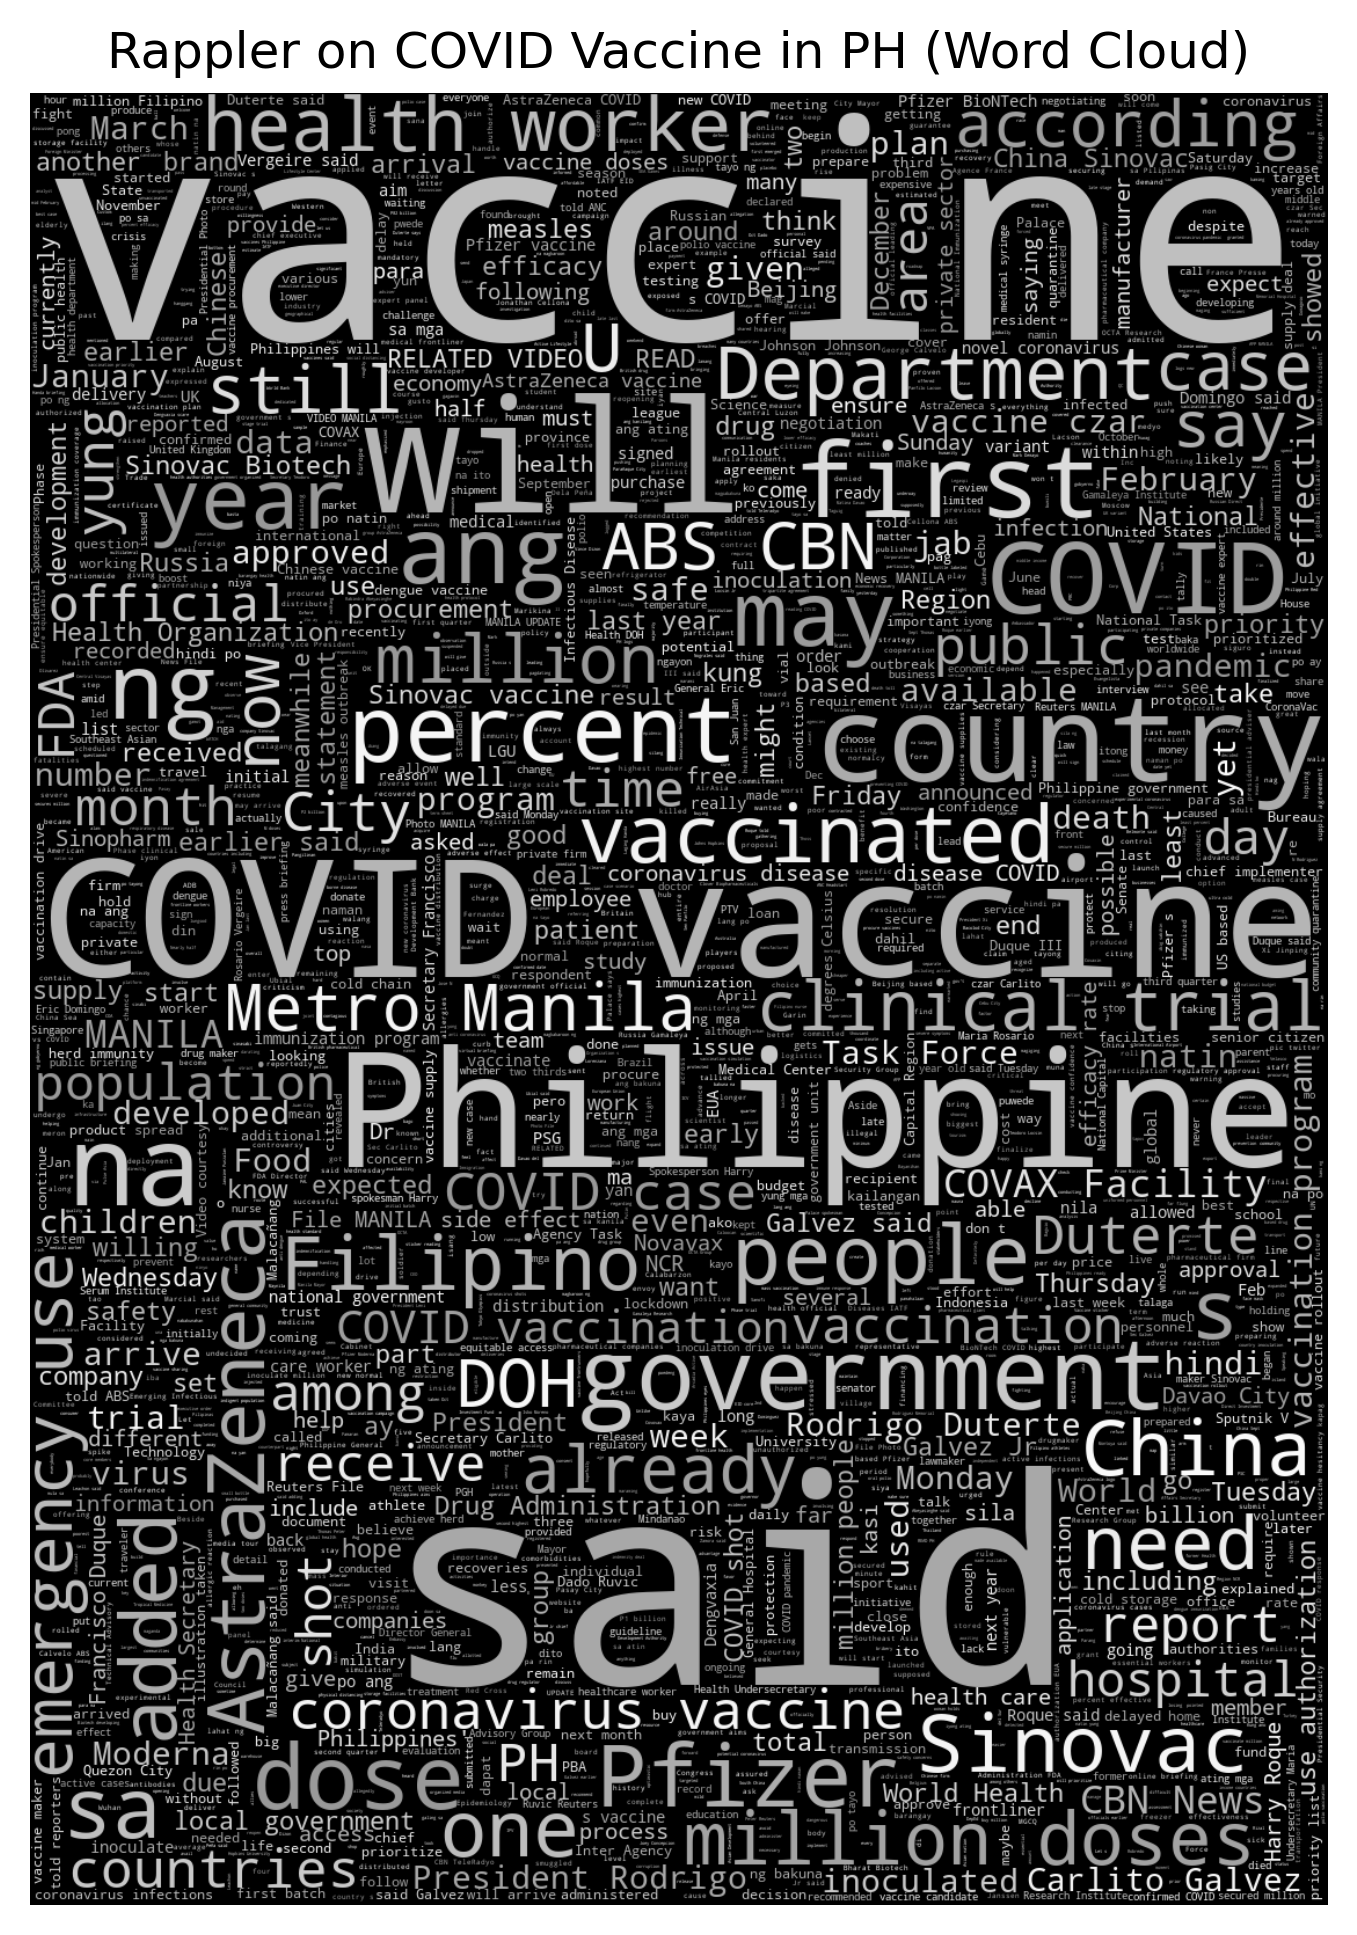

In [39]:
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % np.random.randint(60, 100)

mask = np.array(Image.open('bg.png'))

words = ' '.join(df['articles_content'].tolist())
wordcloud = WordCloud(background_color='black', max_words=2000, width=1024, height=720, mask=mask)
wordcloud.generate(words)

plt.figure(figsize=(20, 8), dpi=300)
plt.title('Rappler on COVID Vaccine in PH (Word Cloud)')
plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=42), interpolation='bilinear')
plt.axis('off')
plt.show()